## Below the steps to identify the most promising stocks using the NCAV approach

1. have an excel file with all the tickers extracted from a filter on tradingview
2. load the tickers from the file and compute the ones having current assets > total liab
3. filter out the ones not respecting condition 2
4. compute the ncav(ps) and liqv(ps) of the last annual report
5. create a flag column "below ncav" indicating whether the price is below ncavps
6. create a flag column "below liqv" indicating whether the price is below liqvps
7. create a flag column if both 5 and 6 are respected
8. take the tickers respecting any of the condition 5, 6 or 7 and create the history plots
9. Select by hand the most promising ones
10. for the selected ones get the price to ncav ratio and price to liqv ratio
11. Sort by any of the two and see the most promising tickers

## Imports

In [88]:
import certifi
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from urllib.request import urlopen
from valuation.extraction import *
from valuation.liquidation import *
from valuation.constants import *
from valuation.eps_multiple import compute_de_ratio
from valuation.utils import plot_indicators_ncav

## Functions

In [ ]:
def compute_prelim_ncav(deco):
    return deco["totalCurrentAssets"] - deco["totalLiabilities"] > 0

def fill_w_none(deco, key):
    if key not in deco:
        deco[key] = 0

def get_price(deco):
    return deco["price"]

def compute_ncav(deco) -> float:
    return deco["totalCurrentAssets"] - deco["totalLiabilities"]

def compute_liqv(deco, factors_deco) -> float:
    fill_w_none(deco, "cashAndCashEquivalents")
    fill_w_none(deco, "netReceivables")
    fill_w_none(deco, "inventory")
    fill_w_none(deco, "propertyPlantEquipmentNet")
    return (
        deco["cashAndCashEquivalents"] +
        factors_deco["receivables_factor"]*deco["netReceivables"] +
        factors_deco["inventory_factor"]*deco["inventory"] +
        factors_deco["ppe_factor"]*deco["propertyPlantEquipmentNet"] -
        deco["totalLiabilities"]
    )

def compute_ncavps(deco) -> float:
    if deco["weightedAverageShsOutDil"] == 0:
        return -np.Inf
    ncav = compute_ncav(deco)
    return ncav / deco["weightedAverageShsOutDil"]

def compute_liqvps(deco, factors_deco) -> float:
    if deco["weightedAverageShsOutDil"] == 0:
        return -np.Inf
    liqv = compute_liqv(deco, factors_deco)
    return liqv / deco["weightedAverageShsOutDil"]

def compute_current_ratio(deco) -> float:
    return deco["totalCurrentAssets"] / (deco["totalCurrentLiabilities"] + 0.1)

def compute_de_ratio1(deco) -> float:
    return deco["totalLiabilities"] / (deco["totalStockholdersEquity"] + 0.1)

def compute_de_ratio2(deco) -> float:
    return deco["totalCurrentLiabilities"] / (deco["totalStockholdersEquity"] + 0.1)

def compute_de_ratio3(deco) -> float:
    return deco["totalDebt"] / (deco["totalStockholdersEquity"] + 0.1)

def plot_indicators(df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(1, 11, figsize=(30, 2))
    fs_df["ncavps"].plot.bar(ax=ax[0], title = "ncavps")
    df["liqvps"].plot.bar(ax=ax[1], title = "liqvps")
    df["totalCurrentAssets"].plot.bar(ax=ax[2], title = "current assets")
    df["totalCurrentLiabilities"].plot.bar(ax=ax[3], title = "current liab")
    min_ylim, max_ylim = (
        min(df["totalCurrentAssets"].min(), df["totalCurrentLiabilities"].min()),
        max(df["totalCurrentAssets"].max(), df["totalCurrentLiabilities"].max())
    )
    ax[2].set_ylim([min_ylim, max_ylim])
    ax[3].set_ylim([min_ylim, max_ylim])
    del min_ylim
    del max_ylim
    df["current_ratio"].plot.bar(ax=ax[4], title = "current ratio")
    df["totalAssets"].plot.bar(ax=ax[5], title = "total assets")
    df["totalLiabilities"].plot.bar(ax=ax[6], title = "total liab")
    min_ylim, max_ylim = (
        min(df["totalAssets"].min(), df["totalLiabilities"].min()),
        max(df["totalAssets"].max(), df["totalLiabilities"].max())
    )
    ax[5].set_ylim([min_ylim, max_ylim])
    ax[6].set_ylim([min_ylim, max_ylim])
    del min_ylim
    del max_ylim
    df["weightedAverageShsOutDil"].plot.bar(ax=ax[7], title = "shares outs")
    df["de_ratio1"].plot.bar(ax=ax[8], title = "total liab / shares outs")
    df["de_ratio2"].plot.bar(ax=ax[9], title = "current liab / shares outs")
    df["de_ratio3"].plot.bar(ax=ax[10], title = "total debt / shares outs")
    min_ylim, max_ylim = (
        min(df["de_ratio1"].min(), df["de_ratio2"].min(), df["de_ratio3"].min()),
        max(df["de_ratio1"].max(), df["de_ratio2"].max(), df["de_ratio3"].max())
    )
    ax[8].set_ylim([min_ylim, max_ylim])
    ax[9].set_ylim([min_ylim, max_ylim])
    ax[10].set_ylim([min_ylim, max_ylim])
    del min_ylim
    del max_ylim
    plt.show()

## Constants

In [ ]:
KEY_PATH = "fmi-personal-key.txt"
with open(KEY_PATH, "r") as f:
    KEY = f.read()

In [90]:
factors = {
    "receivables_factor": 0.8,
    "inventory_factor": 0.6,
    "ppe_factor": 0.67,
}

In [91]:
bs_cols = [
    "symbol", "cashAndCashEquivalents", "netReceivables",
    "inventory", "propertyPlantEquipmentNet",
    "totalCurrentAssets", "totalAssets", "totalCurrentLiabilities", 
    "totalLiabilities", "totalStockholdersEquity",
    "totalDebt", "netDebt",
]
is_cols = [
    "weightedAverageShsOutDil",
]

# Load tickers

In [3]:
with open("tickers_list_28062023.txt", "r") as f:
    TICKERS = f.read().split("\n")

In [4]:
# this will get rid of duplicated tickers.
# THis means there will only be one ticker for different companies having the same symbol in different exchanges
TICKERS = list(set(TICKERS))

Below we compute the preliminary NCAV (current assets - total_liabilities). By doing this we strictly focus ourselves in filtering out the companies that will for sure not have a positive NCAV
We will filter out the companies that don't have a positive preliminary NCAV
On the rest of the accepted companies we will flag those having a current price below ncav, current price below liqv and current price below both ncav and liqv

In [9]:
COLS_WITH_SAME_SCALE = [
    ["totalCurrentAssets", "totalCurrentLiabilities"],
    ["totalAssets", "totalLiabilities"],
    ["de_ratio1", "de_ratio2", "de_ratio3"],
]

In [10]:
def plot_indicators_ncav(df: pd.DataFrame) -> None:
    num_cols = df.shape[1]
    num_plots = min(num_cols, 11)  # Limit to 11 subplots or the number of columns
    _, ax = plt.subplots(1, num_plots, figsize=(26, 3))

    for i in range(num_plots):
        col_name = COLS_TO_PLOT_NCAV[i]
        df[col_name].plot.bar(ax=ax[i], title=SUBPLOT_NAMES[col_name])
        for cols in COLS_WITH_SAME_SCALE:
            if col_name in cols:#["totalAssets", "totalLiabilities", "de_ratio1", "de_ratio2", "de_ratio3"]:
                #min_ylim, max_ylim = df[col_name].min(), df[col_name].max()
                min_ylim = df[cols].min().min() #min([df[col].min() for col in cols])
                max_ylim = df[cols].max().max() #max([df[col].max() for col in cols])
                ax[i].set_ylim([min_ylim, max_ylim])
                break

    plt.tight_layout()
    plt.show()

## Current code extracting from the db

In [57]:
from sqlalchemy import create_engine
from valuation.data_injection import Injector
from sqlalchemy.pool import QueuePool
import pandas as pd
import numpy as np
from valuation.liquidation import compute_liqvps, compute_ncavps
from valuation.extraction import get_current_price
import time
from tqdm import tqdm

In [81]:
injector = Injector()
engine = create_engine(injector.db_uri, poolclass=QueuePool, pool_size=10, max_overflow=20)

In [86]:
%%time
# NEW CODE
# compute preliminary ncav (current assets - total liabilities)
preliminary_ncav = {}
zero_current_price = []
missed_ticker = []
tickers_to_accept = []
notes = {}
full_df = pd.DataFrame()

# Get all tickers
query = """
select *
from company_tickers
"""
with engine.connect() as connection:
    df = pd.read_sql(query, connection)

all_tickers = df["ticker"].tolist()

# Filter tickers that exist in tradingview/ibkr or something
all_tickers = [ticker for ticker in all_tickers if "." not in ticker]
potential_candidates = []
single_api_call_amount = 300
for idx, ticker in tqdm(enumerate(all_tickers)):
    # api limit consideration
    if (idx % single_api_call_amount == 0) and (idx != 0):
        print(f"{idx} out of {len(all_tickers)} seen")
    query = f"""
    select *
    from financial_stmts
    where symbol_bs = '{ticker}'
    order by date desc
    limit 1;
    """
    with engine.connect() as connection:
        df = pd.read_sql(query, connection)
    if len(df) == 0:
        continue
    period = df.loc[0, "period_bs"]
    if period is None:
        continue
    query = f"""
    select *
    from financial_stmts
    where symbol_bs = '{ticker}' and
        period_bs = '{period}'
    """
    with engine.connect() as connection:
        df = pd.read_sql(query, connection)
    
    cols = list(df.columns)
    cols = [col.split("_")[0] for col in cols]
    df.columns = cols
    df = df[::-1]
    y = df.loc[~pd.isna(df["weightedAverageShsOutDil"]), "weightedAverageShsOutDil"]
    x = range(len(y))
    if len(y) < 2:
        continue
    slope, y_intercept = np.polyfit(
        x,
        df.loc[~pd.isna(df["weightedAverageShsOutDil"]), "weightedAverageShsOutDil"],
        1,
    )
    start, end = (slope * x + y_intercept)[0], (slope * x + y_intercept)[-1]
    slope_percentage = (end - start) / start
    if slope_percentage > 0.2:
        continue
    y_5y = df.tail(5).loc[~pd.isna(df.tail(5)["weightedAverageShsOutDil"]), "weightedAverageShsOutDil"]
    x_5y = range(len(y_5y))
    if len(y_5y) < 2:
        continue
    slope_5y, y_intercept_5y = np.polyfit(
        x_5y,
        y_5y,
        1,
    )
    start_5y, end_5y = (slope_5y * x_5y + y_intercept_5y)[0], (slope_5y * x_5y + y_intercept_5y)[-1]
    slope_percentage_5y = (end_5y - start_5y) / start_5y
    if slope_percentage_5y > 0.2:
        continue
        
    # get ncav and liqv
    last_date_financials = df[
        df["fillingDate"] == max(df["fillingDate"])
    ]
    ncavps = compute_ncavps(last_date_financials.to_dict("records")[0])
    # get current price
    current_price = get_current_price(ticker)
    time.sleep(0.5)
    if current_price is None:
        continue
        
    # filter by value
    if current_price > ncavps:
        continue
    ncav_mos = round(100 * (ncavps - current_price) / ncavps, 2)
    if ncav_mos < 33:
        continue
    
    # add candidate if all filters are passed
    potential_candidates.append(ticker)
    
connection.close()
engine.dispose()

5it [00:06,  1.25s/it]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
28it [00:22,  1.47it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
84it [00:57,  2.20it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
148it [01:31,  1.78it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
150it [01:32,  1.72it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
223it [02:17,  2.40it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
299it [02:59,  1.67it/s]

300 out of 23023 seen


310it [03:03,  2.45it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
343it [03:16,  2.30it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
347it [03:18,  2.50it/s]<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
394it [03:41,  2.66it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
474it [04:33,  1.28it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
522it [05:02,  1.46it/s]<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
558it [05:14,  2.60it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
579it [05:22,  2.06it/s]<timed exec>:65: RuntimeWarning: invalid value e

600 out of 23023 seen


646it [06:04,  1.27it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
654it [06:05,  2.81it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
655it [06:06,  2.24it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
656it [06:07,  1.83it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
657it [06:09,  1.54it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
658it [06:10,  1.33it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: Run

900 out of 23023 seen


902it [08:46,  1.88it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
907it [08:50,  1.62it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
942it [09:13,  1.38it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
1045it [09:59,  1.83it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
1097it [10:28,  1.67it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
1151it [10:55,  2.66it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
1200it [11:16,  2.44it/s]

1200 out of 23023 seen


1332it [12:35,  1.68it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
1348it [12:37,  5.36it/s]<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
1363it [12:46,  1.63it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
1404it [13:11,  1.79it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
1413it [13:15,  2.33it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
1462it [13:39,  1.45it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
1476it [13:45,  1.71it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
1498it [13:57,  2.00it/s]

1500 out of 23023 seen


1585it [14:41,  1.44it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
1638it [15:15,  1.39it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
1653it [15:21,  3.54it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
1687it [15:40,  2.56it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
1704it [15:48,  1.89it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
1800it [16:35,  2.42it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide


1800 out of 23023 seen


1815it [16:42,  1.90it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
1818it [16:44,  1.60it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
1825it [16:48,  1.54it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
1848it [16:58,  1.75it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
1849it [17:00,  1.40it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
1860it [17:11,  1.14s/it]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:7

2100 out of 23023 seen


2156it [20:02,  2.41it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
2178it [20:14,  1.74it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
2193it [20:22,  1.65it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
2195it [20:24,  1.63it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
2196it [20:25,  1.39it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
2206it [20:30,  2.04it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:7

2400 out of 23023 seen


2437it [22:24,  1.59it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
2528it [23:04,  1.72it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
2537it [23:11,  1.20it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
2542it [23:15,  1.30it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
2636it [24:10,  1.53it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
2647it [24:17,  1.48it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:7

2700 out of 23023 seen


2732it [24:50,  4.23it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
2741it [24:57,  1.65it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
2744it [24:58,  1.90it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
2825it [25:52,  1.33it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
2938it [26:54,  1.51it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
2940it [26:57,  1.17it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:7

3000 out of 23023 seen


3008it [27:25,  3.91it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3015it [27:29,  2.90it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3082it [28:07,  1.92it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3101it [28:21,  1.89it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3102it [28:22,  1.59it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3129it [28:43,  1.74it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:7

3300 out of 23023 seen


3307it [30:20,  1.75it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3382it [30:57,  1.87it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3385it [30:59,  2.04it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3447it [31:41,  1.03it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
3472it [31:58,  1.17it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3473it [31:59,  1.07it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3540it [32:30,

3600 out of 23023 seen


3638it [33:18,  3.19it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3715it [34:00,  1.18it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3738it [34:17,  1.73it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3748it [34:22,  1.96it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3766it [34:27,  4.62it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
3769it [34:28,  3.69it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
3800it [34:46,  1.55it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in sca

3900 out of 23023 seen


3908it [35:44,  3.44it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3912it [35:47,  2.43it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
3935it [35:58,  2.06it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3951it [36:06,  2.20it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3976it [36:14,  4.06it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3982it [36:19,  1.90it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
3991it [36:26,

4200 out of 23023 seen


4216it [38:27,  1.37it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
4268it [38:55,  1.42it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
4320it [39:20,  1.33it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
4344it [39:33,  1.82it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
4360it [39:42,  1.51it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
4361it [39:44,  1.26it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
4410it [40:04,

4500 out of 23023 seen


4606it [41:29,  5.28it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
4614it [41:37,  1.58it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
4657it [42:06,  1.45it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
4712it [42:41,  2.69it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
4716it [42:43,  2.75it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
4745it [42:54,  1.75it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
4765it [43:05,

4800 out of 23023 seen


4813it [43:36,  1.51it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
4815it [43:37,  1.55it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
4834it [43:44,  1.86it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
4867it [44:03,  1.90it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
4893it [44:13,  3.04it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
4920it [44:20,  7.52it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:7

5100 out of 23023 seen


5103it [46:08,  2.72it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
5105it [46:10,  2.39it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
5107it [46:11,  2.16it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
5141it [46:27,  1.33it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
5252it [47:32,  1.71it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
5263it [47:40,  1.37it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:7

5400 out of 23023 seen


5438it [49:08,  1.63it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
5440it [49:10,  1.64it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
5464it [49:24,  1.49it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
5475it [49:30,  1.58it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
5491it [49:43,  1.21it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
5493it [49:45,  1.34it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
5521it [49:56,  1.66it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in sca

5700 out of 23023 seen


5706it [51:25,  2.53it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
5807it [52:11,  2.73it/s]<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
5858it [52:44,  1.39it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
5889it [53:05,  1.54it/s]<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
5914it [53:20,  1.76it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
5946it [53:41,  1.38it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
5955it [53:43,  2.29it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
5971it [53:50,  2.44it/s]<timed exec>:65: RuntimeWarning: invalid

6000 out of 23023 seen


6021it [54:19,  1.01it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
6049it [54:27,  3.23it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6077it [54:38,  1.66it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6078it [54:39,  1.41it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6086it [54:43,  2.02it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
6150it [55:15,  1.75it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6169it [55:32,  1.12s/it]<timed exec>:65: RuntimeWarning: invalid value encountered in sca

6300 out of 23023 seen


6302it [56:36,  1.13it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6331it [56:51,  1.88it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6374it [57:25,  1.01s/it]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6383it [57:32,  1.43it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6391it [57:33,  3.49it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6407it [57:47,  1.17it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:7

6600 out of 23023 seen


6611it [59:43,  1.12it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
6653it [1:00:01,  1.49it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6681it [1:00:21,  1.05it/s]<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6699it [1:00:34,  1.33it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6700it [1:00:35,  1.17it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6704it [1:00:37,  1.42it/s]<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6716it [1:00:43,  2.20it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encoun

6900 out of 23023 seen


6909it [1:02:10,  1.83it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6913it [1:02:14,  1.35it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6940it [1:02:30,  1.97it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6943it [1:02:31,  2.12it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
6955it [1:02:38,  1.57it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
7124it [1:03:58,  3.10it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<t

7200 out of 23023 seen


7243it [1:05:01,  1.19it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
7283it [1:05:17,  2.43it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
7295it [1:05:24,  1.72it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
7348it [1:05:53,  1.45it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
7370it [1:06:02,  1.84it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
7385it [1:06:07,  2.25it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
7400it [1:06:16,  2.01it/s]<timed exec>:65: RuntimeWarning: invalid value enco

7500 out of 23023 seen


7573it [1:07:37,  1.51it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
7662it [1:08:34,  1.70it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
7667it [1:08:35,  2.38it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
7698it [1:08:52,  1.91it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
7700it [1:08:53,  1.75it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
7701it [1:08:55,  1.49it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<t

7800 out of 23023 seen


7832it [1:09:57,  2.21it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
7843it [1:09:58,  5.82it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
7867it [1:10:18,  1.57it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
7869it [1:10:21,  1.15it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
8056it [1:12:13,  2.42it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
8058it [1:12:14,  2.19it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
81

8100 out of 23023 seen


8136it [1:13:13,  1.28it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
8160it [1:13:27,  1.54it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
8220it [1:13:50,  1.29it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
8235it [1:13:58,  1.67it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
8324it [1:14:56,  1.21s/it]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
8329it [1:15:01,  1.09s/it]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
83

8400 out of 23023 seen


8430it [1:15:58,  1.72it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
8477it [1:16:31,  1.09it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
8504it [1:16:45,  1.19it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
8542it [1:17:04,  1.57it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
8543it [1:17:05,  1.36it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
8573it [1:17:26,  1.61it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<t

8700 out of 23023 seen


8716it [1:19:03,  1.40it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
8775it [1:19:35,  2.03it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
8807it [1:19:51,  2.33it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
8814it [1:19:54,  2.41it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
8832it [1:20:04,  1.87it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
8864it [1:20:10,  4.09it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
88

9000 out of 23023 seen


9003it [1:21:35,  1.05it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
9045it [1:22:02,  1.10it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
9060it [1:22:12,  1.54it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
9068it [1:22:18,  1.47it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
9097it [1:22:34,  1.72it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
9103it [1:22:36,  2.17it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
9126it [1:22:50,  1.45it/s]<timed exec>:65: RuntimeWarning: invalid value enco

9300 out of 23023 seen


9393it [1:25:12,  1.92it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
9464it [1:26:03,  1.14it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
9528it [1:26:36,  1.02s/it]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
9553it [1:26:47,  2.16it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
9566it [1:26:52,  2.36it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
9578it [1:26:59,  2.03it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<t

9600 out of 23023 seen


9611it [1:27:26,  1.04s/it]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
9695it [1:28:10,  1.47it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
9757it [1:28:40,  3.08it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
9765it [1:28:44,  2.33it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
9769it [1:28:45,  2.61it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
9828it [1:29:12,  2.15it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
9829it [1:29:13,  1.76it/s]<timed exec>:65: RuntimeWarning: invalid value enco

9900 out of 23023 seen


9902it [1:30:00,  1.47it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
9961it [1:30:26,  4.14it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
9973it [1:30:32,  2.22it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
9981it [1:30:35,  2.55it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
9996it [1:30:41,  2.03it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
10003it [1:30:45,  2.03it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
10019it [1:30:56,  1.41it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value en

10200 out of 23023 seen


10209it [1:32:33,  1.01s/it]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
10228it [1:32:48,  1.10it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
10246it [1:33:01,  1.63it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
10324it [1:33:39,  3.03it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
10398it [1:34:17,  1.88it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
10464it [1:34:51,  1.42it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
10489it [1:35:07,  1.11it/s]<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
10499it [1:35:13,  1.64it/s]

10500 out of 23023 seen


10528it [1:35:32,  1.22it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
10574it [1:36:05,  1.78it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
10595it [1:36:23,  1.36it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
10617it [1:36:33,  2.15it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
10626it [1:36:36,  2.01it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
10641it [1:36:49,  1.00it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
10653it [1:36:57,  1.12it/s]<timed exec>:65: RuntimeWarning: invalid val

10800 out of 23023 seen


10831it [1:38:29,  1.50it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
10838it [1:38:30,  2.77it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
10861it [1:38:38,  3.28it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
10896it [1:38:56,  1.15it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
10918it [1:39:03,  2.57it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
10936it [1:39:15,  1.12it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar div

11100 out of 23023 seen


11102it [1:40:38,  2.90it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
11145it [1:41:09,  1.19it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
11187it [1:41:21,  2.38it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
11205it [1:41:32,  1.51it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
11260it [1:41:56,  2.28it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
11292it [1:42:18,  1.02it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar div

11400 out of 23023 seen


11488it [1:43:52,  1.52it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
11571it [1:44:35,  1.48it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
11608it [1:44:52,  2.38it/s]<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
11700it [1:45:33,  2.20it/s]

11700 out of 23023 seen


11722it [1:45:50,  1.10it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
11735it [1:45:59,  1.71it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
11757it [1:46:12,  2.47it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
11789it [1:46:49,  1.21s/it]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
11892it [1:47:50,  2.98it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
11952it [1:48:23,  1.13it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
12000it [1:48:42,  2.08it/s]

12000 out of 23023 seen


12094it [1:49:46,  1.38it/s]<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
12235it [1:51:04,  1.04it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
12262it [1:51:21,  1.68it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
12266it [1:51:22,  2.15it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
12267it [1:51:23,  1.70it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
12299it [1:51:41,  1.06it/s]

12300 out of 23023 seen


12317it [1:51:46,  2.58it/s]<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
12346it [1:51:59,  2.86it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
12362it [1:52:10,  1.06it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
12386it [1:52:25,  1.59it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
12466it [1:53:10,  1.37it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
12510it [1:53:39,  1.13it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
12600it [1:54:23,  1.57it/s]

12600 out of 23023 seen


12627it [1:54:34,  1.94it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
12630it [1:54:36,  2.00it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
12631it [1:54:37,  1.69it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
12689it [1:55:03,  2.08it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
12726it [1:55:20,  1.54it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar divide
12745it [1:55:31,  1.73it/s]<timed exec>:65: RuntimeWarning: invalid value encountered in scalar divide
<timed exec>:78: RuntimeWarning: invalid value encountered in scalar div

TypeError: '>' not supported between instances of 'NoneType' and 'NoneType'

In [87]:
len(potential_candidates)

543

## Previous yet useful code

  1%|█▌                                                                                                                      | 7/543 [00:13<17:18,  1.94s/it]

dates of last income statement and balance sheet are not the same for ticker ACAVF
	income stmt date: 2006-12-31, balance sheet date: 2005-12-31


  3%|███▋                                                                                                                   | 17/543 [00:25<08:00,  1.09it/s]

AEHL.	 Current price: 1.91.	 NCAV: 673.7269818298006.	 LIQV: 995.9685134455716


  4%|████▍                                                                                                                  | 20/543 [00:34<16:39,  1.91s/it]

AEZS.	 Current price: 1.9.	 NCAV: 298.8125530110263.	 LIQV: 300.04834605597966


  5%|█████▍                                                                                                                 | 25/543 [00:47<18:54,  2.19s/it]

dates of last income statement and balance sheet are not the same for ticker AHG
	income stmt date: 2015-03-31, balance sheet date: 2016-03-31
AHICF.	 Current price: 11.07.	 NCAV: 35.78599453784314.	 LIQV: 40.48052176715027


  5%|█████▋                                                                                                                 | 26/543 [00:52<25:15,  2.93s/it]

AHPI.	 Current price: 0.004.	 NCAV: 3.3905581760265973.	 LIQV: 2.151115963107777


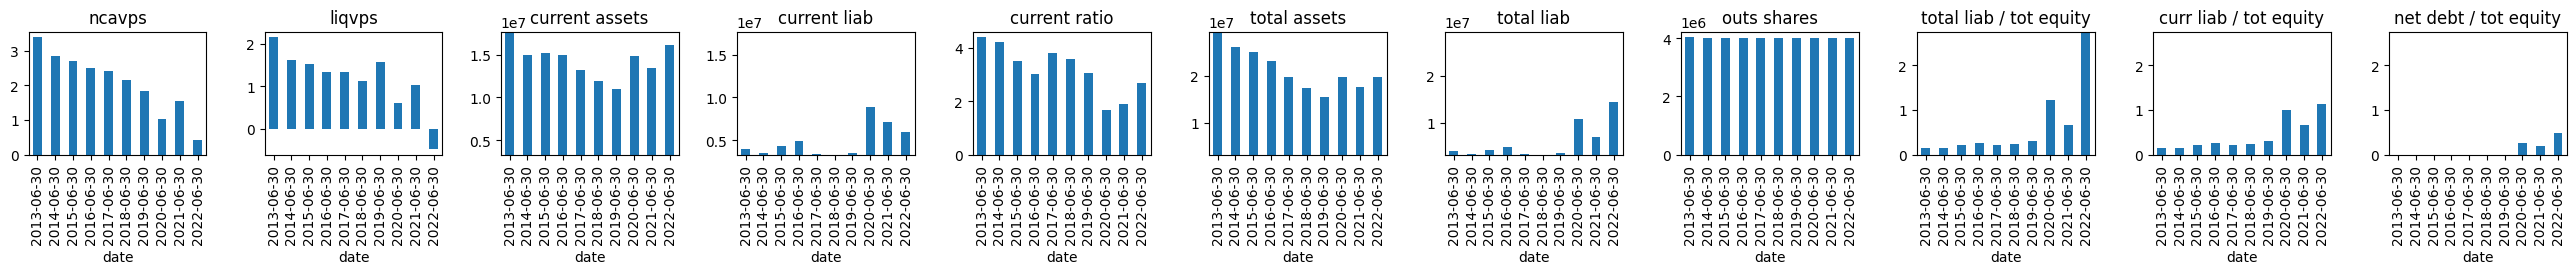

  5%|██████▏                                                                                                                | 28/543 [00:57<22:22,  2.61s/it]

AIFLF.	 Current price: 1.84.	 NCAV: 175.1284591632257.	 LIQV: -725.454233856765


  6%|███████▏                                                                                                               | 33/543 [01:08<17:03,  2.01s/it]

AITUF.	 Current price: 7.28.	 NCAV: 263.30468672439764.	 LIQV: 244.9171532727705


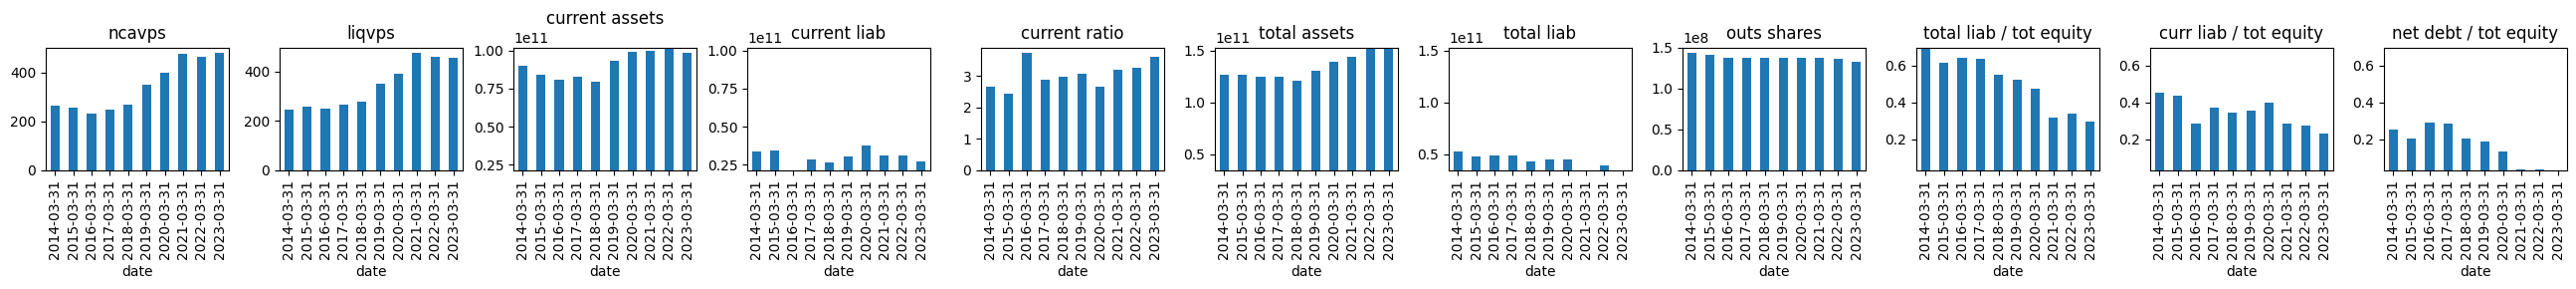

  7%|████████▎                                                                                                              | 38/543 [01:19<14:24,  1.71s/it]

AKTX.	 Current price: 2.85.	 NCAV: 27.58705771265617.	 LIQV: 27.42098495380805


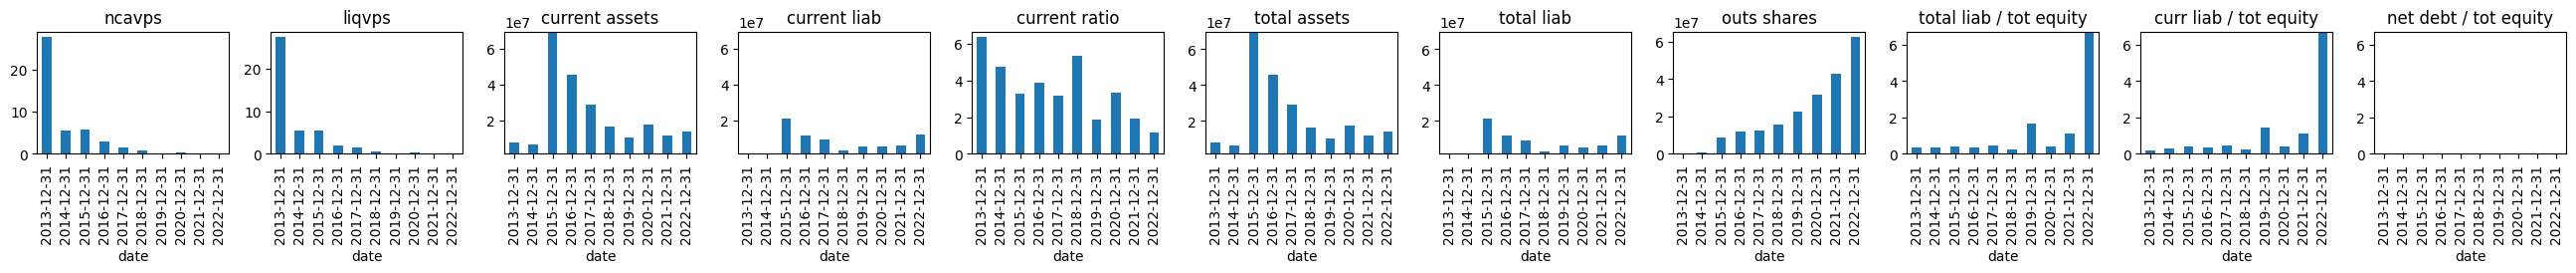

  8%|█████████▏                                                                                                             | 42/543 [01:30<19:07,  2.29s/it]

dates of last income statement and balance sheet are not the same for ticker AMAL
	income stmt date: 2014-12-31, balance sheet date: 2016-12-31


  8%|█████████▍                                                                                                             | 43/543 [01:32<18:21,  2.20s/it]

dates of last income statement and balance sheet are not the same for ticker AMGXF
	income stmt date: 2012-12-31, balance sheet date: 2013-12-31
ANFIF.	 Current price: 1e-06.	 NCAV: 3.291369471538771.	 LIQV: -92.89677344930486


  8%|██████████                                                                                                             | 46/543 [01:40<20:05,  2.42s/it]

dates of last income statement and balance sheet are not the same for ticker ANTOF
	income stmt date: 2014-01-31, balance sheet date: 2014-03-31


 10%|███████████▊                                                                                                           | 54/543 [01:52<13:16,  1.63s/it]

ARTLW.	 Current price: 0.0398.	 NCAV: 0.5750702685821362.	 LIQV: 0.5750702685821362


 10%|████████████                                                                                                           | 55/543 [01:56<20:06,  2.47s/it]

ARUXF.	 Current price: 0.0352.	 NCAV: 0.12139558186499777.	 LIQV: 0.2009790182854895


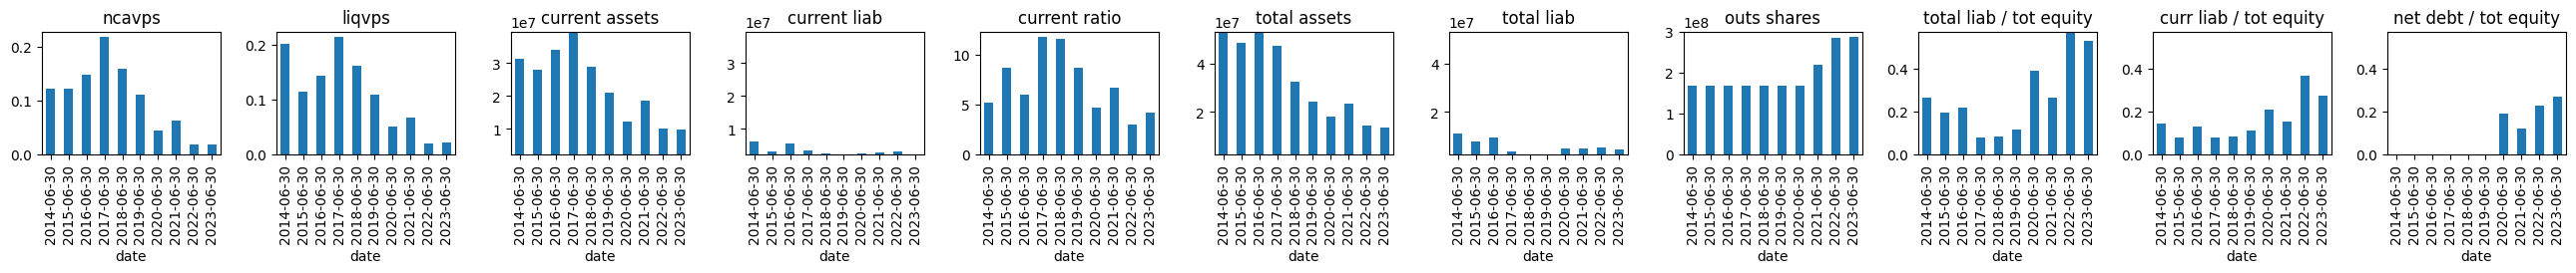

 11%|█████████████▏                                                                                                         | 60/543 [02:04<10:21,  1.29s/it]

ASCCF.	 Current price: 29.834.	 NCAV: 369.48678727781004.	 LIQV: 242.0237354290838


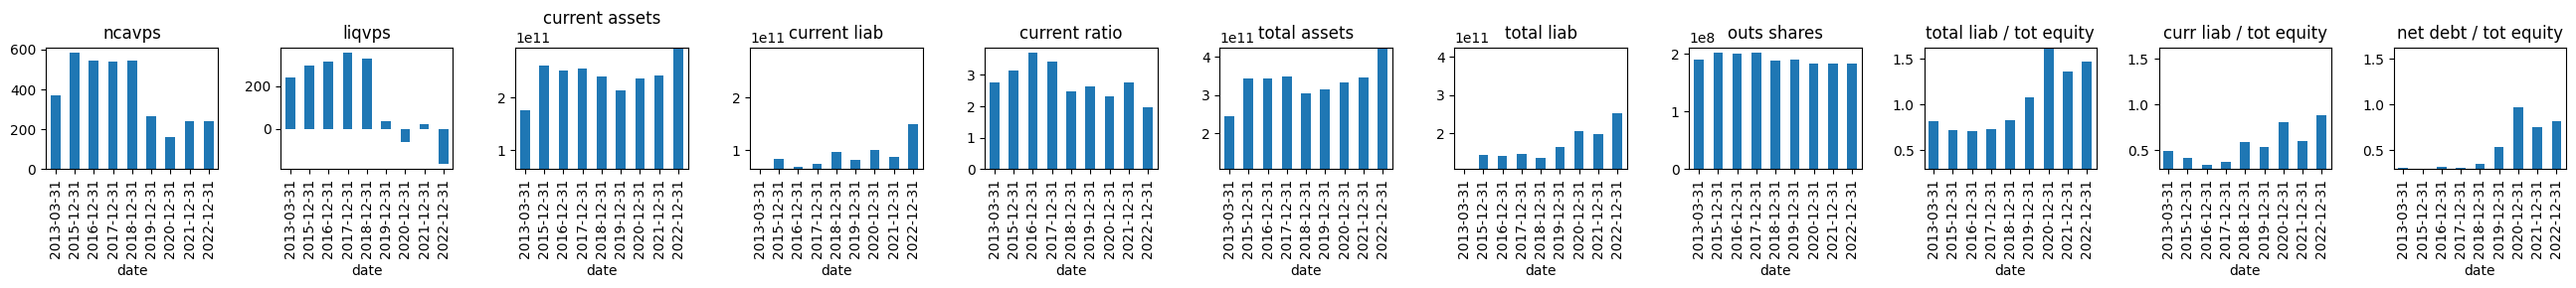

 11%|█████████████▎                                                                                                         | 61/543 [02:08<17:47,  2.22s/it]

ASMVF.	 Current price: 10.12.	 NCAV: 10.889475590413507.	 LIQV: 3.1491893444567944


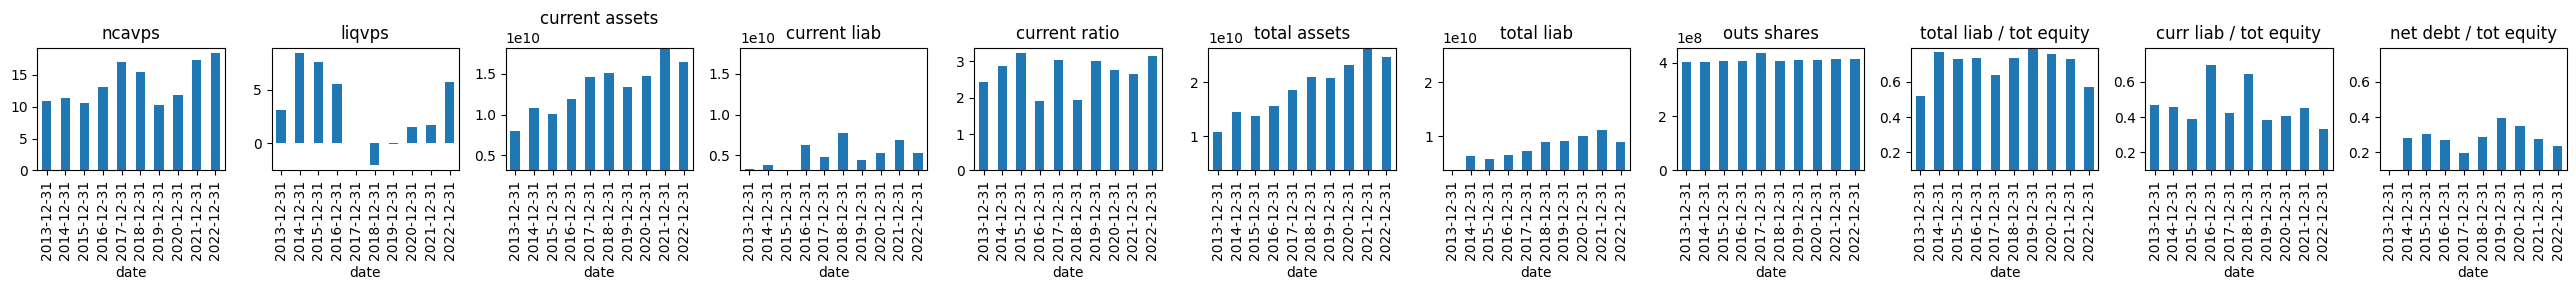

 11%|█████████████▌                                                                                                         | 62/543 [02:13<23:01,  2.87s/it]

ASMVY.	 Current price: 26.74.	 NCAV: 32.668426689641876.	 LIQV: 9.472895531533526


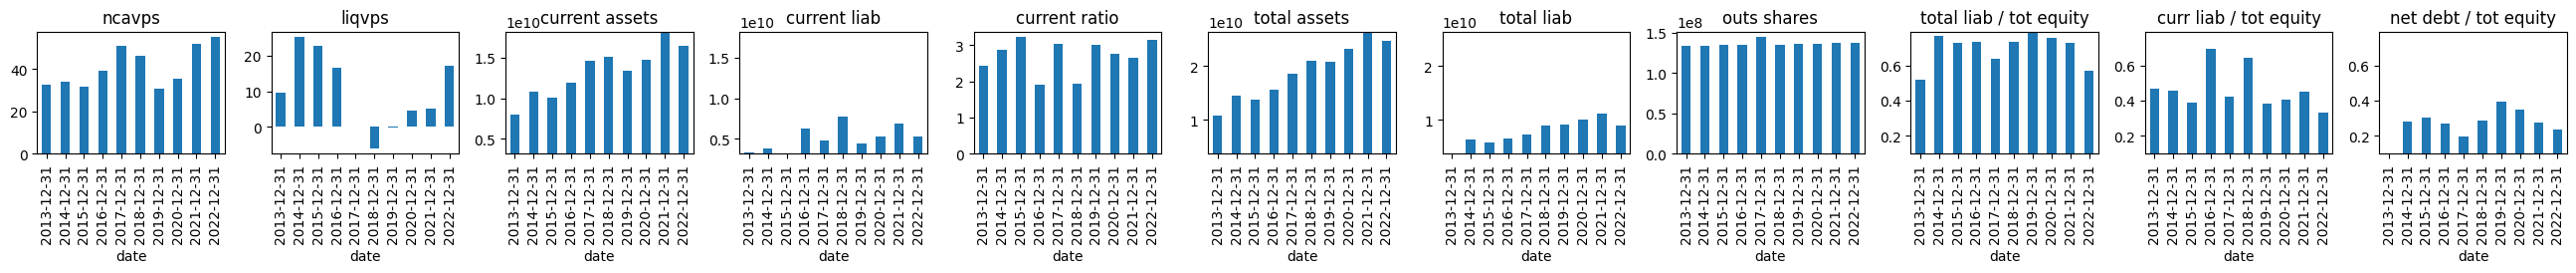

 13%|███████████████▎                                                                                                       | 70/543 [02:33<18:35,  2.36s/it]

ATYM.	 Current price: 1e-06.	 NCAV: 0.025996507172318162.	 LIQV: -0.12517712089943503


 13%|███████████████▌                                                                                                       | 71/543 [02:38<22:54,  2.91s/it]

AUEEF.	 Current price: 0.195.	 NCAV: 0.02030988663053475.	 LIQV: 0.37521517072953553


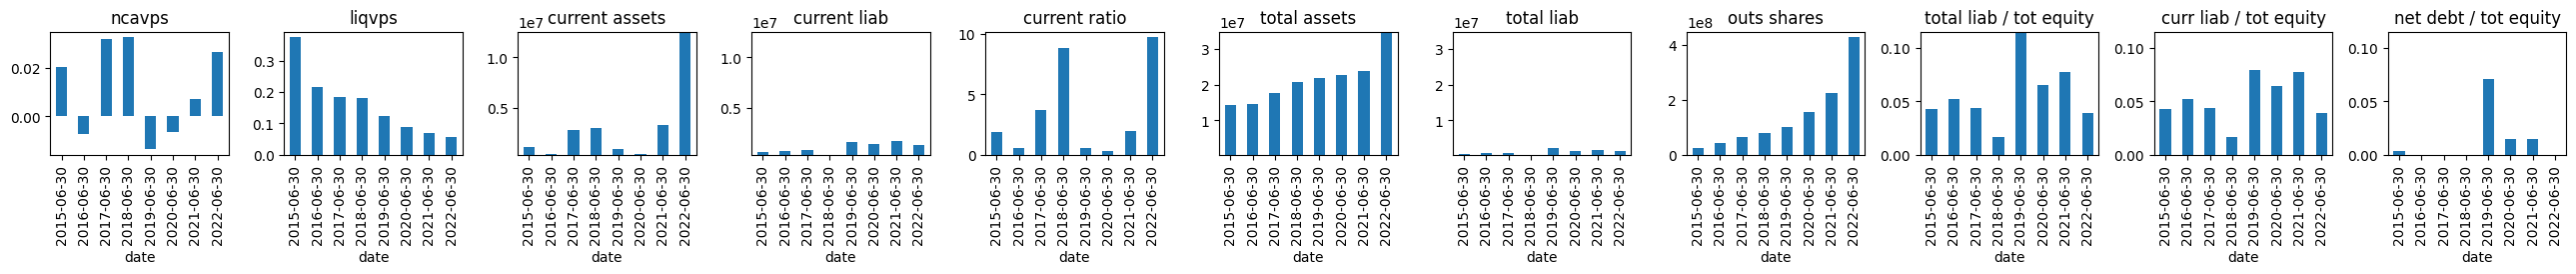

 14%|████████████████▍                                                                                                      | 75/543 [02:47<16:02,  2.06s/it]

AXAS.	 Current price: 0.0347.	 NCAV: -20.78192820030362.	 LIQV: 3.503421069511856


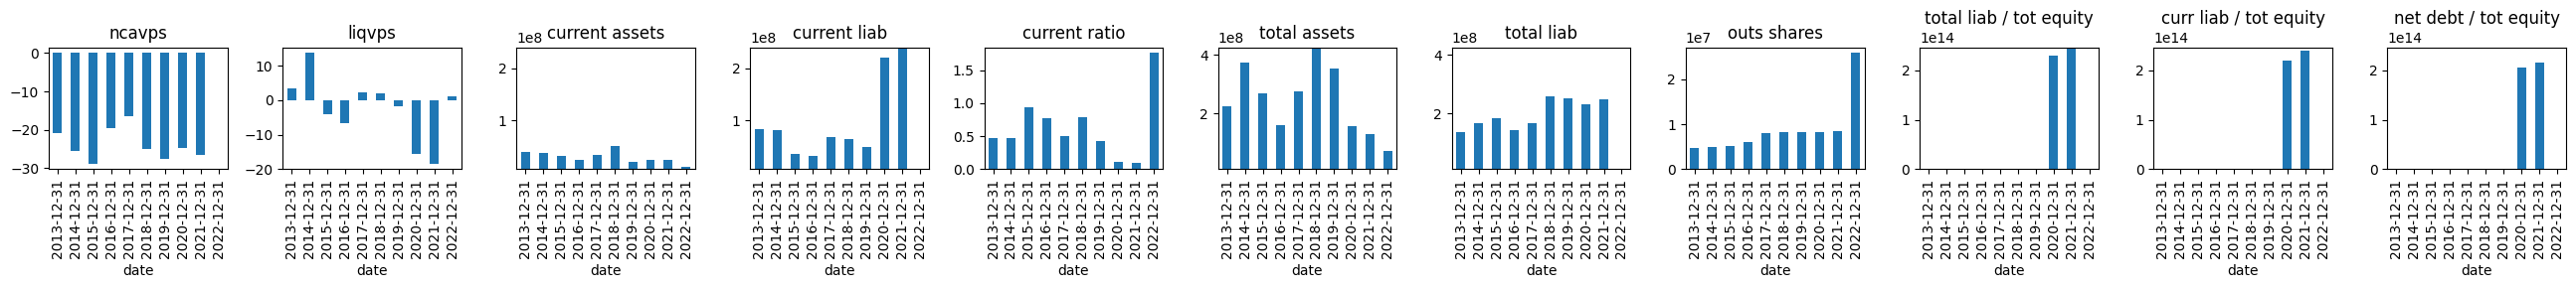

 15%|█████████████████▊                                                                                                     | 81/543 [02:58<11:13,  1.46s/it]

BBI.	 Current price: 2.35.	 NCAV: 2879.1865152070354.	 LIQV: 1501.82777574203


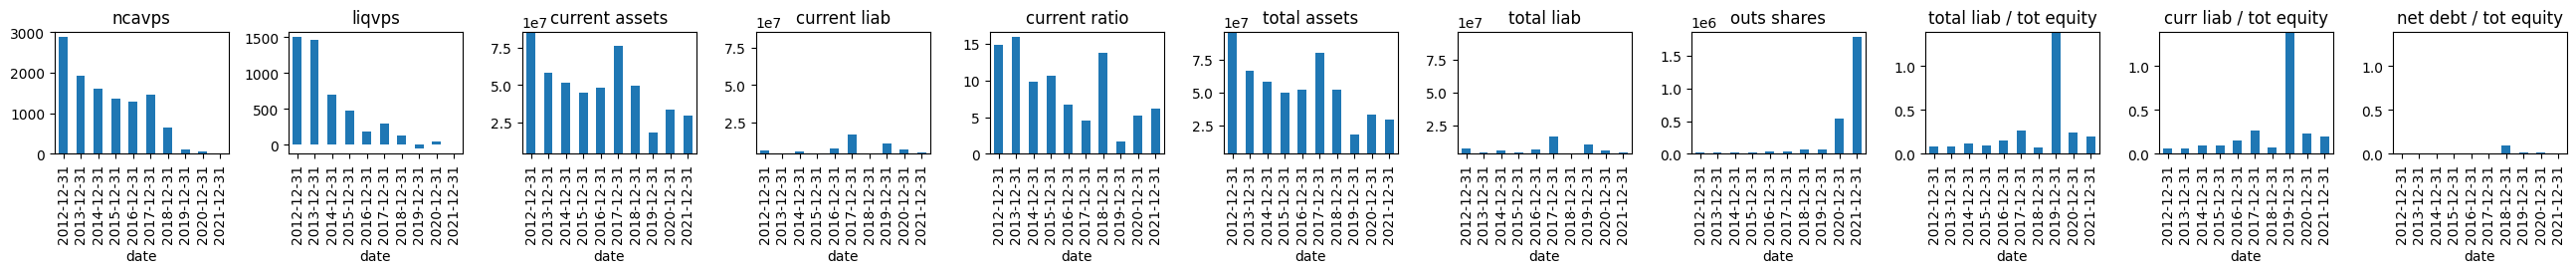

 17%|███████████████████▋                                                                                                   | 90/543 [03:18<14:55,  1.98s/it]

BEATW.	 Current price: 0.3987.	 NCAV: 0.9214816083811997.	 LIQV: 1.1447829334935193


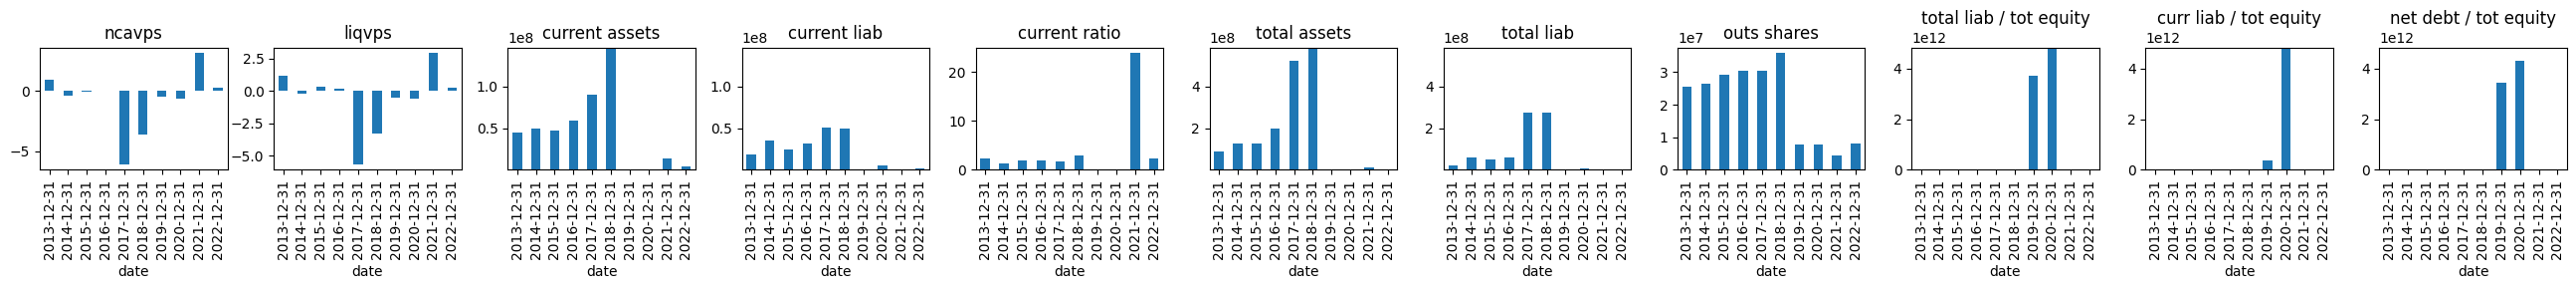

 17%|███████████████████▉                                                                                                   | 91/543 [03:22<20:24,  2.71s/it]

BECVY.	 Current price: 2.11.	 NCAV: 22.74518832.	 LIQV: 8.5213467236


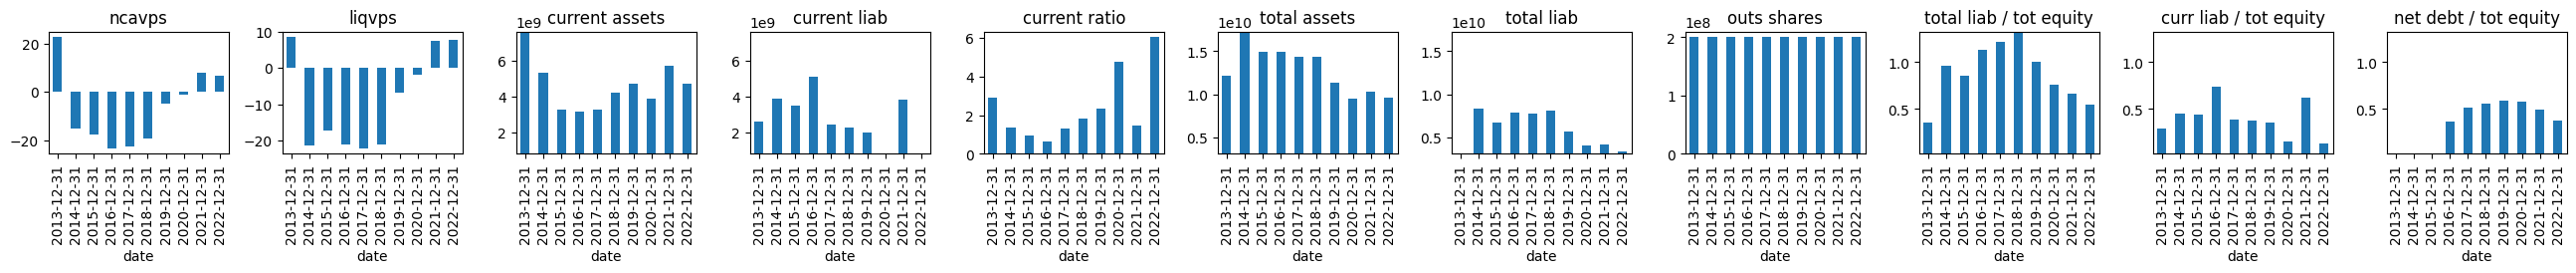

 17%|████████████████████▌                                                                                                  | 94/543 [03:30<16:44,  2.24s/it]

BGUUF.	 Current price: 0.065.	 NCAV: -3.236677061639998.	 LIQV: 0.32704820924284184


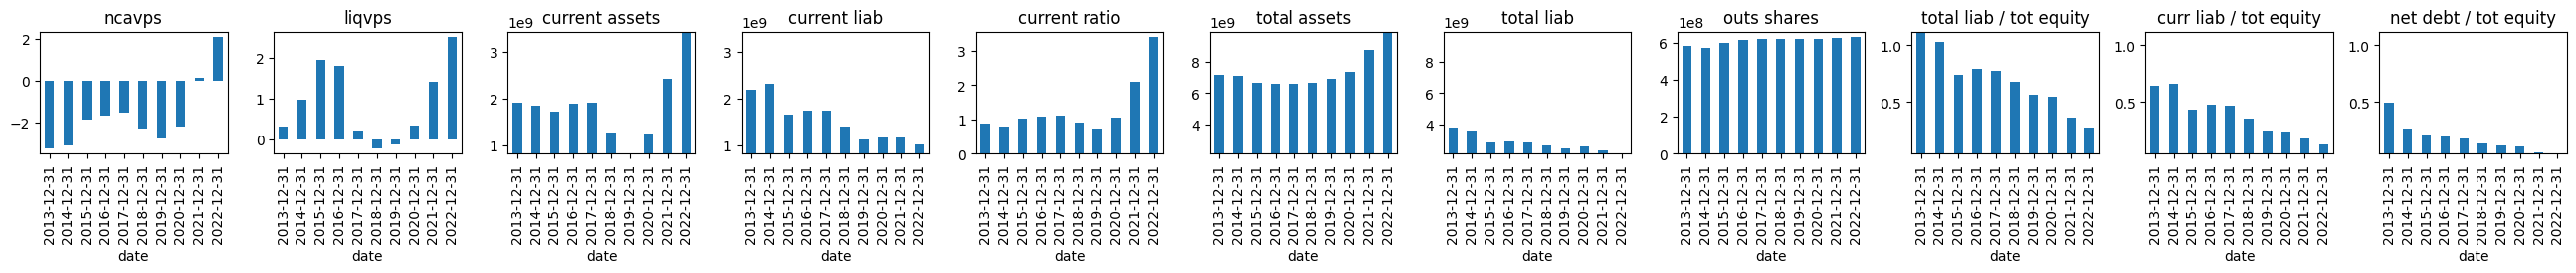

 19%|██████████████████████▌                                                                                               | 104/543 [03:49<14:33,  1.99s/it]

BKKLY.	 Current price: 24.75.	 NCAV: 1531.2335089894768.	 LIQV: 537.384960942309


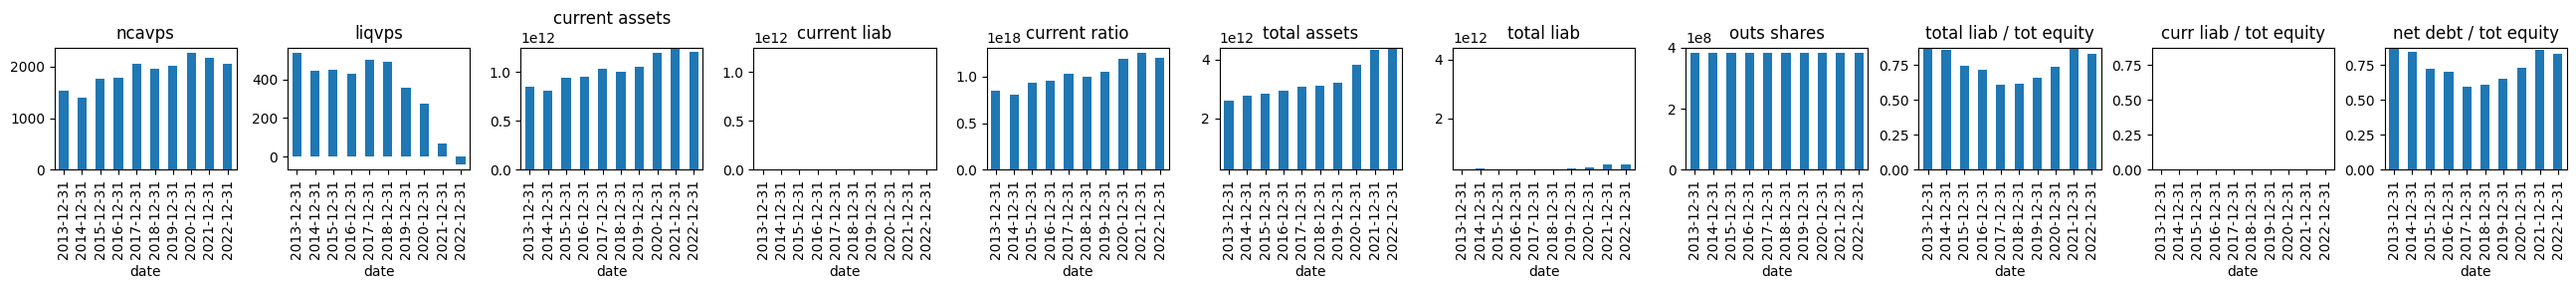

 19%|██████████████████████▊                                                                                               | 105/543 [03:54<20:51,  2.86s/it]

BKKPF.	 Current price: 3.92.	 NCAV: 306.24670179789535.	 LIQV: 107.47699218846181


 20%|███████████████████████▋                                                                                              | 109/543 [04:04<16:02,  2.22s/it]

BLRZF.	 Current price: 0.0004.	 NCAV: 2.8948024544966793.	 LIQV: 3.1558042602018963


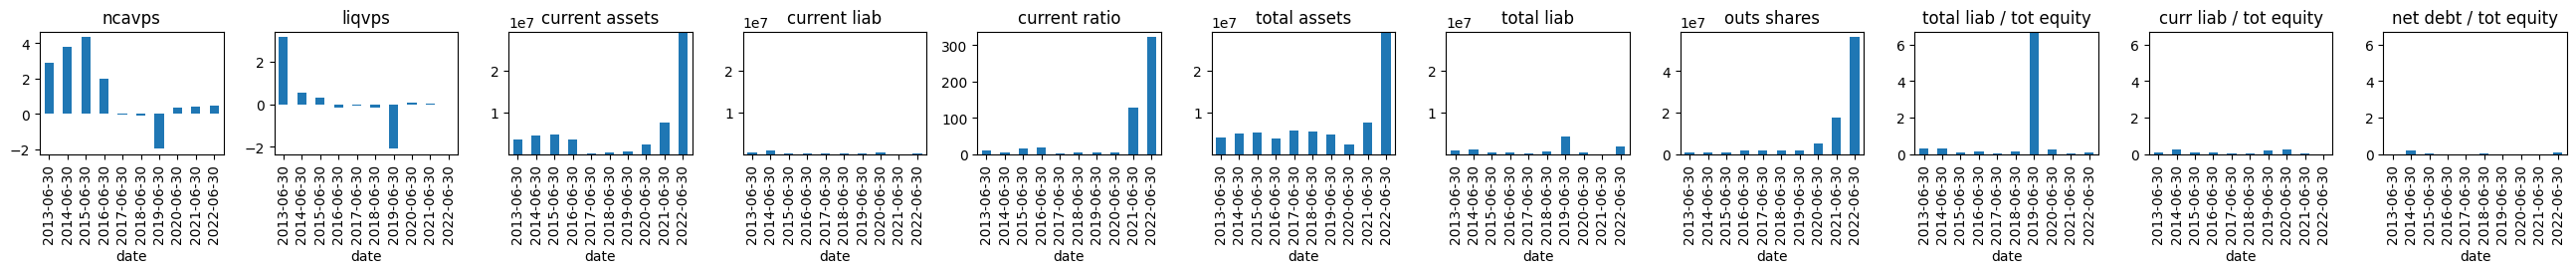

 20%|███████████████████████▉                                                                                              | 110/543 [04:08<21:14,  2.94s/it]

BMA.	 Current price: 26.13.	 NCAV: 74.31096725150141.	 LIQV: -69.866202018138


 20%|████████████████████████                                                                                              | 111/543 [04:13<24:21,  3.38s/it]

BMIX.	 Current price: 0.0115.	 NCAV: 0.7156826879783881.	 LIQV: 2.2135016602881583


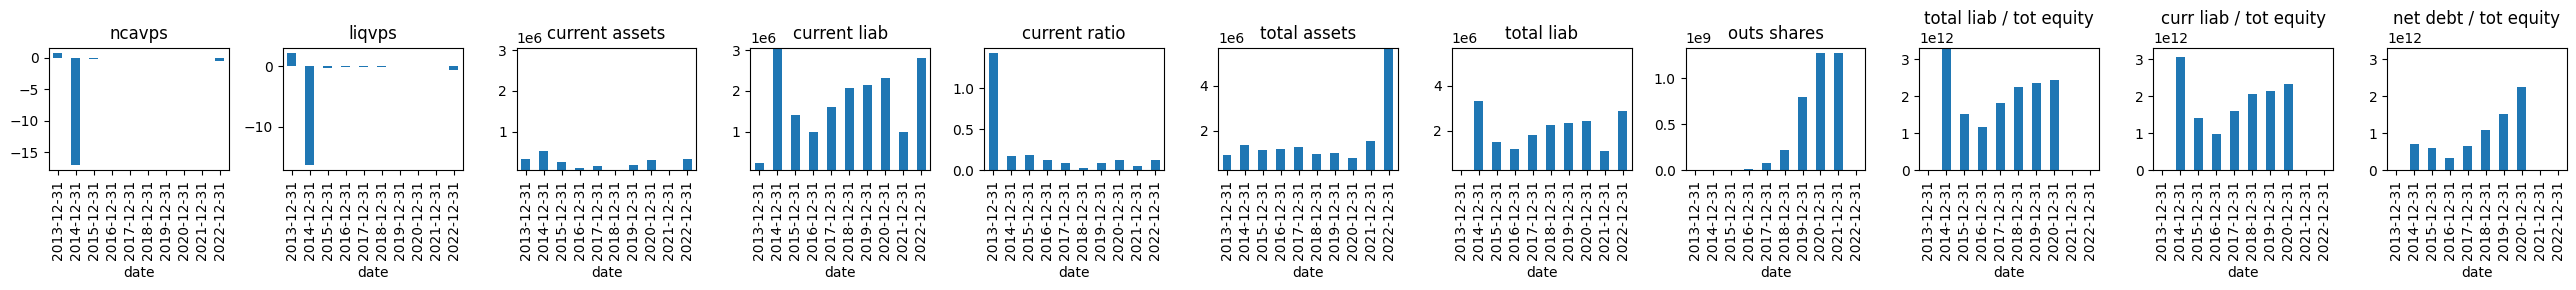

 22%|█████████████████████████▋                                                                                            | 118/543 [04:26<13:08,  1.86s/it]

BNTC.	 Current price: 3.27.	 NCAV: 1243.6108127278367.	 LIQV: 1179.4349303468007


 22%|█████████████████████████▊                                                                                            | 119/543 [04:31<18:44,  2.65s/it]

BOFKF.	 Current price: 43.5.	 NCAV: 246.8501342278642.	 LIQV: 398.8778763243002


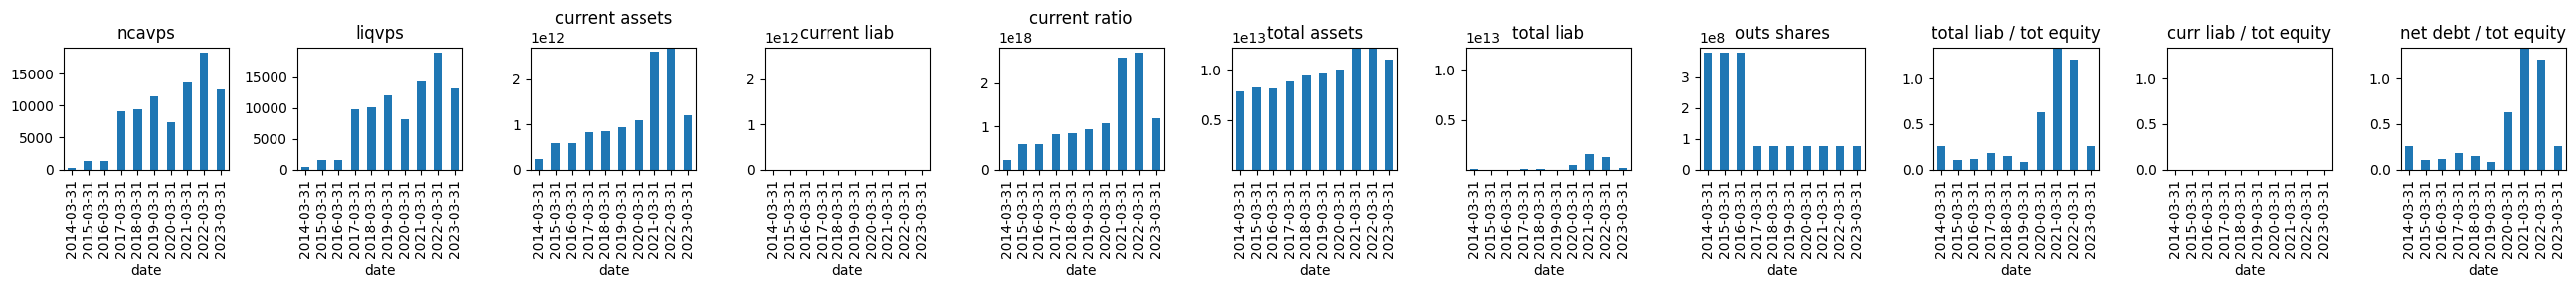

 22%|██████████████████████████                                                                                            | 120/543 [04:36<23:14,  3.30s/it]

BOMXF.	 Current price: 1.99.	 NCAV: 3.3322725829162256.	 LIQV: 2.367952053964225


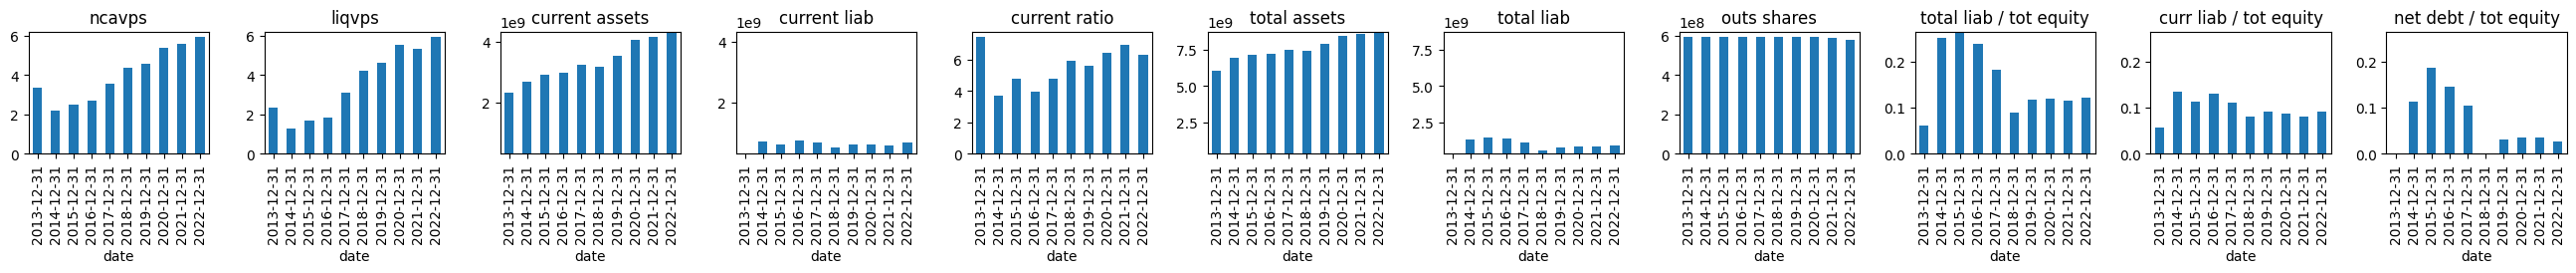

 23%|██████████████████████████▋                                                                                           | 123/543 [04:44<19:38,  2.81s/it]

BRDCF.	 Current price: 39.42.	 NCAV: 4.211918704834565.	 LIQV: 389.2871923717005


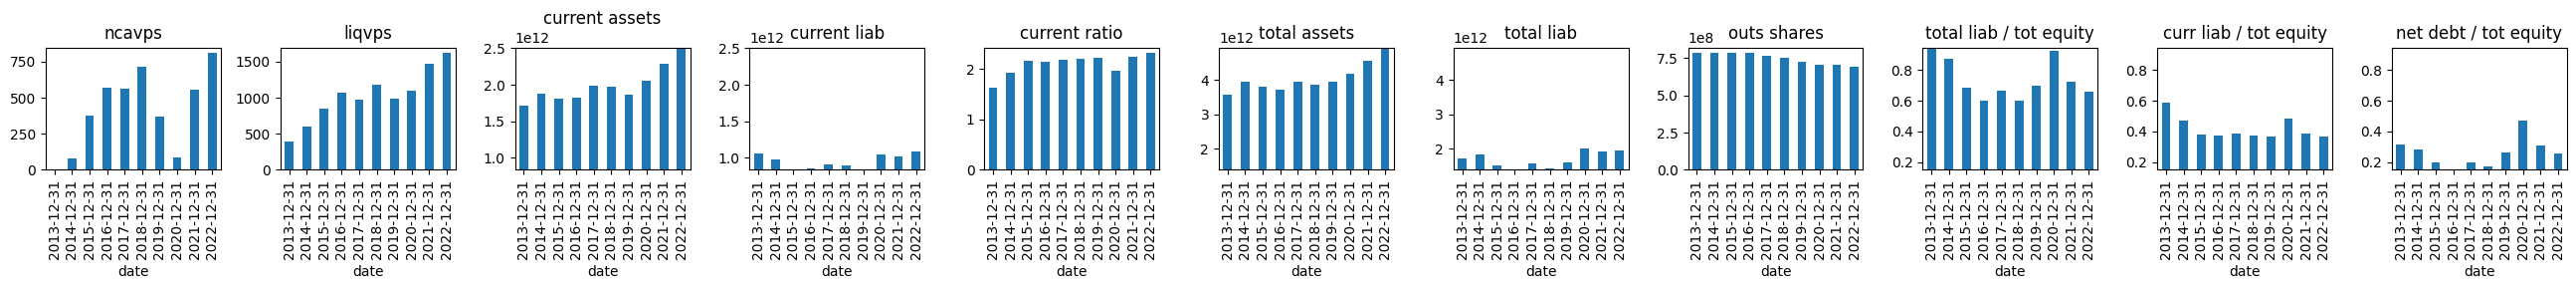

 23%|██████████████████████████▉                                                                                           | 124/543 [04:49<23:03,  3.30s/it]

BRDCY.	 Current price: 20.35.	 NCAV: 2.1059593524172824.	 LIQV: 194.64359618585024


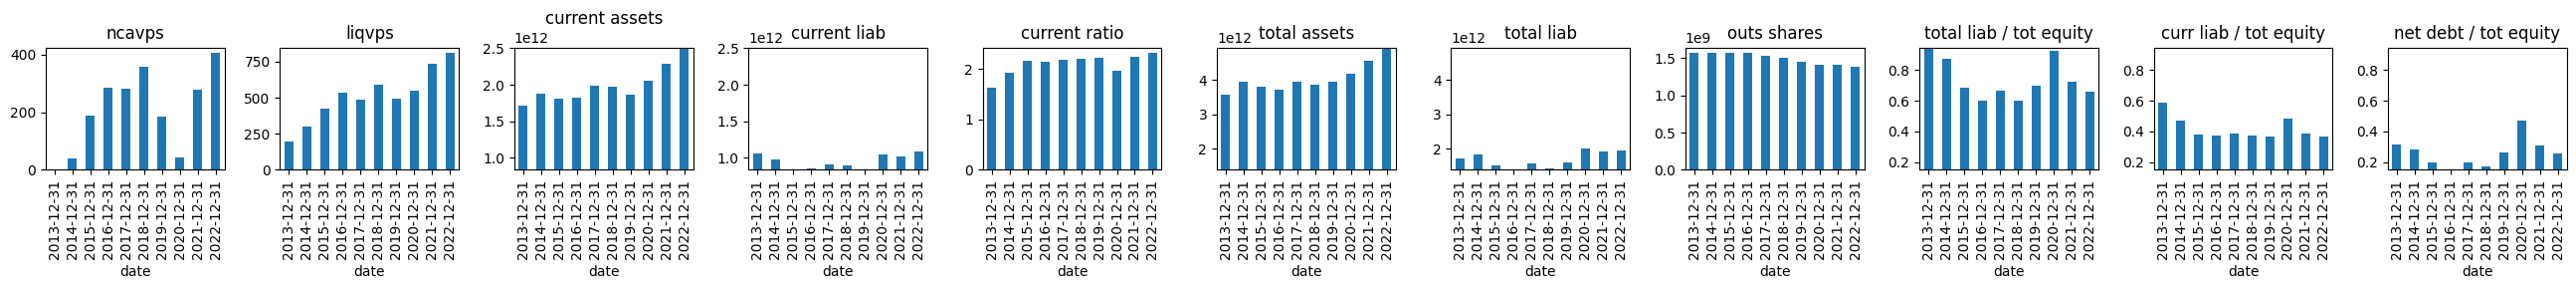

 24%|████████████████████████████▋                                                                                         | 132/543 [04:59<06:45,  1.01it/s]

BRQS.	 Current price: 0.43.	 NCAV: 2.1437326291314758.	 LIQV: 1.4748897118264337


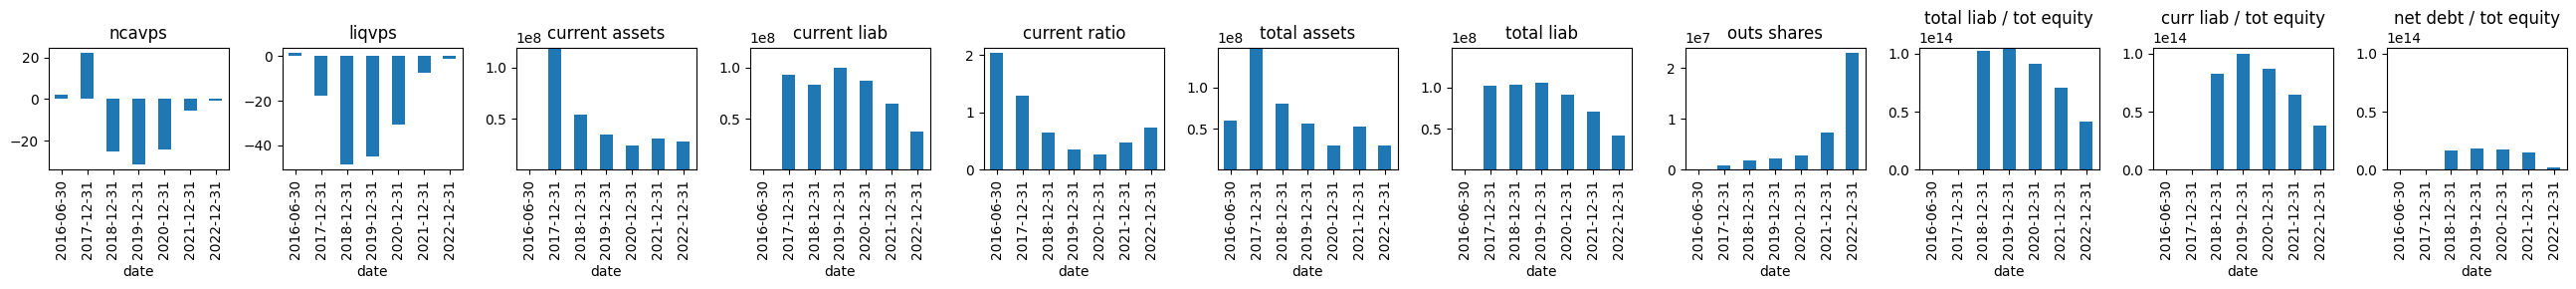

 24%|████████████████████████████▉                                                                                         | 133/543 [05:04<14:30,  2.12s/it]

BRTHY.	 Current price: 32.34.	 NCAV: 964.2017917550282.	 LIQV: 900.1541739071595


 25%|█████████████████████████████▎                                                                                        | 135/543 [05:11<18:28,  2.72s/it]

BRYFF.	 Current price: 0.18.	 NCAV: 1.849184736690376.	 LIQV: -3.029254028457948


 25%|█████████████████████████████▊                                                                                        | 137/543 [05:18<19:40,  2.91s/it]

BSPDY.	 Current price: 22.	 NCAV: 30574.43436555277.	 LIQV: -2230.994965649919


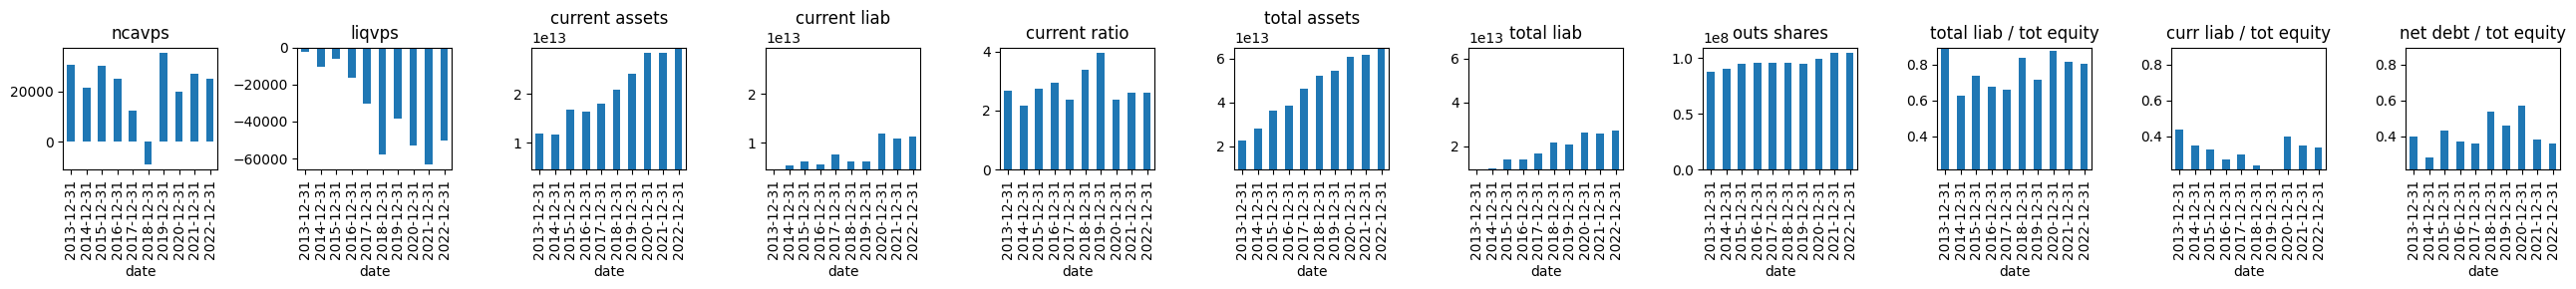

 27%|███████████████████████████████▎                                                                                      | 144/543 [05:32<12:49,  1.93s/it]

BUHPF.	 Current price: 6.06.	 NCAV: -0.11843064277191426.	 LIQV: 6.369552670405747


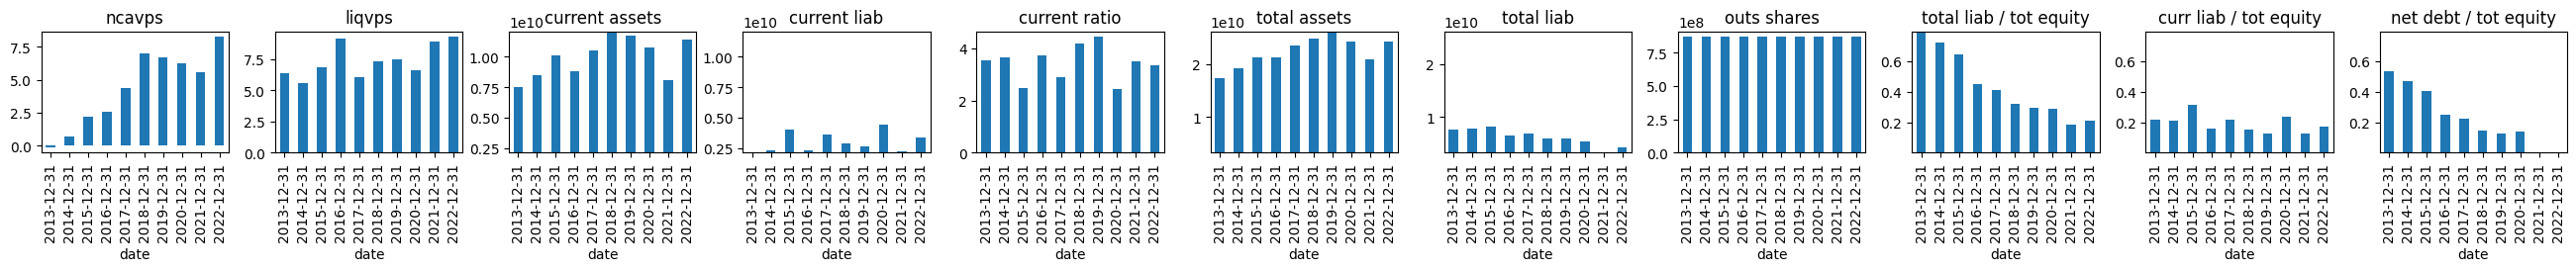

 28%|████████████████████████████████▊                                                                                     | 151/543 [05:47<12:40,  1.94s/it]

dates of last income statement and balance sheet are not the same for ticker BYM
	income stmt date: 2011-02-28, balance sheet date: 2015-08-31


 28%|█████████████████████████████████▏                                                                                    | 153/543 [05:51<12:47,  1.97s/it]

dates of last income statement and balance sheet are not the same for ticker BYYLF
	income stmt date: 2015-12-31, balance sheet date: 2014-12-31


 29%|█████████████████████████████████▉                                                                                    | 156/543 [05:57<13:23,  2.08s/it]

CAJ.	 Current price: 21.63.	 NCAV: 966.9553940411854.	 LIQV: 1122.8627944776817


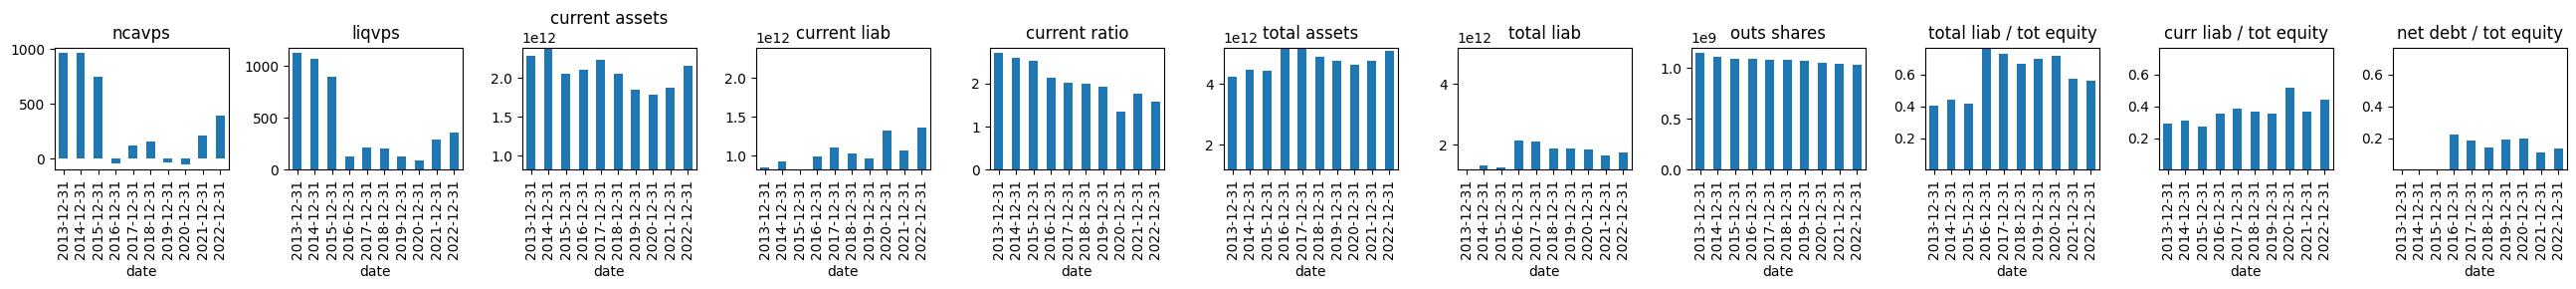

 29%|██████████████████████████████████                                                                                    | 157/543 [06:02<18:42,  2.91s/it]

CAJFF.	 Current price: 25.15.	 NCAV: 966.9553940411854.	 LIQV: 1122.8627944776817


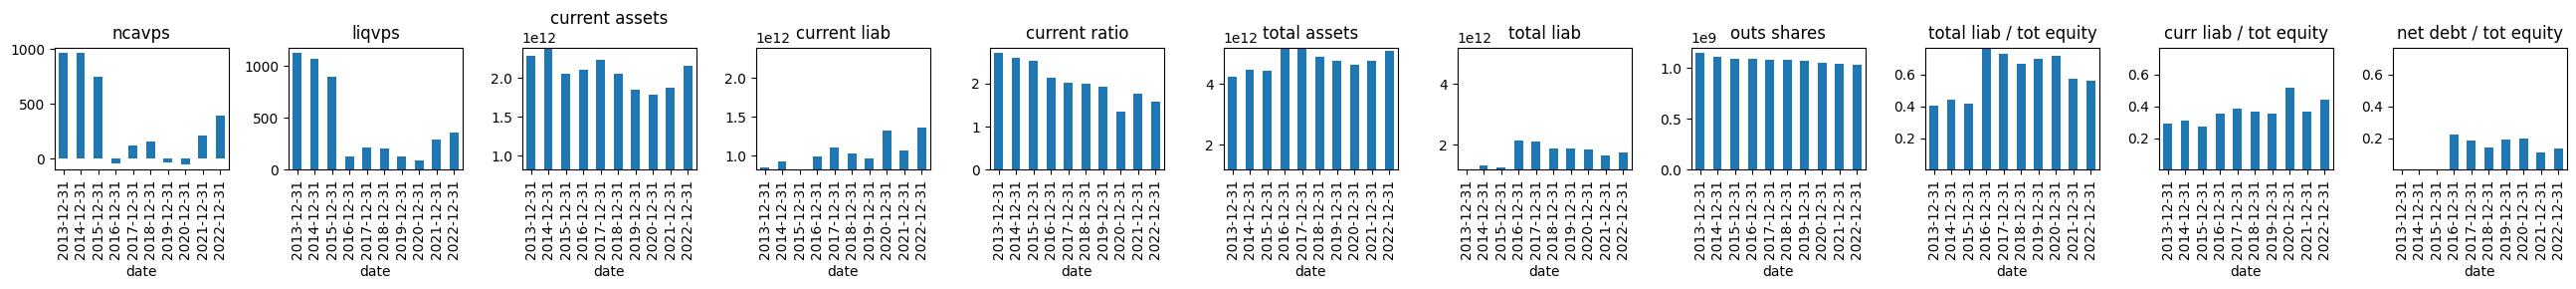

 29%|██████████████████████████████████▎                                                                                   | 158/543 [06:06<21:37,  3.37s/it]

CAJPY.	 Current price: 25.52.	 NCAV: 966.9553940411854.	 LIQV: 1122.8627944776817


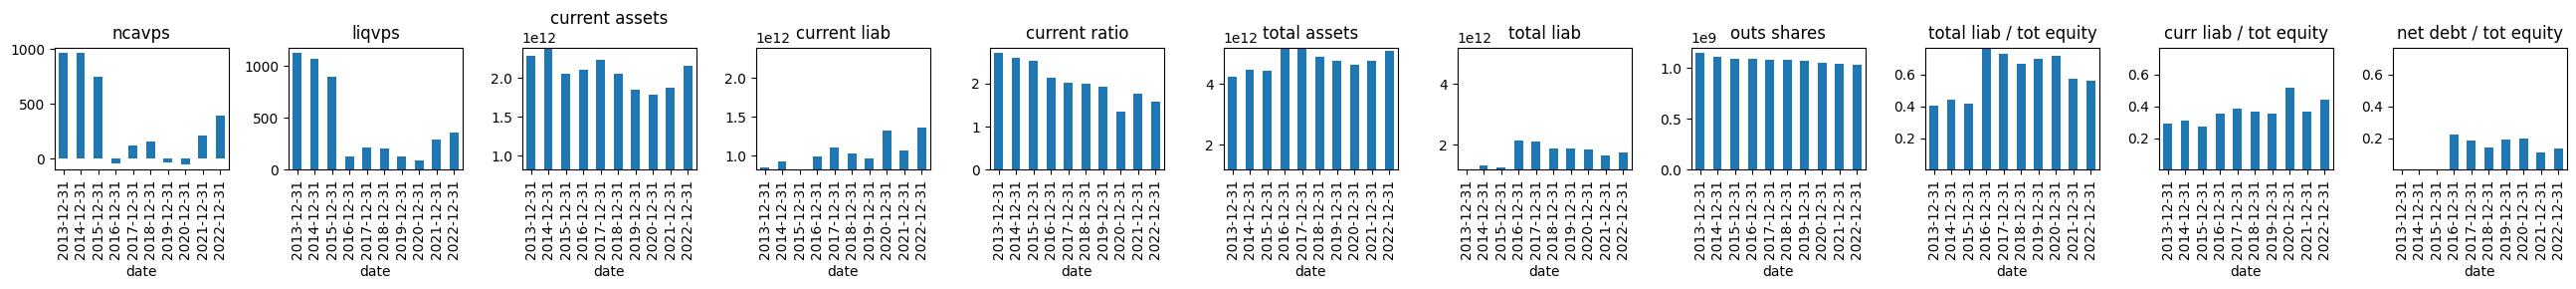

 30%|███████████████████████████████████▋                                                                                  | 164/543 [06:21<14:27,  2.29s/it]

CBSZF.	 Current price: 7.495.	 NCAV: 274.3235670752255.	 LIQV: 109.8686269790072


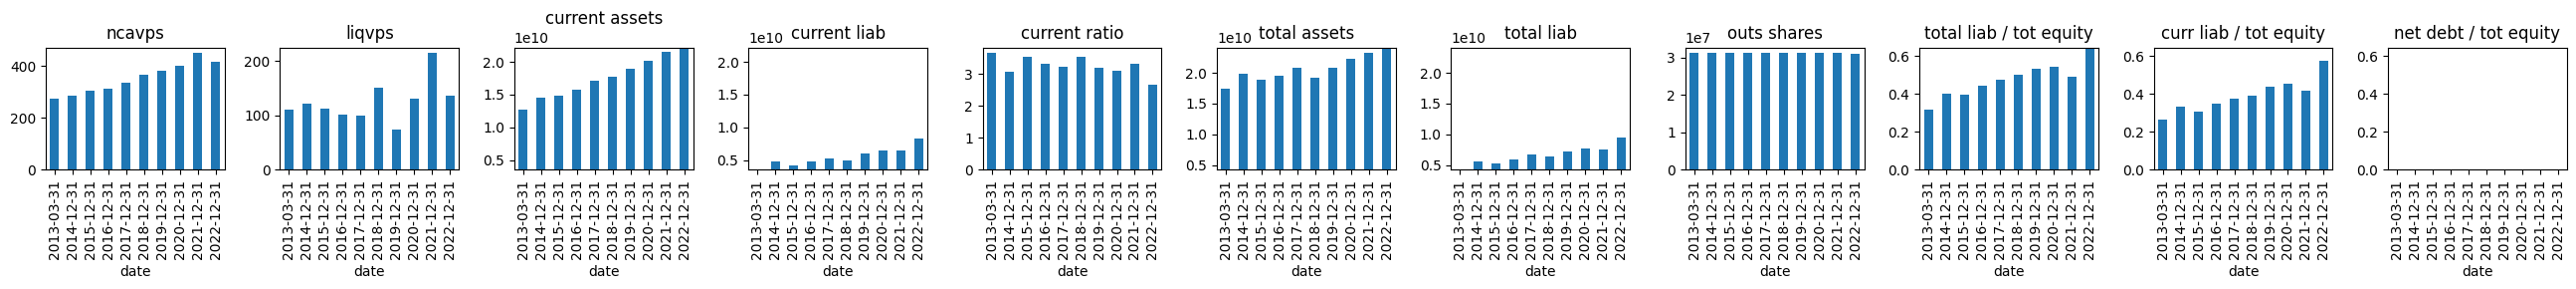

 31%|████████████████████████████████████                                                                                  | 166/543 [06:26<14:13,  2.27s/it]

CCOEY.	 Current price: 16.53.	 NCAV: 74.87760966351526.	 LIQV: 68.66982546073754


 32%|██████████████████████████████████████▏                                                                               | 176/543 [06:46<10:12,  1.67s/it]

CETXW.	 Current price: 0.0129.	 NCAV: 0.01983643726237584.	 LIQV: -0.0026090712259199925


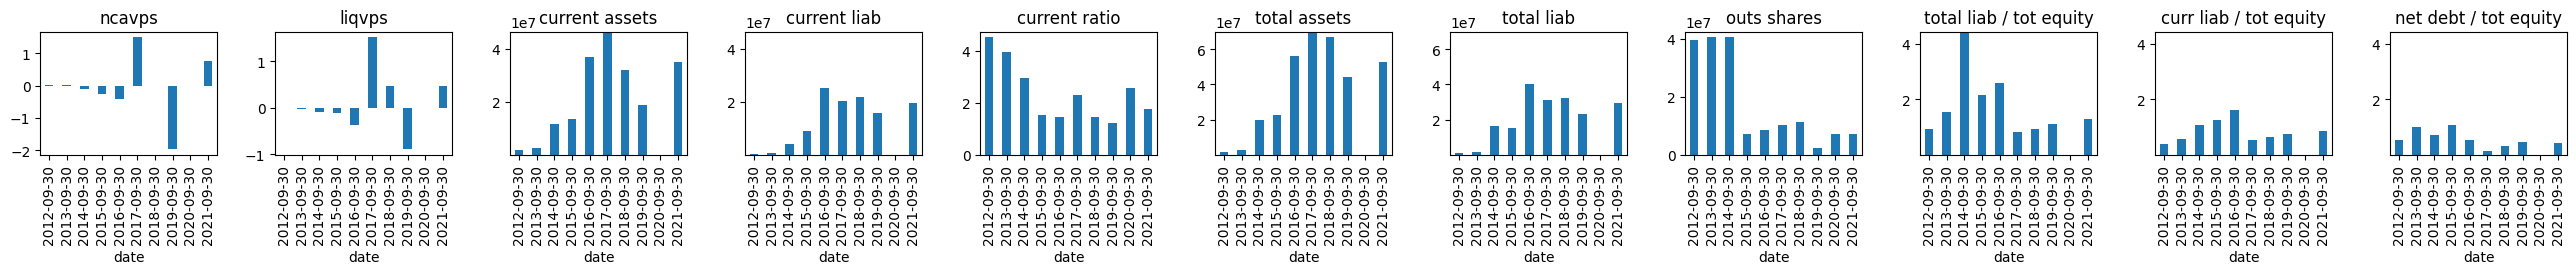

 33%|███████████████████████████████████████▎                                                                              | 181/543 [06:59<12:45,  2.11s/it]

CHBAF.	 Current price: 6.868.	 NCAV: 444.33145807632826.	 LIQV: 516.1029093929064


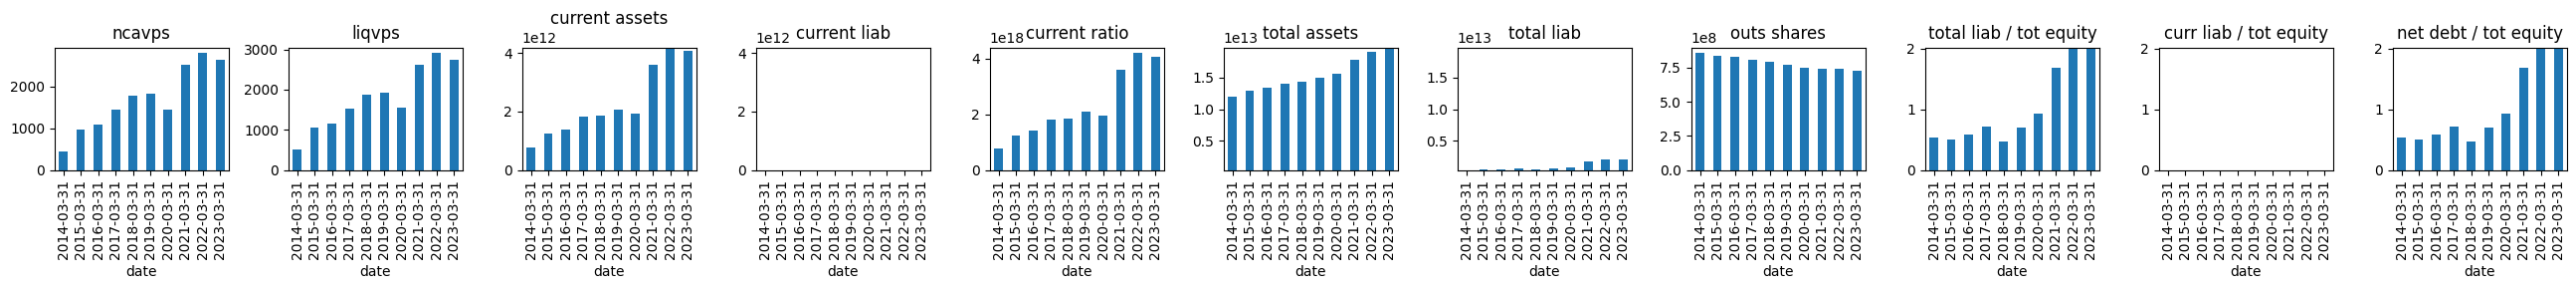

 34%|███████████████████████████████████████▌                                                                              | 182/543 [07:03<16:48,  2.79s/it]

CHGCY.	 Current price: 18.6.	 NCAV: 116.23820330137725.	 LIQV: 81.00981364923169


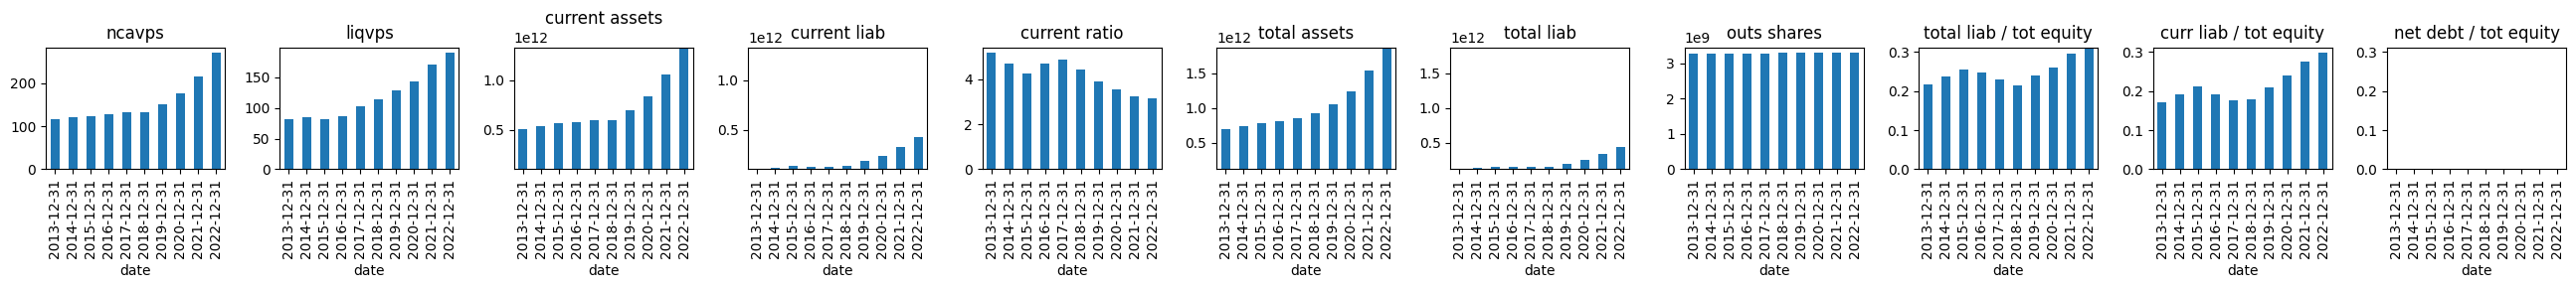

 34%|███████████████████████████████████████▉                                                                              | 184/543 [07:10<18:13,  3.05s/it]

CHNR.	 Current price: 1.4291.	 NCAV: 45.78211233989102.	 LIQV: -535.8979476153833


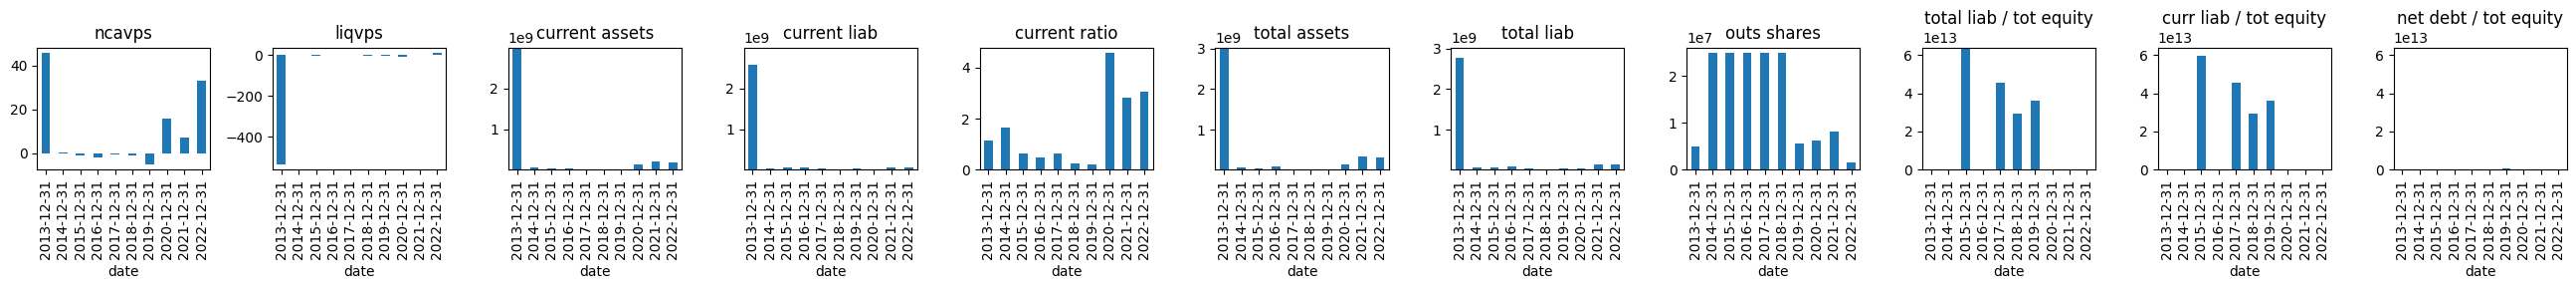

 35%|████████████████████████████████████████▊                                                                             | 188/543 [07:19<13:38,  2.31s/it]

dates of last income statement and balance sheet are not the same for ticker MBT
	income stmt date: 2012-12-31, balance sheet date: 2013-12-31


 37%|███████████████████████████████████████████▉                                                                          | 202/543 [07:40<08:40,  1.53s/it]

CMCM.	 Current price: 2.2055.	 NCAV: 19.764249102506337.	 LIQV: 16.391197596759707


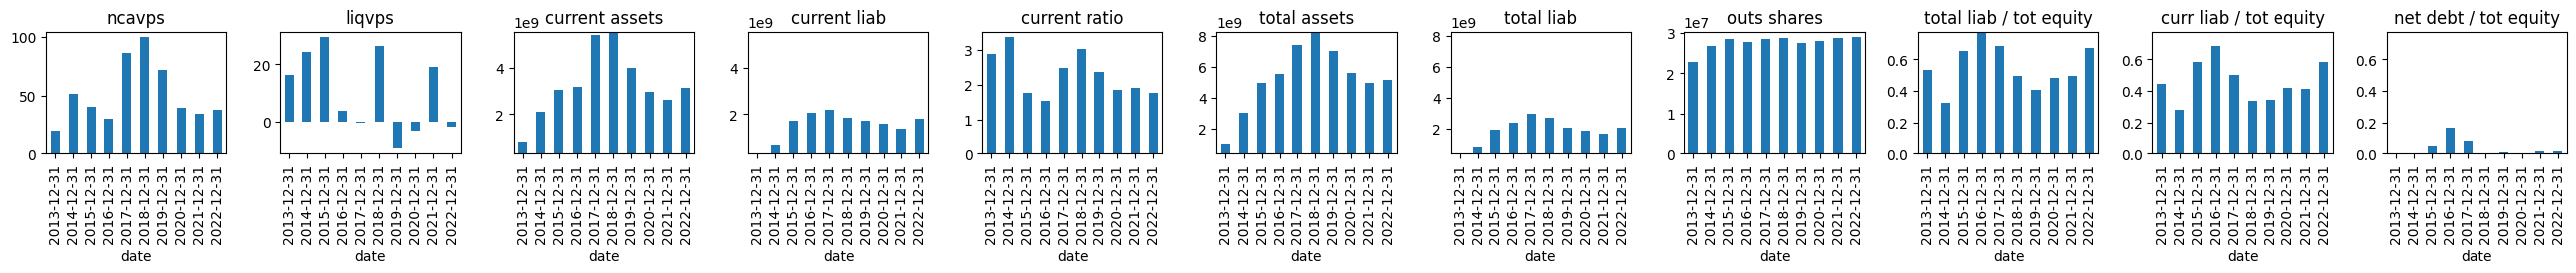

 37%|████████████████████████████████████████████                                                                          | 203/543 [07:45<13:36,  2.40s/it]

CMFO.	 Current price: 1e-06.	 NCAV: 0.0015152542054696987.	 LIQV: 0.0015638355832719305


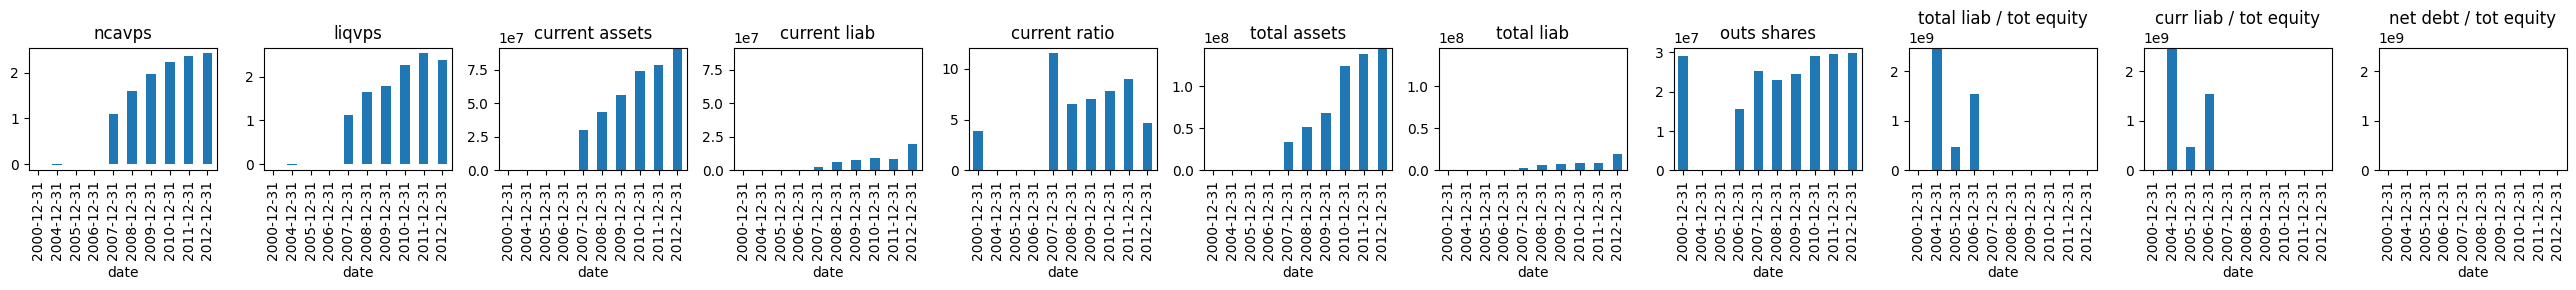

 38%|████████████████████████████████████████████▊                                                                         | 206/543 [07:54<14:53,  2.65s/it]

CMTDF.	 Current price: 18.66.	 NCAV: 710.9404092108691.	 LIQV: 907.1174215843217


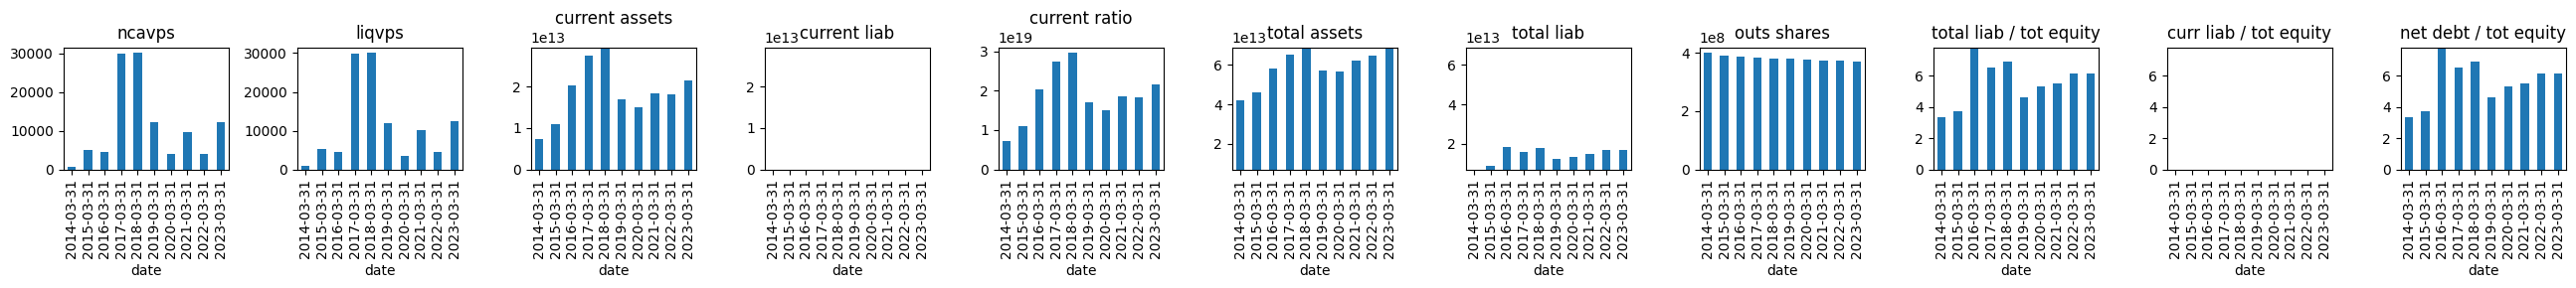

 38%|█████████████████████████████████████████████▏                                                                        | 208/543 [08:00<16:20,  2.93s/it]

CNAF.	 Current price: 10.45.	 NCAV: 61.644843518925335.	 LIQV: -2.6030766671105745


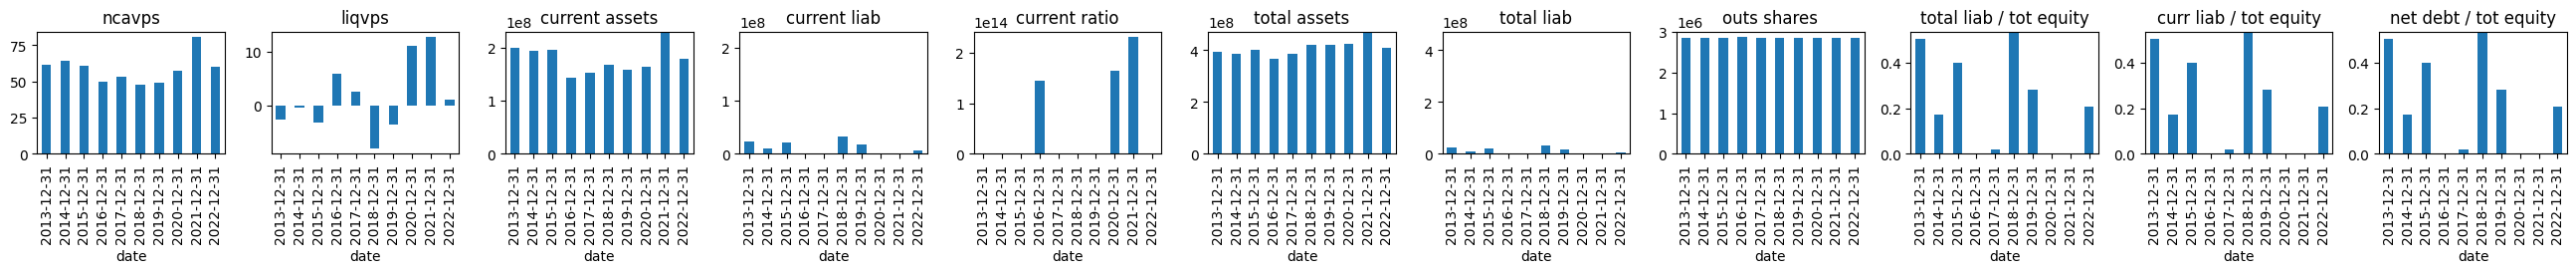

 39%|█████████████████████████████████████████████▋                                                                        | 210/543 [08:07<16:25,  2.96s/it]

dates of last income statement and balance sheet are not the same for ticker CNBA
	income stmt date: 1995-12-31, balance sheet date: 1996-12-31


 40%|██████████████████████████████████████████████▋                                                                       | 215/543 [08:14<08:33,  1.56s/it]

COSXF.	 Current price: 8.34.	 NCAV: 425.8031913950237.	 LIQV: 223.00251586206667


 40%|███████████████████████████████████████████████▎                                                                      | 218/543 [08:21<09:48,  1.81s/it]

CREAF.	 Current price: 1.12.	 NCAV: 1.867347372899383.	 LIQV: 1.5492652627100616


 42%|█████████████████████████████████████████████████▉                                                                    | 230/543 [08:44<09:20,  1.79s/it]

dates of last income statement and balance sheet are not the same for ticker CUII
	income stmt date: 2013-06-30, balance sheet date: 2013-12-31


 43%|██████████████████████████████████████████████████▋                                                                   | 233/543 [08:50<09:56,  1.92s/it]

dates of last income statement and balance sheet are not the same for ticker CXE
	income stmt date: 2010-11-30, balance sheet date: 2015-11-30


 43%|██████████████████████████████████████████████████▊                                                                   | 234/543 [08:52<10:01,  1.95s/it]

dates of last income statement and balance sheet are not the same for ticker CXH
	income stmt date: 2010-11-30, balance sheet date: 2017-11-30
CYAD.	 Current price: 0.47.	 NCAV: 1.7355928548288257.	 LIQV: 0.9929544332379653


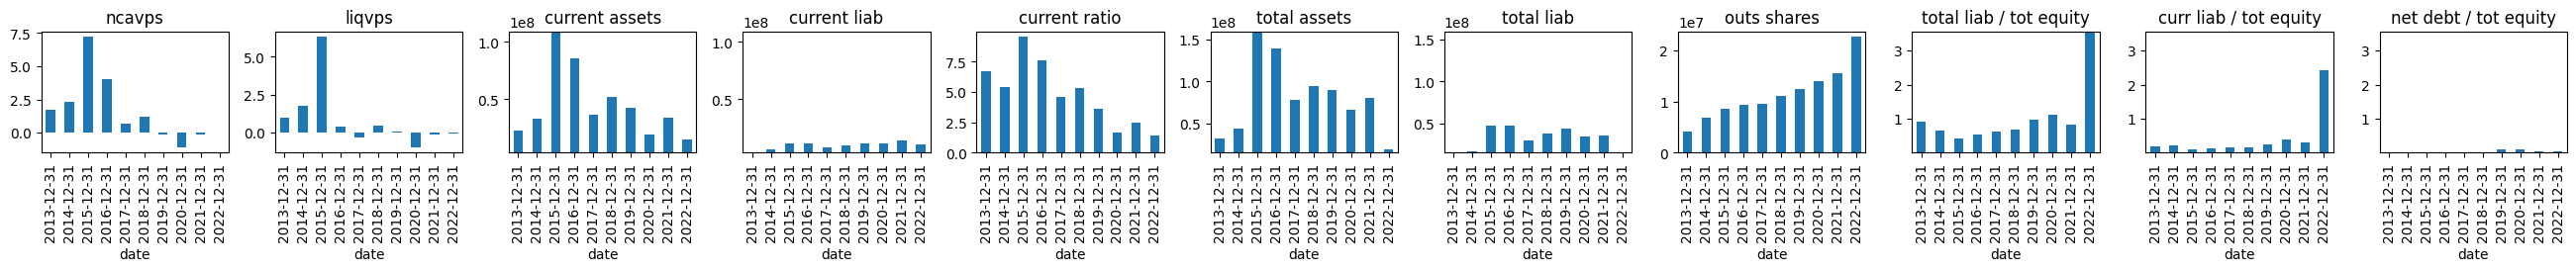

 43%|███████████████████████████████████████████████████▎                                                                  | 236/543 [08:59<12:41,  2.48s/it]

dates incoherence
CYBQY.	 Current price: 1.5.	 NCAV: 26.551546795229797.	 LIQV: 29.54126900999183


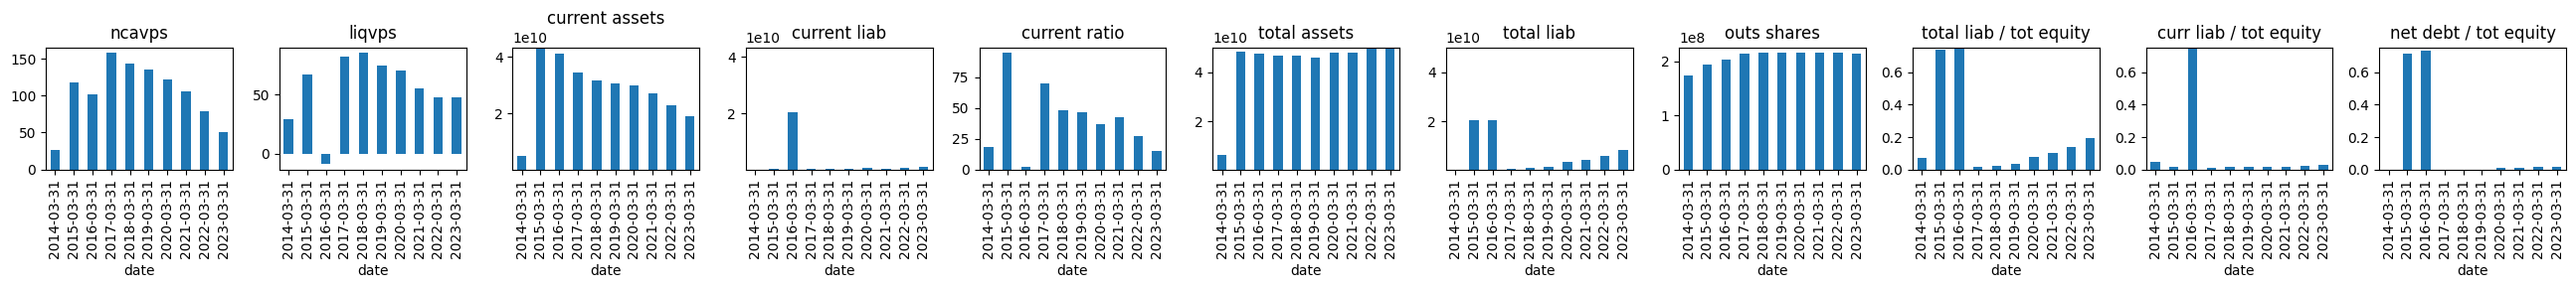

 44%|███████████████████████████████████████████████████▌                                                                  | 237/543 [09:03<15:37,  3.07s/it]

CYD.	 Current price: 8.2.	 NCAV: 73.69091705833095.	 LIQV: 61.855795504055216


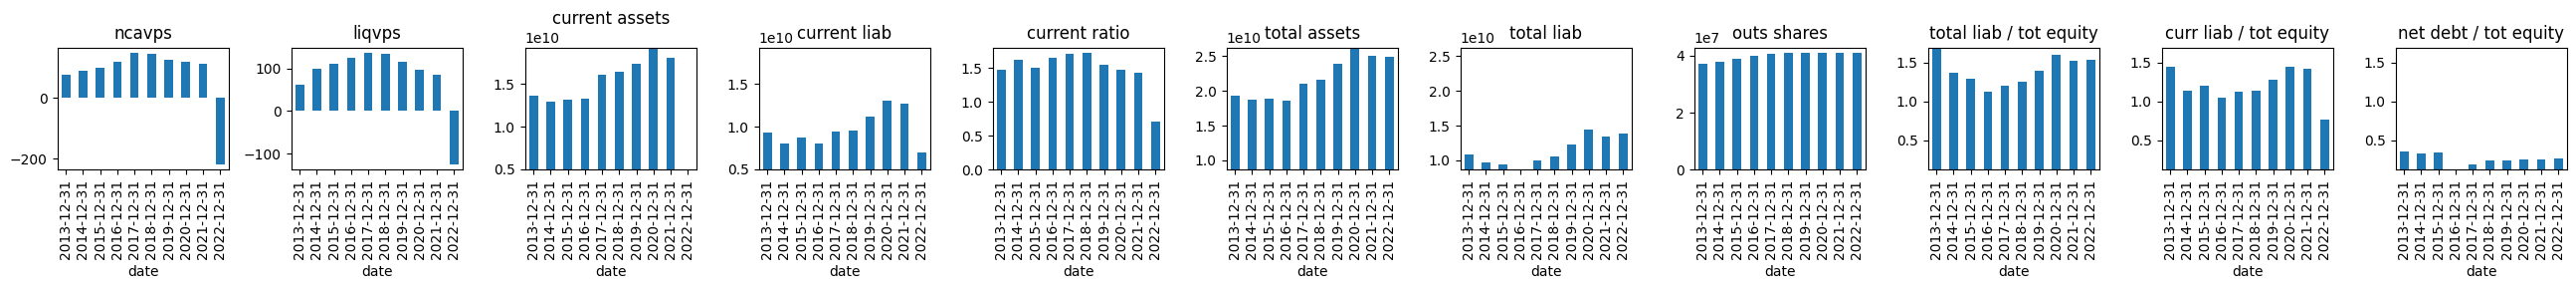

 44%|███████████████████████████████████████████████████▋                                                                  | 238/543 [09:08<18:04,  3.56s/it]

CYTR.	 Current price: 0.09.	 NCAV: 1.85796525533134.	 LIQV: -3.491054833955596


 44%|████████████████████████████████████████████████████▏                                                                 | 240/543 [09:13<14:29,  2.87s/it]

DAAT.	 Current price: 0.0001.	 NCAV: 0.031078457126298885.	 LIQV: 0.00676286447027311


 45%|████████████████████████████████████████████████████▌                                                                 | 242/543 [09:19<14:43,  2.94s/it]

DALQF.	 Current price: 0.1065.	 NCAV: 1.0817154666124045.	 LIQV: 1.0300779734670753


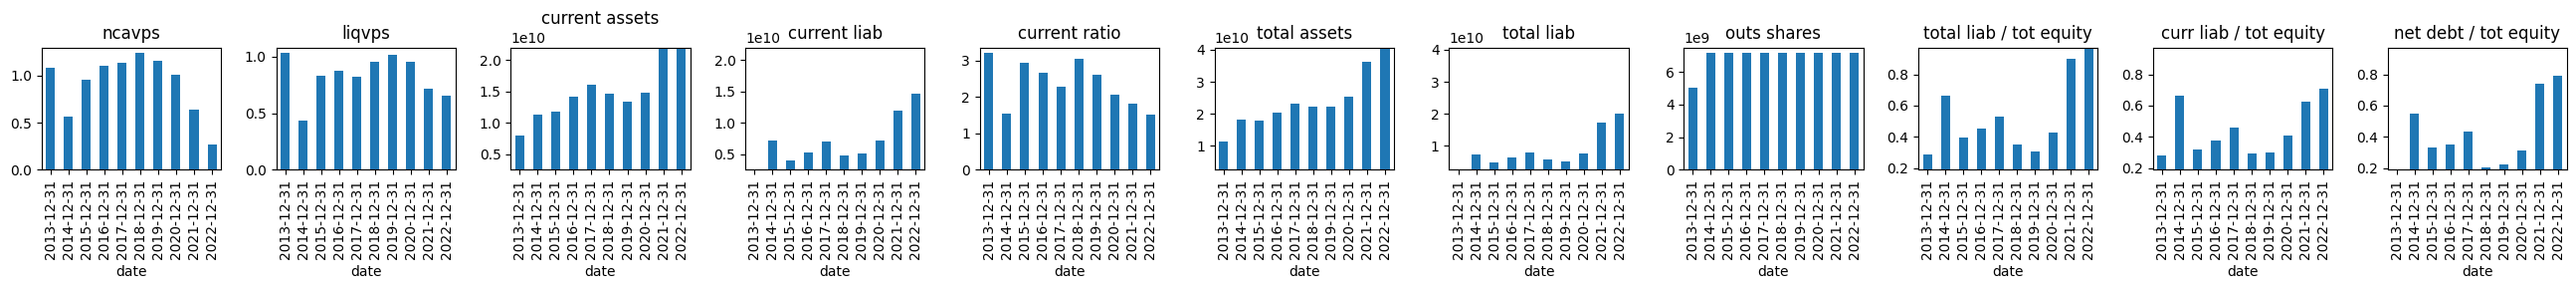

 46%|██████████████████████████████████████████████████████▊                                                               | 252/543 [09:41<09:51,  2.03s/it]

dates incoherence


 47%|██████████████████████████████████████████████████████▉                                                               | 253/543 [09:43<09:45,  2.02s/it]

DLGEF.	 Current price: 20.19.	 NCAV: 112.60345610297311.	 LIQV: -58.19291975272596


 47%|███████████████████████████████████████████████████████▏                                                              | 254/543 [09:47<13:15,  2.75s/it]

DLNDY.	 Current price: 2.7.	 NCAV: 27.042886718759572.	 LIQV: 25.751949387574847


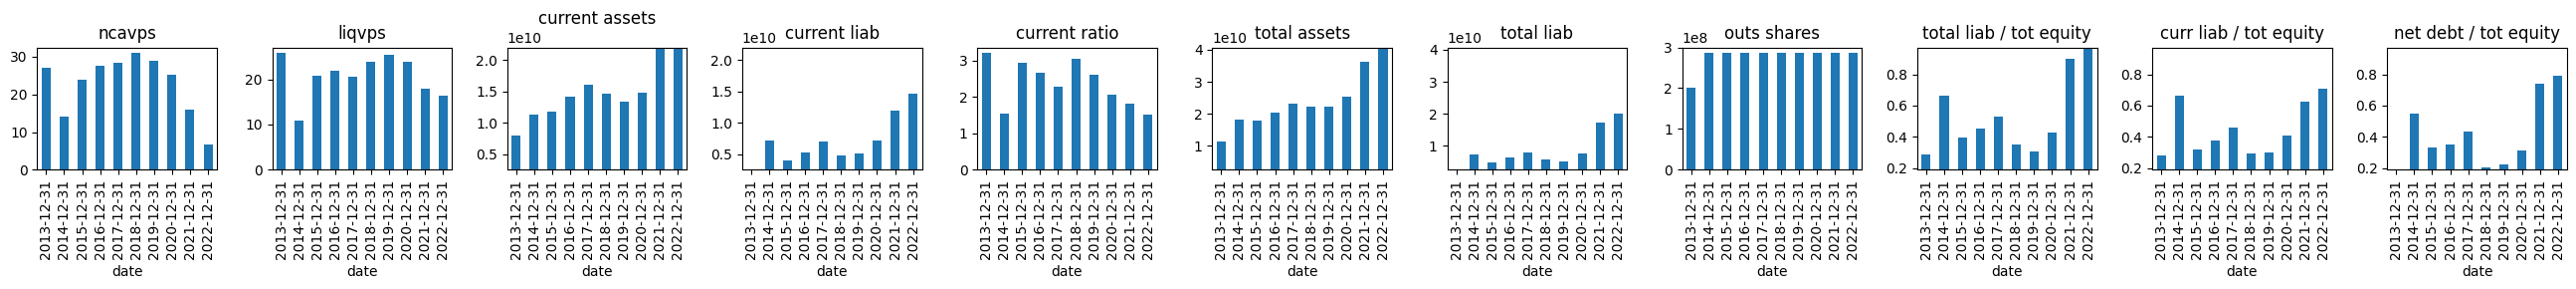

 47%|███████████████████████████████████████████████████████▋                                                              | 256/543 [09:54<14:05,  2.95s/it]

DMCD.	 Current price: 0.0001.	 NCAV: 2.7810475531897785.	 LIQV: 2.8082986475403247


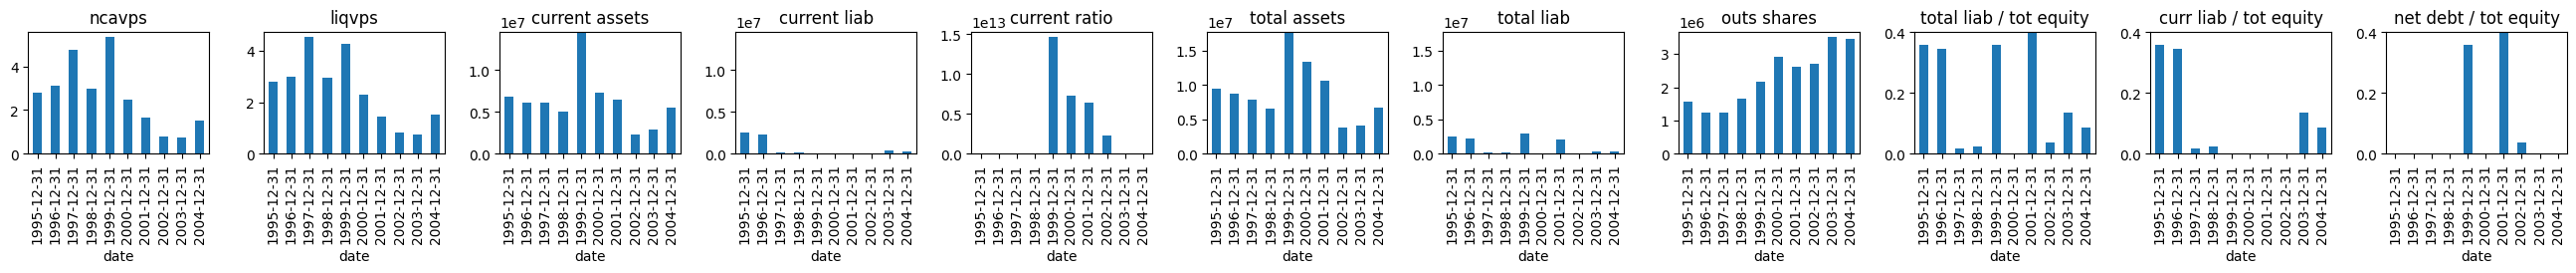

 47%|███████████████████████████████████████████████████████▊                                                              | 257/543 [09:58<16:07,  3.38s/it]

DMCHY.	 Current price: 1.56.	 NCAV: 5.752683304876607.	 LIQV: 10.332358596931494


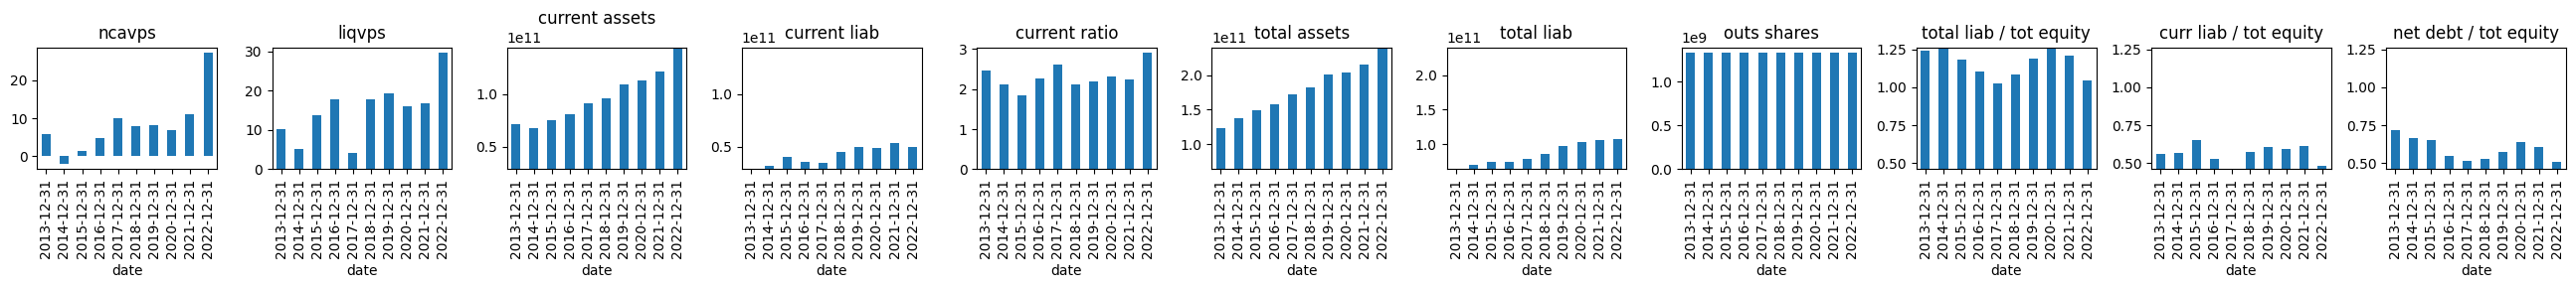

 48%|████████████████████████████████████████████████████████                                                              | 258/543 [10:03<17:58,  3.79s/it]

DNACF.	 Current price: 9.58.	 NCAV: 455.05242052707314.	 LIQV: 121.08212793942604


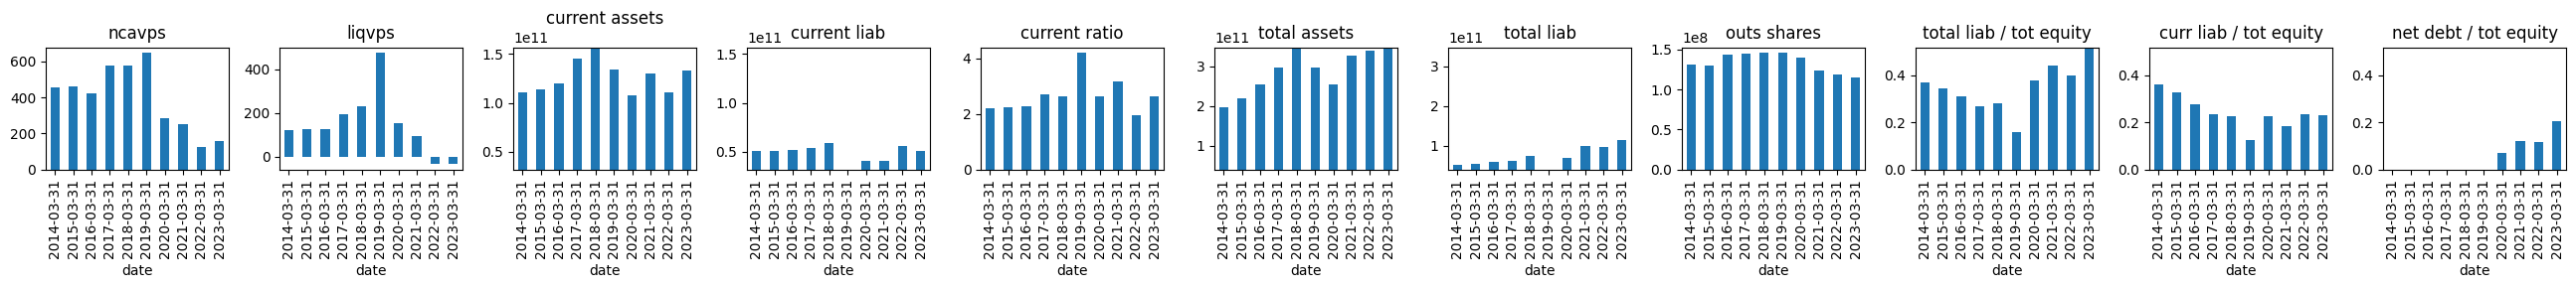

 48%|████████████████████████████████████████████████████████▋                                                             | 261/543 [10:12<15:05,  3.21s/it]

dates incoherence
DOMR.	 Current price: 1e-06.	 NCAV: 0.024216811457825723.	 LIQV: 2.9794310893886182


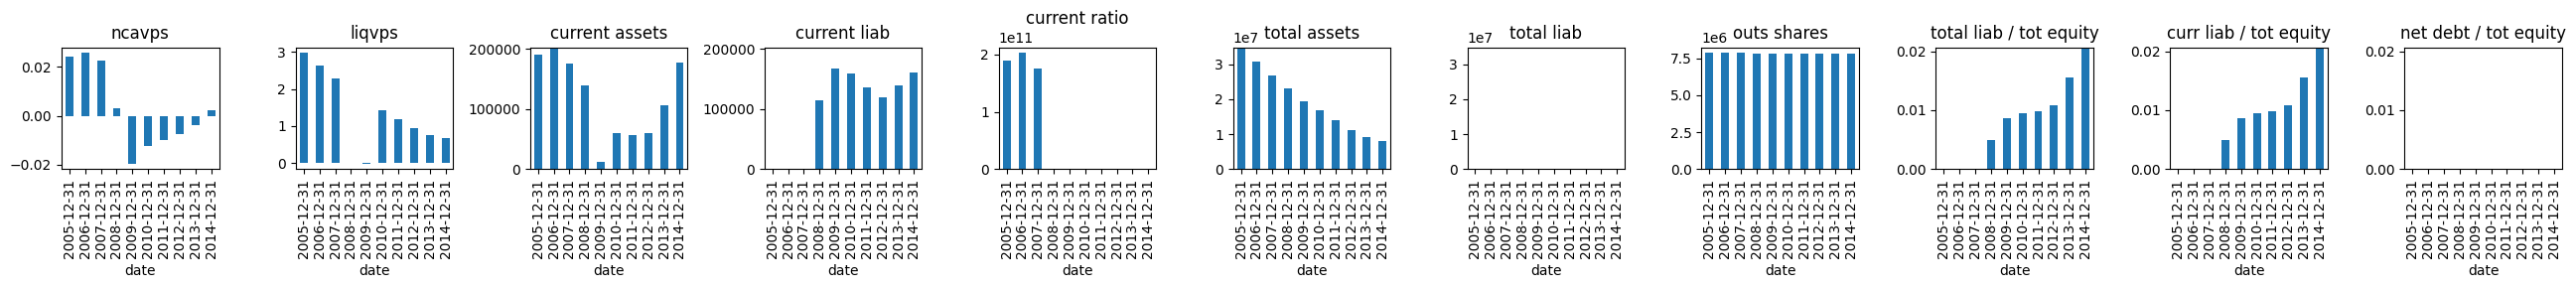

 50%|██████████████████████████████████████████████████████████▋                                                           | 270/543 [10:24<04:04,  1.12it/s]

DSKYF.	 Current price: 27.4.	 NCAV: 68.10087169569483.	 LIQV: -57.90335539511767


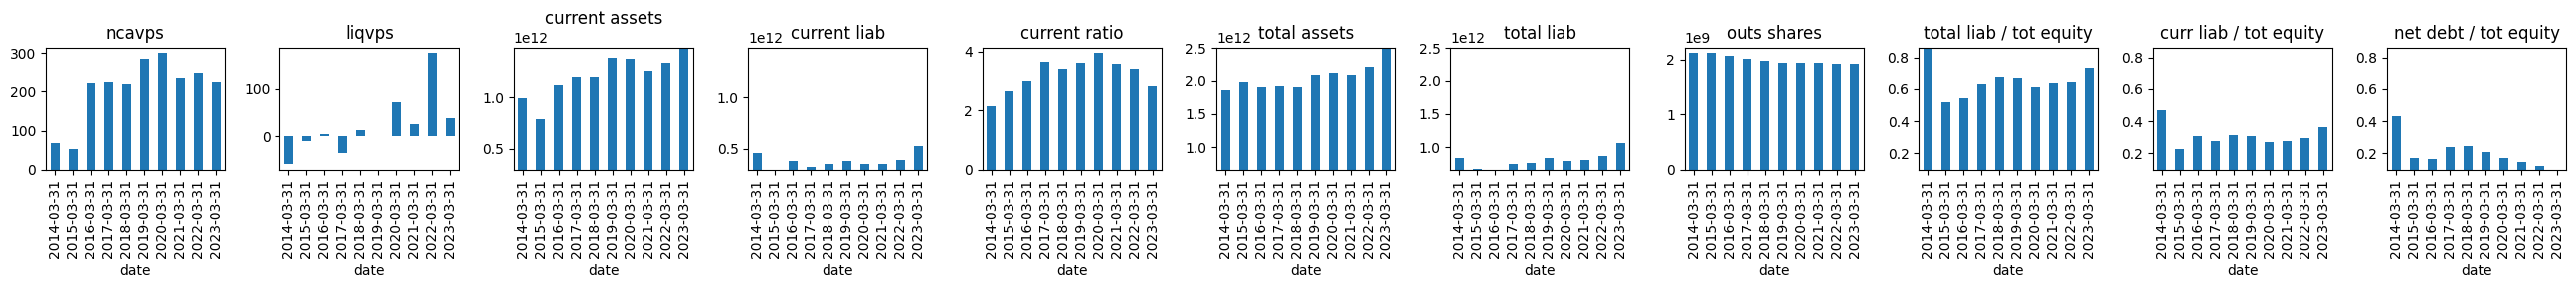

 50%|███████████████████████████████████████████████████████████                                                           | 272/543 [10:31<09:10,  2.03s/it]

DSNKY.	 Current price: 27.86.	 NCAV: 68.10087169569483.	 LIQV: -57.90335539511767


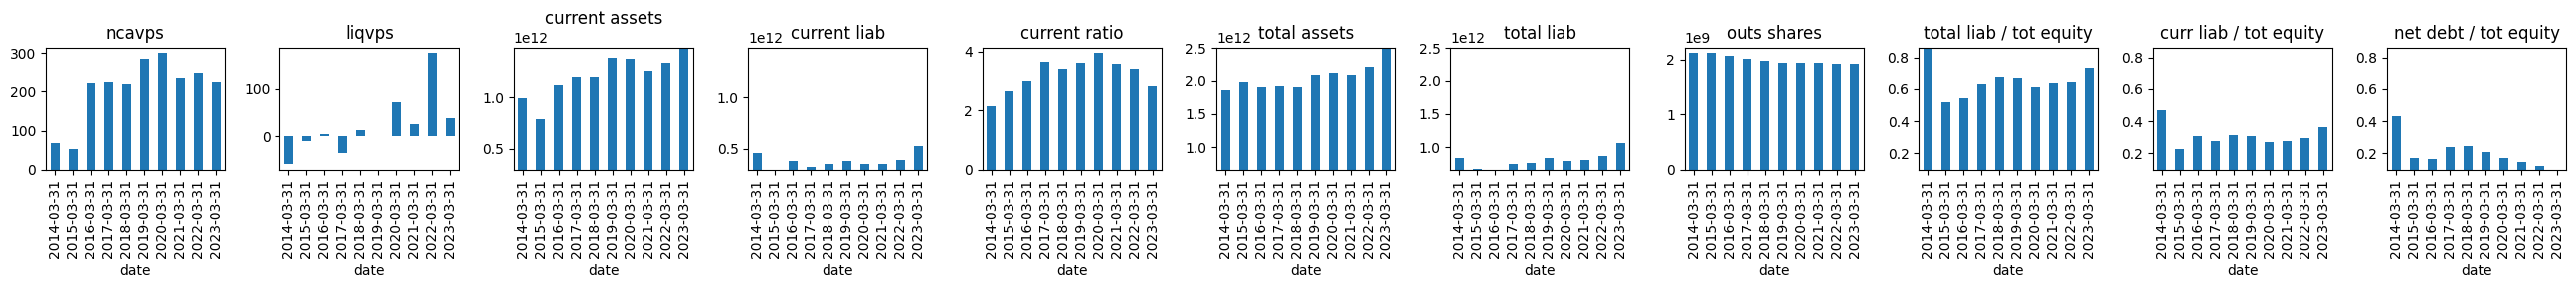

 51%|███████████████████████████████████████████████████████████▊                                                          | 275/543 [10:38<09:22,  2.10s/it]

dates of last income statement and balance sheet are not the same for ticker DTEA
	income stmt date: 2013-01-31, balance sheet date: 2014-01-31


 51%|███████████████████████████████████████████████████████████▉                                                          | 276/543 [10:40<09:12,  2.07s/it]

DXF.	 Current price: 0.373.	 NCAV: 3105.885204780675.	 LIQV: 2395.8352690710567


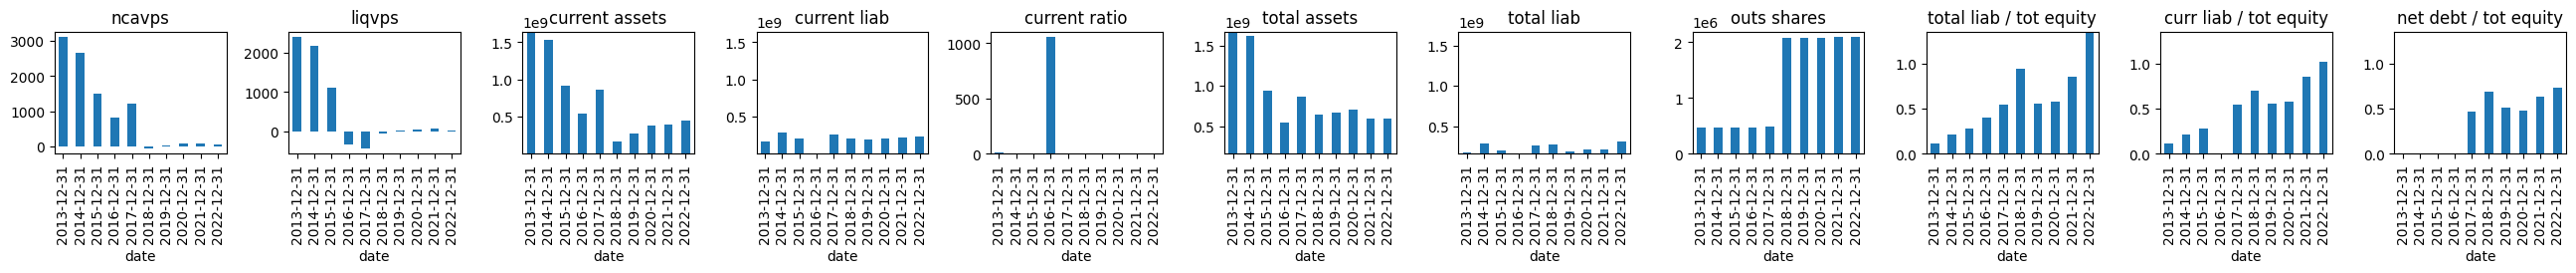

 52%|████████████████████████████████████████████████████████████▊                                                         | 280/543 [10:48<07:50,  1.79s/it]

dates of last income statement and balance sheet are not the same for ticker ECC
	income stmt date: 2017-12-31, balance sheet date: 2014-12-31


 53%|██████████████████████████████████████████████████████████████▏                                                       | 286/543 [10:59<07:17,  1.70s/it]

ELVT.	 Current price: 1.87.	 NCAV: 1.875019208834597.	 LIQV: 1.4970459075957623


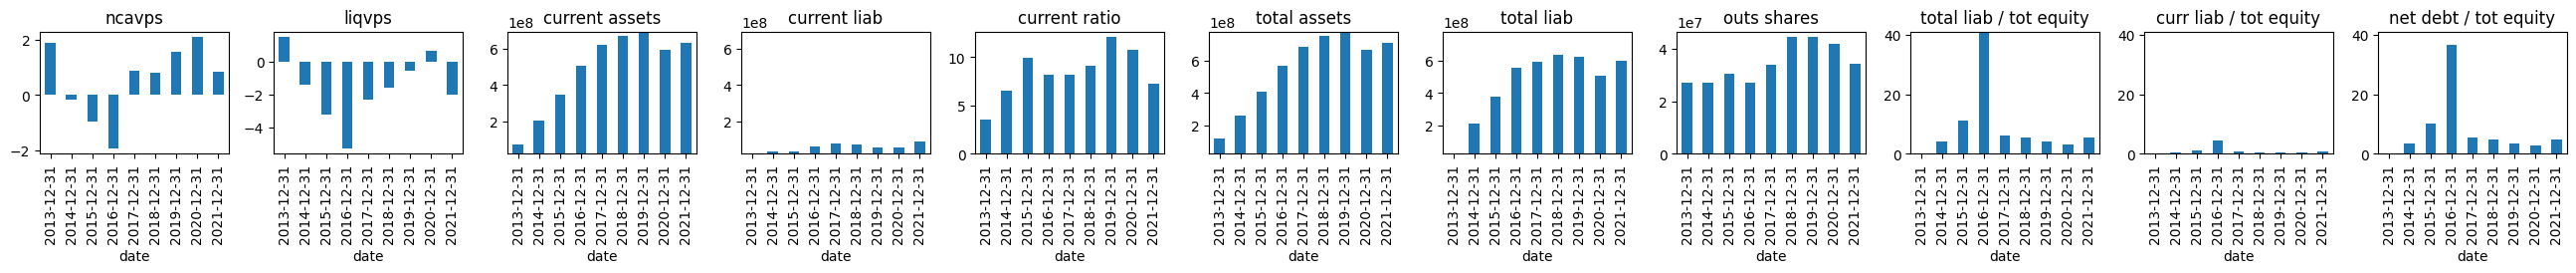

 54%|████████████████████████████████████████████████████████████████                                                      | 295/543 [11:15<07:48,  1.89s/it]

dates of last income statement and balance sheet are not the same for ticker EOT
	income stmt date: 2010-12-31, balance sheet date: 2015-03-31


 55%|█████████████████████████████████████████████████████████████████▍                                                    | 301/543 [11:24<06:56,  1.72s/it]

EVK.	 Current price: 0.2944.	 NCAV: 0.7508261692272761.	 LIQV: -1.00345980054652


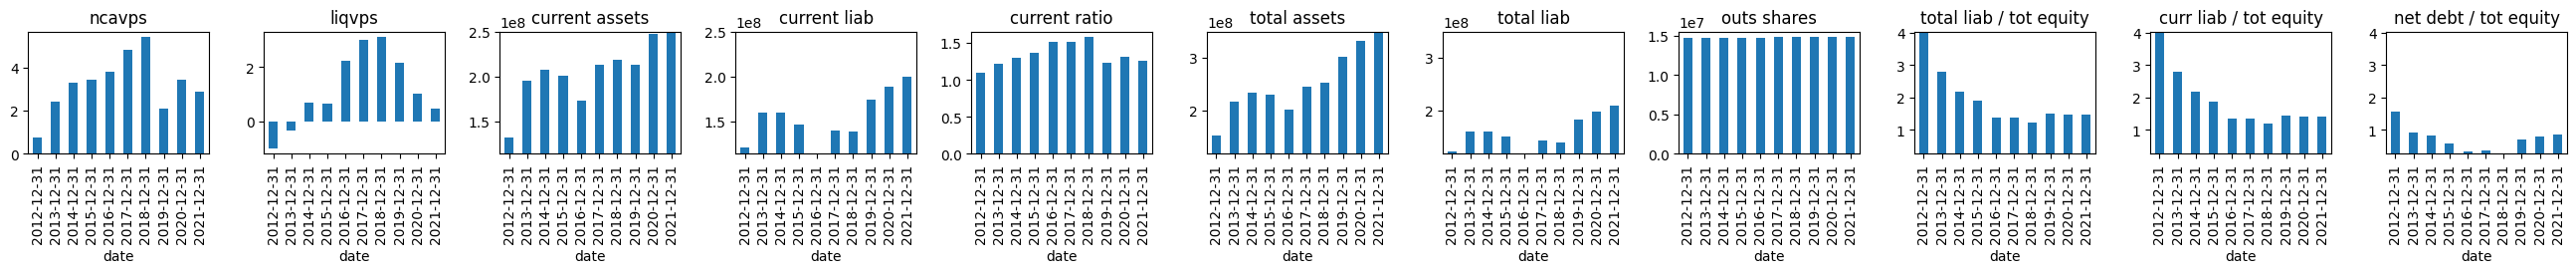

 56%|██████████████████████████████████████████████████████████████████▎                                                   | 305/543 [11:34<07:53,  1.99s/it]

FACO.	 Current price: 2.	 NCAV: 5.06687433076998.	 LIQV: 1.7294714299620364


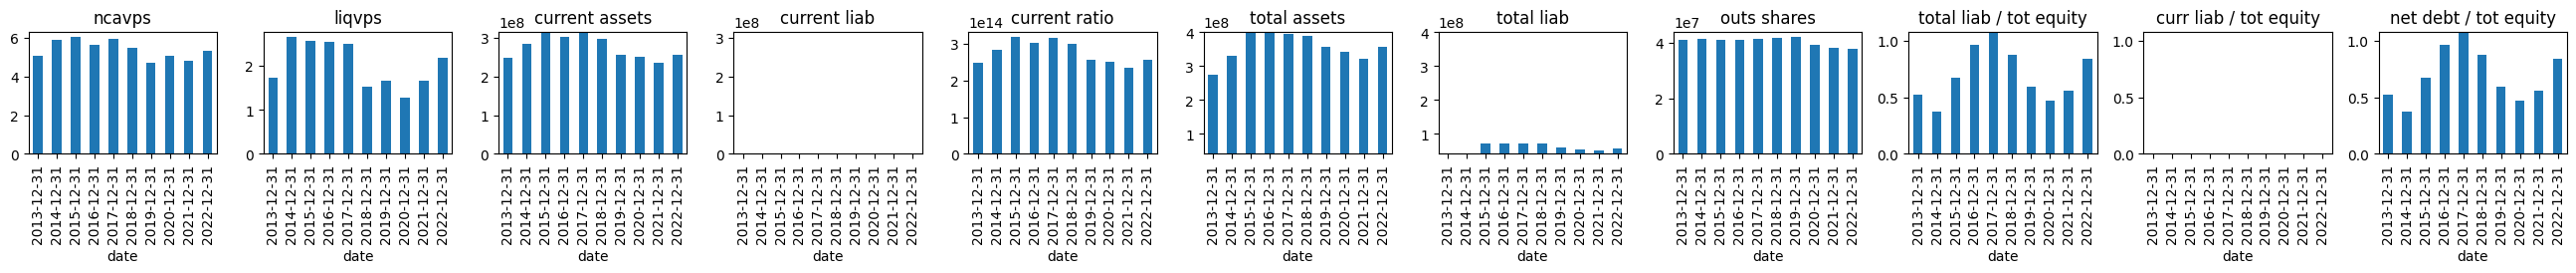

 57%|██████████████████████████████████████████████████████████████████▋                                                   | 307/543 [11:40<09:53,  2.52s/it]

dates incoherence


 58%|████████████████████████████████████████████████████████████████████▍                                                 | 315/543 [11:55<07:26,  1.96s/it]

FENG.	 Current price: 1.428.	 NCAV: 112.53964169147241.	 LIQV: 99.68652341739201


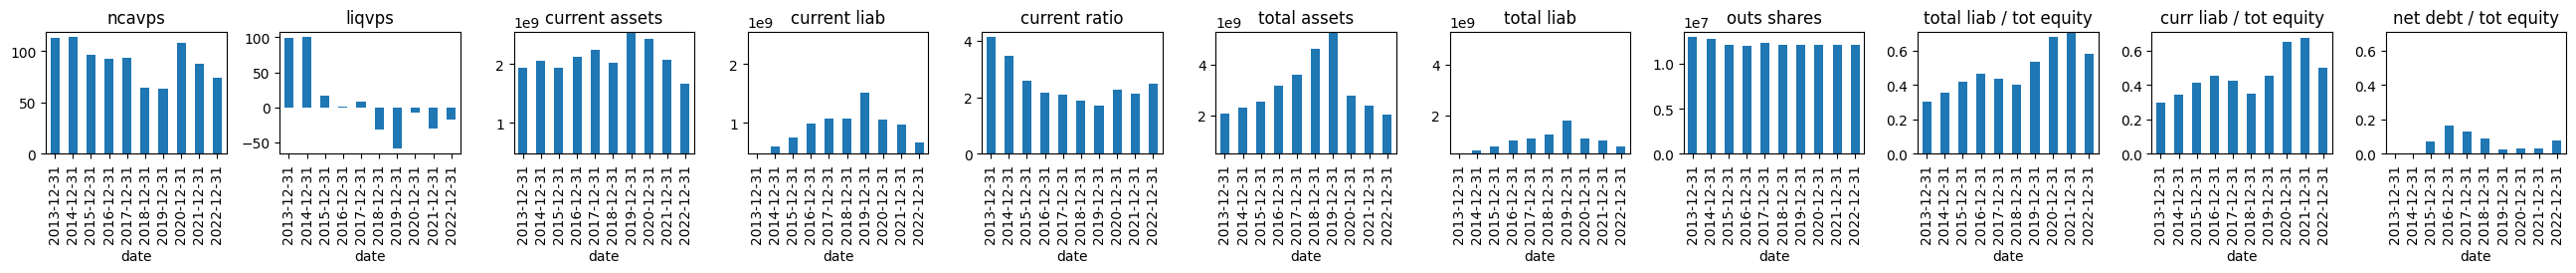

 58%|████████████████████████████████████████████████████████████████████▉                                                 | 317/543 [12:02<10:01,  2.66s/it]

FFHL.	 Current price: 8.3.	 NCAV: -42.22346411483254.	 LIQV: 43.264315406698564


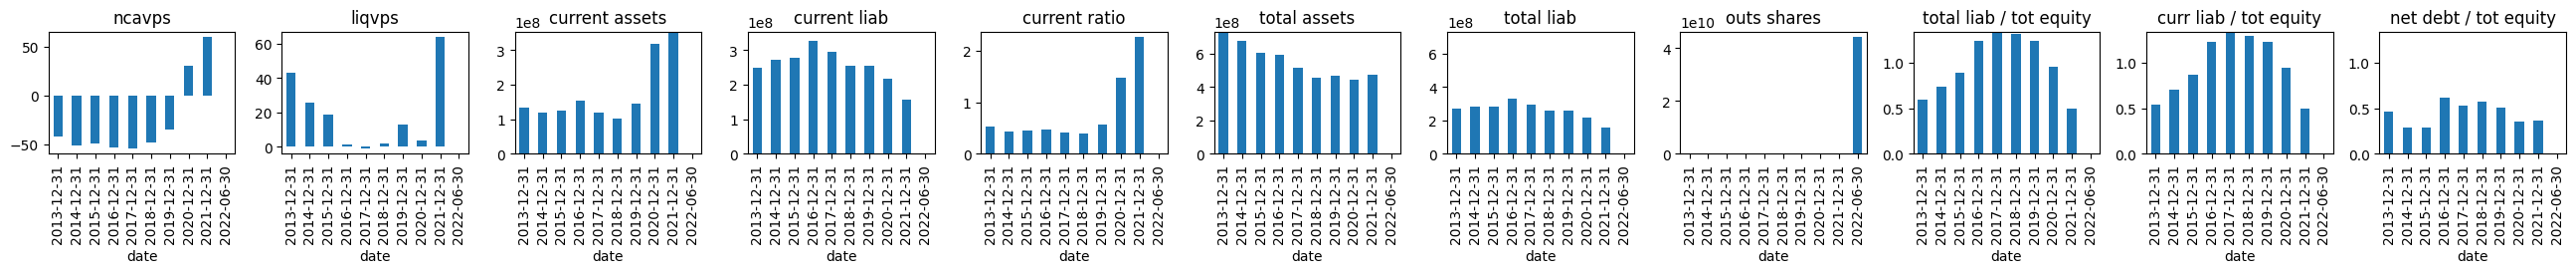

 59%|█████████████████████████████████████████████████████████████████████▊                                                | 321/543 [12:10<07:15,  1.96s/it]

FIRRY.	 Current price: 4.19.	 NCAV: 1.506521747485706.	 LIQV: 7.0043294508712535


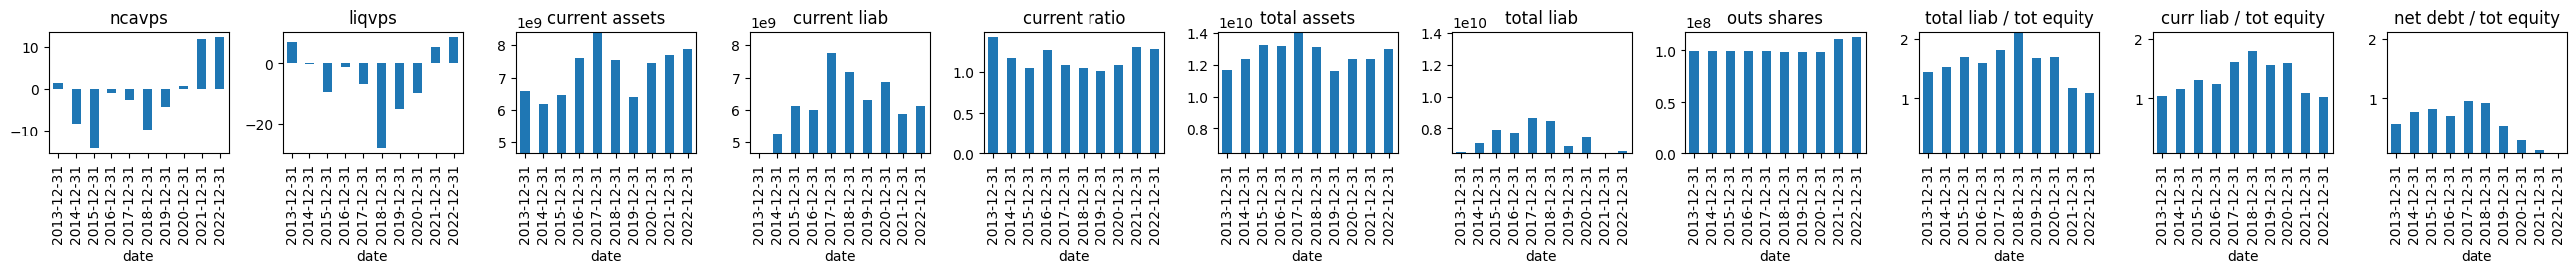

 59%|██████████████████████████████████████████████████████████████████████▏                                               | 323/543 [12:15<07:51,  2.14s/it]

FJTCY.	 Current price: 24.78.	 NCAV: 542.425478089645.	 LIQV: 520.4490087831128


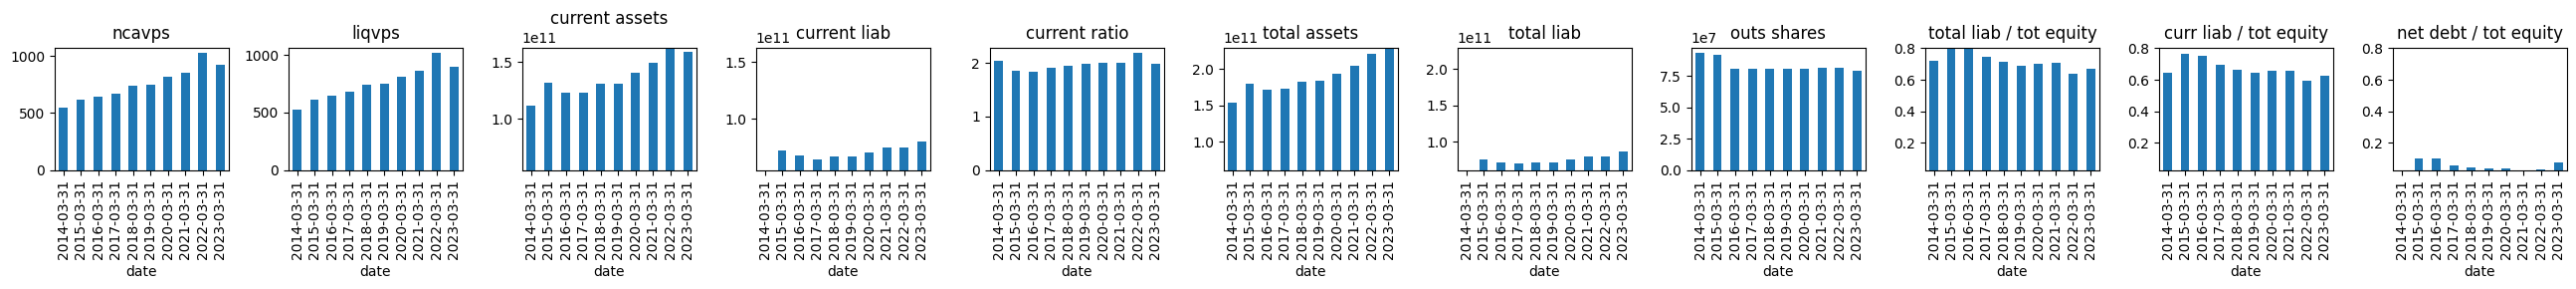

 60%|██████████████████████████████████████████████████████████████████████▊                                               | 326/543 [12:24<08:55,  2.47s/it]

FKKFF.	 Current price: 17.355.	 NCAV: 2436.8254581733136.	 LIQV: 3183.2670554091983


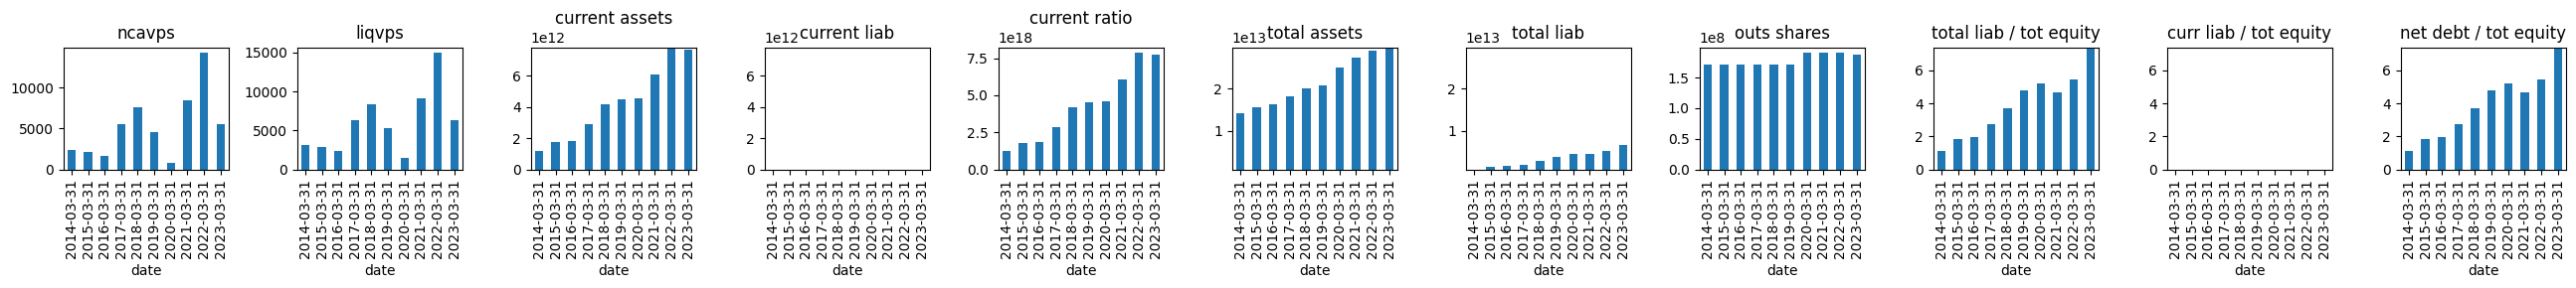

 60%|███████████████████████████████████████████████████████████████████████▎                                              | 328/543 [12:31<10:42,  2.99s/it]

dates incoherence


 61%|███████████████████████████████████████████████████████████████████████▍                                              | 329/543 [12:33<09:37,  2.70s/it]

FMMFF.	 Current price: 16.41.	 NCAV: 796.1584067993842.	 LIQV: 734.4073370305722


 61%|███████████████████████████████████████████████████████████████████████▋                                              | 330/543 [12:38<11:24,  3.21s/it]

FNCJF.	 Current price: 0.0531.	 NCAV: 0.04573489513601304.	 LIQV: 0.08815369869563994


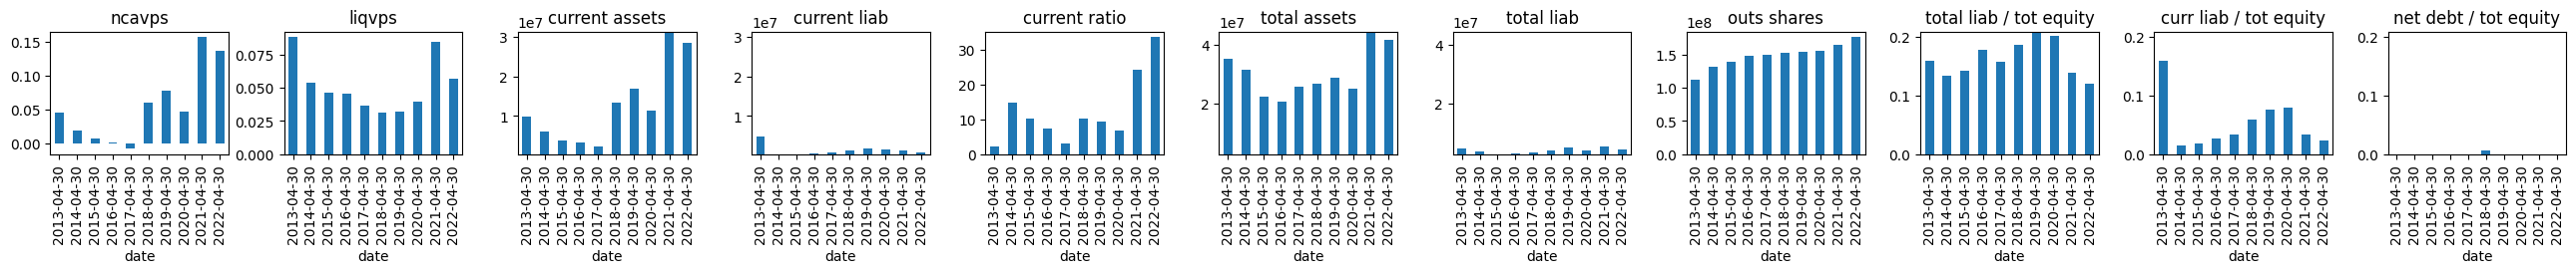

 61%|███████████████████████████████████████████████████████████████████████▉                                              | 331/543 [12:42<12:36,  3.57s/it]

FNEVF.	 Current price: 0.8301.	 NCAV: 1.8793253770374887.	 LIQV: 0.08572227875730186


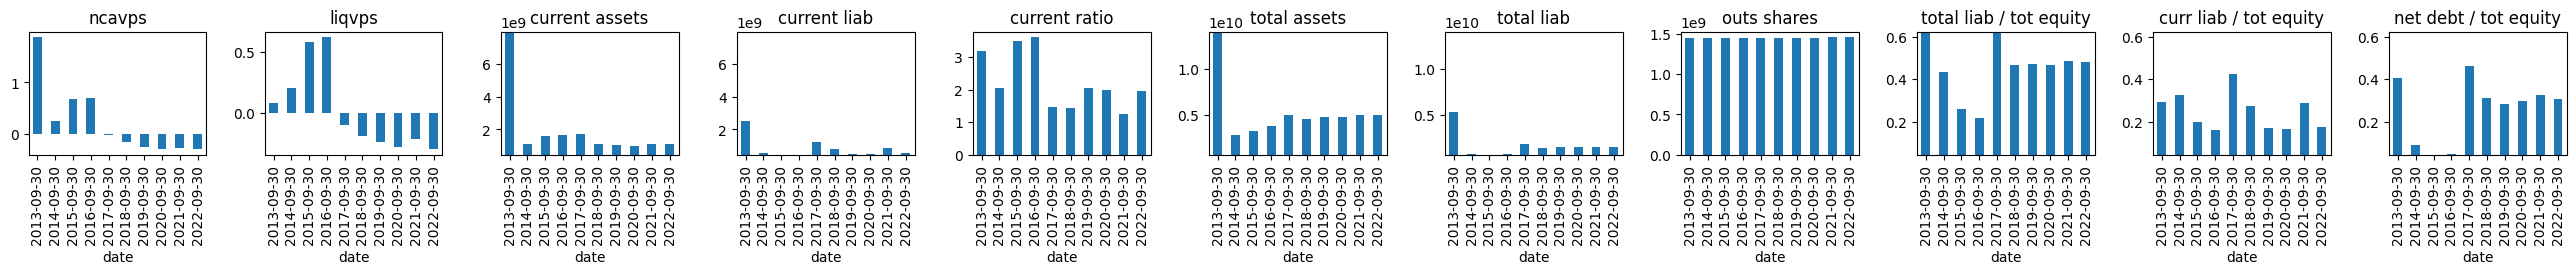

 62%|█████████████████████████████████████████████████████████████████████████▏                                            | 337/543 [12:56<08:02,  2.34s/it]

FRCOF.	 Current price: 244.825.	 NCAV: 1178.9367393880425.	 LIQV: 964.5531922367899


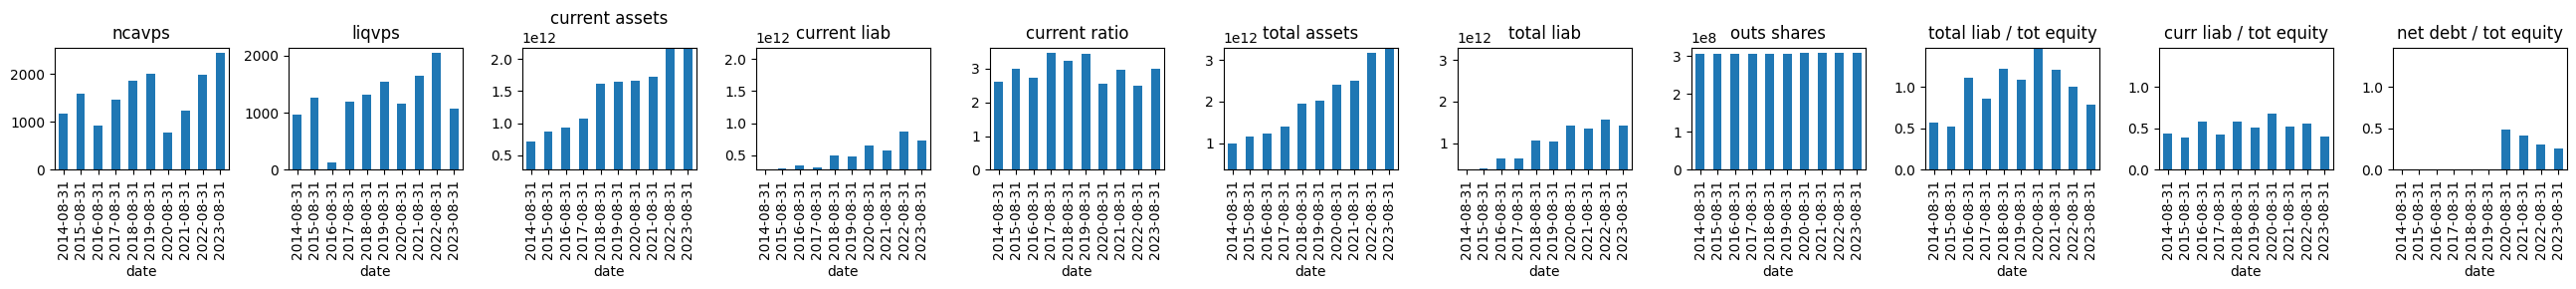

 62%|█████████████████████████████████████████████████████████████████████████▍                                            | 338/543 [13:01<10:35,  3.10s/it]

FRCOY.	 Current price: 23.25.	 NCAV: 117.89367393880424.	 LIQV: 96.455319223679


 63%|██████████████████████████████████████████████████████████████████████████                                            | 341/543 [13:11<10:17,  3.06s/it]

FRTN.	 Current price: 0.015.	 NCAV: 3.6483035388544325.	 LIQV: 24.30499817584823


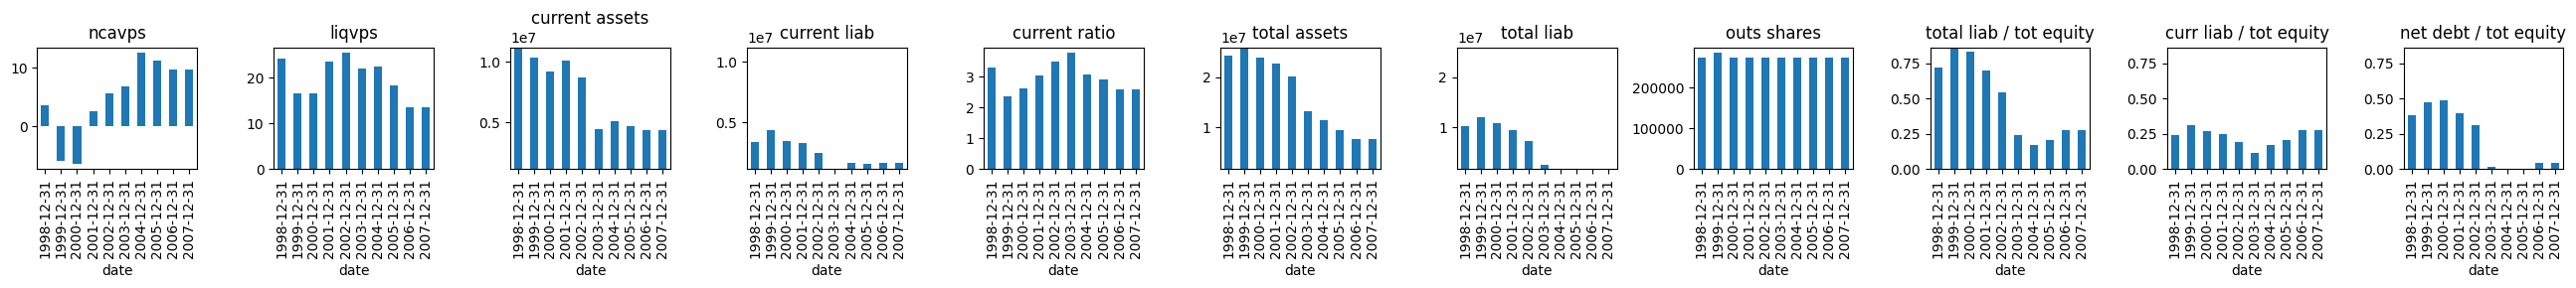

 64%|███████████████████████████████████████████████████████████████████████████▏                                          | 346/543 [13:20<05:56,  1.81s/it]

FTFT.	 Current price: 1.42.	 NCAV: 19.17744000561709.	 LIQV: 27.607064476802048


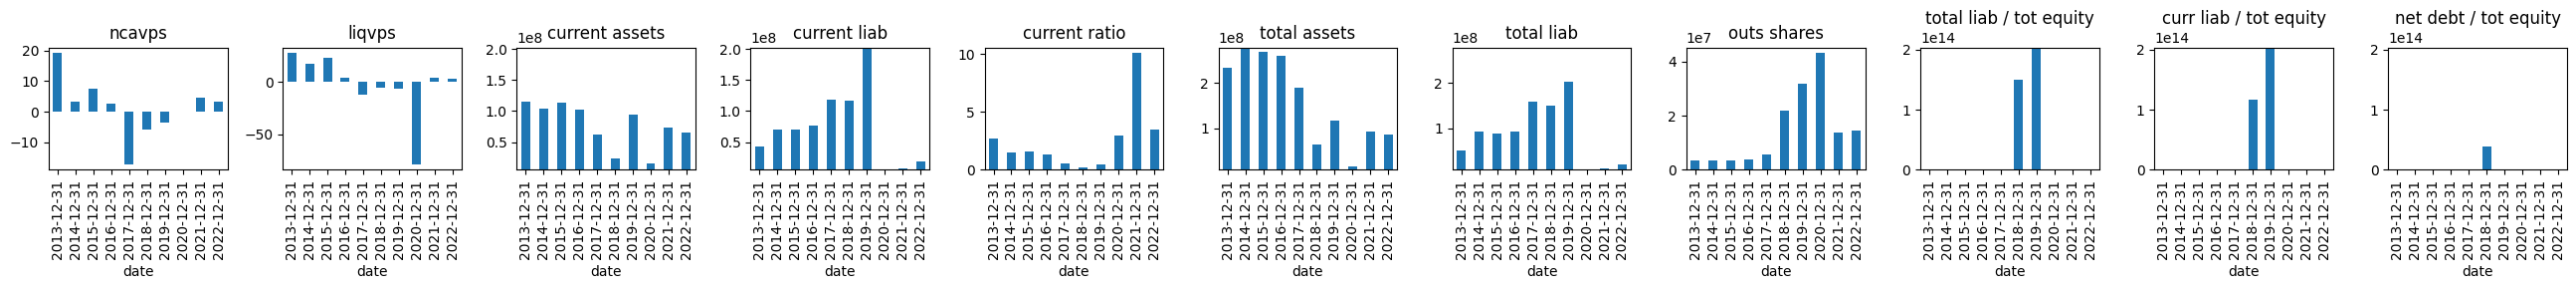

 64%|███████████████████████████████████████████████████████████████████████████▊                                          | 349/543 [13:28<06:40,  2.07s/it]

dates incoherence
FUJHY.	 Current price: 9.54.	 NCAV: 99.62109271888079.	 LIQV: -10.935191093820876


 65%|████████████████████████████████████████████████████████████████████████████▎                                         | 351/543 [13:35<08:23,  2.62s/it]

dates incoherence
FUJIY.	 Current price: 60.03.	 NCAV: 1516.9275409395718.	 LIQV: 309.0549951473079


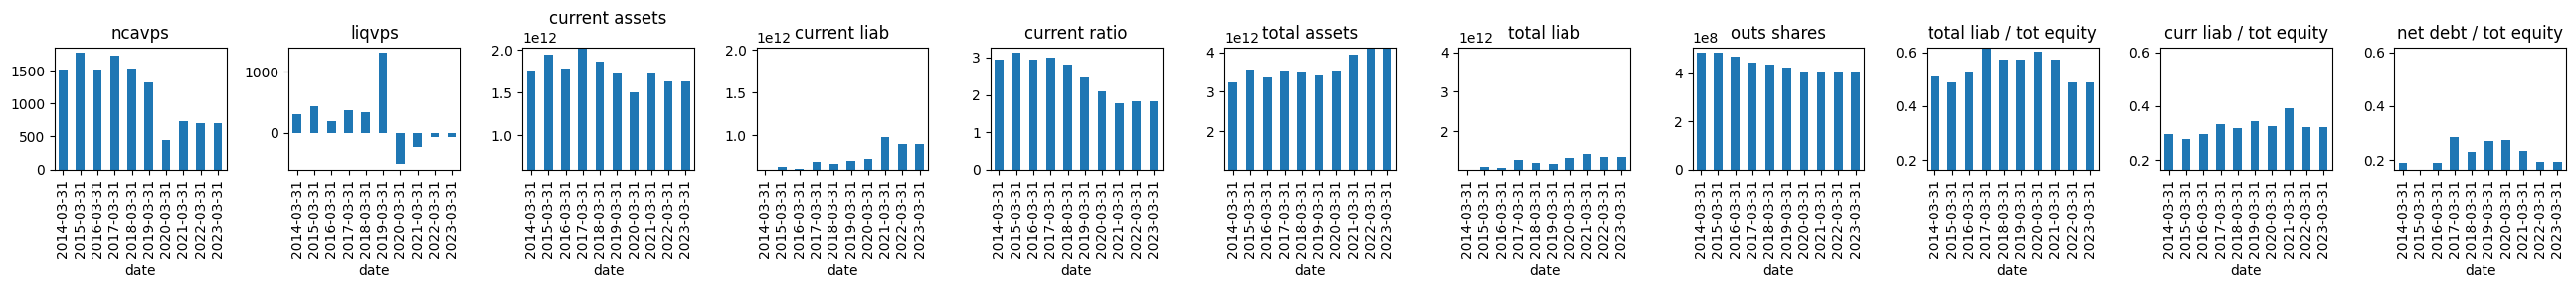

 66%|██████████████████████████████████████████████████████████████████████████████▏                                       | 360/543 [13:54<05:03,  1.66s/it]

GDNGY.	 Current price: 5.29.	 NCAV: 27546.517622894586.	 LIQV: 24336.160009313502


 68%|███████████████████████████████████████████████████████████████████████████████▉                                      | 368/543 [14:06<03:22,  1.15s/it]

GFELF.	 Current price: 8.9789.	 NCAV: 9.39110838307273.	 LIQV: 6.860412103258332


 68%|████████████████████████████████████████████████████████████████████████████████▏                                     | 369/543 [14:10<06:09,  2.12s/it]

GGNPF.	 Current price: 1.305.	 NCAV: 6886.629405723646.	 LIQV: 6084.0400023283755


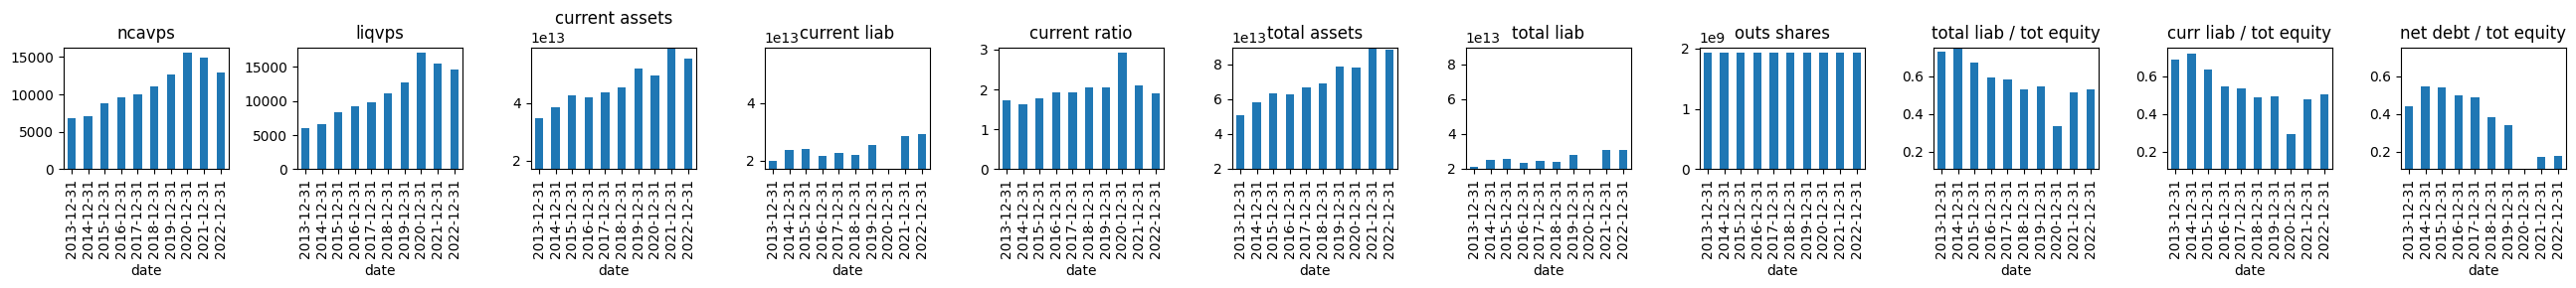

 69%|████████████████████████████████████████████████████████████████████████████████▊                                     | 372/543 [14:19<06:52,  2.41s/it]

GIGM.	 Current price: 1.39.	 NCAV: 6.7341363942365655.	 LIQV: 4.647553138937705


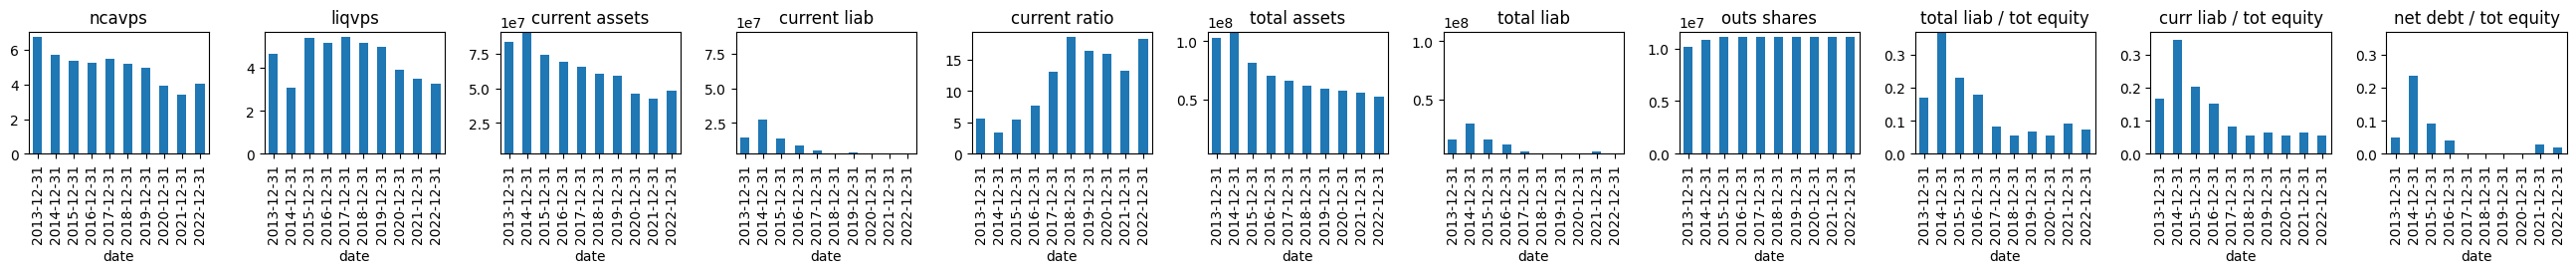

 69%|█████████████████████████████████████████████████████████████████████████████████▉                                    | 377/543 [14:27<03:49,  1.38s/it]

GLBZ.	 Current price: 6.16.	 NCAV: 30886.84184517668.	 LIQV: -120.74188817444767


 70%|██████████████████████████████████████████████████████████████████████████████████▊                                   | 381/543 [14:35<03:49,  1.42s/it]

GMOYF.	 Current price: 17.29.	 NCAV: 125.99764691040285.	 LIQV: -2775.2396248988857


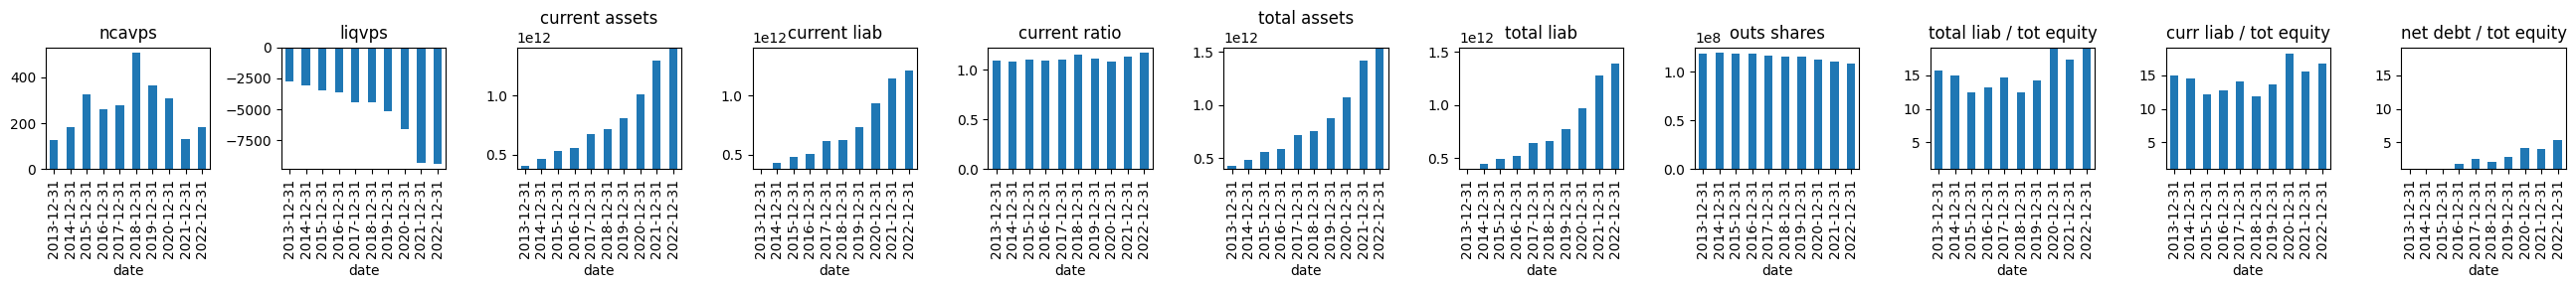

 71%|███████████████████████████████████████████████████████████████████████████████████▉                                  | 386/543 [14:46<05:10,  1.98s/it]

GNLN.	 Current price: 0.4944.	 NCAV: 65.19883530939713.	 LIQV: -129.70420671163433


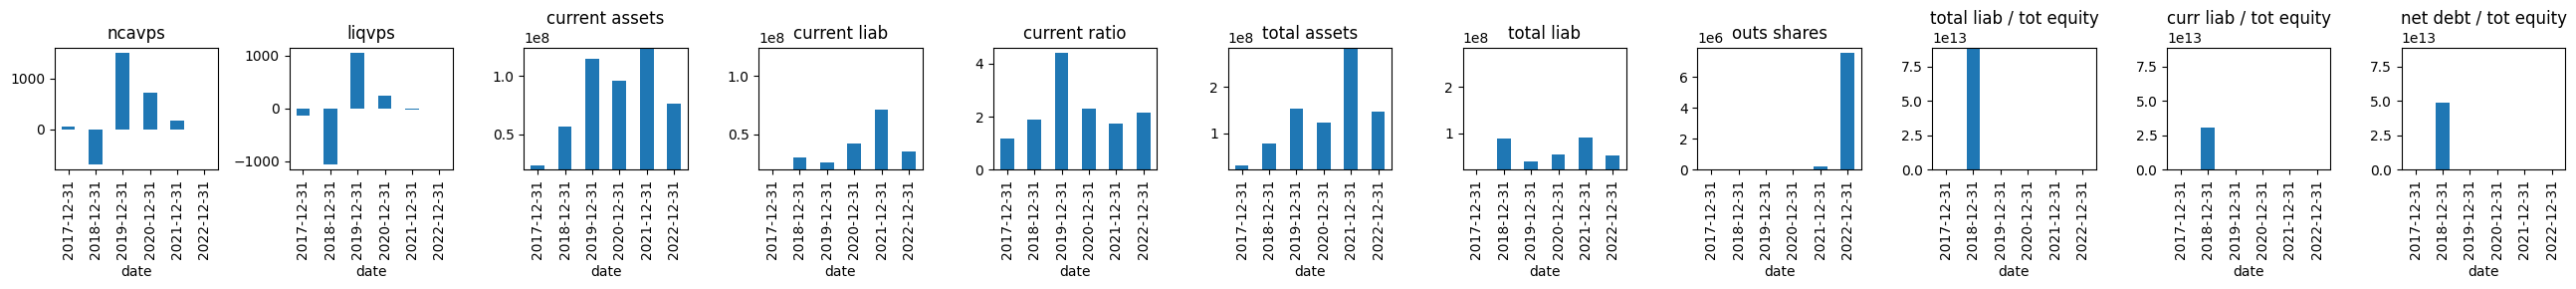

 72%|████████████████████████████████████████████████████████████████████████████████████▊                                 | 390/543 [14:55<05:10,  2.03s/it]

GOVXW.	 Current price: 0.0499.	 NCAV: 2385990.0.	 LIQV: 2394791.29


 72%|█████████████████████████████████████████████████████████████████████████████████████▏                                | 392/543 [15:01<05:34,  2.21s/it]

GPOTF.	 Current price: 0.0311.	 NCAV: 0.34067249916676096.	 LIQV: 0.13528650767981612


 74%|███████████████████████████████████████████████████████████████████████████████████████▌                              | 403/543 [15:17<02:32,  1.09s/it]

GYRO.	 Current price: 9.75.	 NCAV: -36.98991300714744.	 LIQV: 90.10226852888074


 75%|████████████████████████████████████████████████████████████████████████████████████████                              | 405/543 [15:24<04:46,  2.08s/it]

dates incoherence


 77%|███████████████████████████████████████████████████████████████████████████████████████████                           | 419/543 [15:45<03:42,  1.79s/it]

HMY.	 Current price: 5.9.	 NCAV: -12.427110037610849.	 LIQV: 36.5176365922501


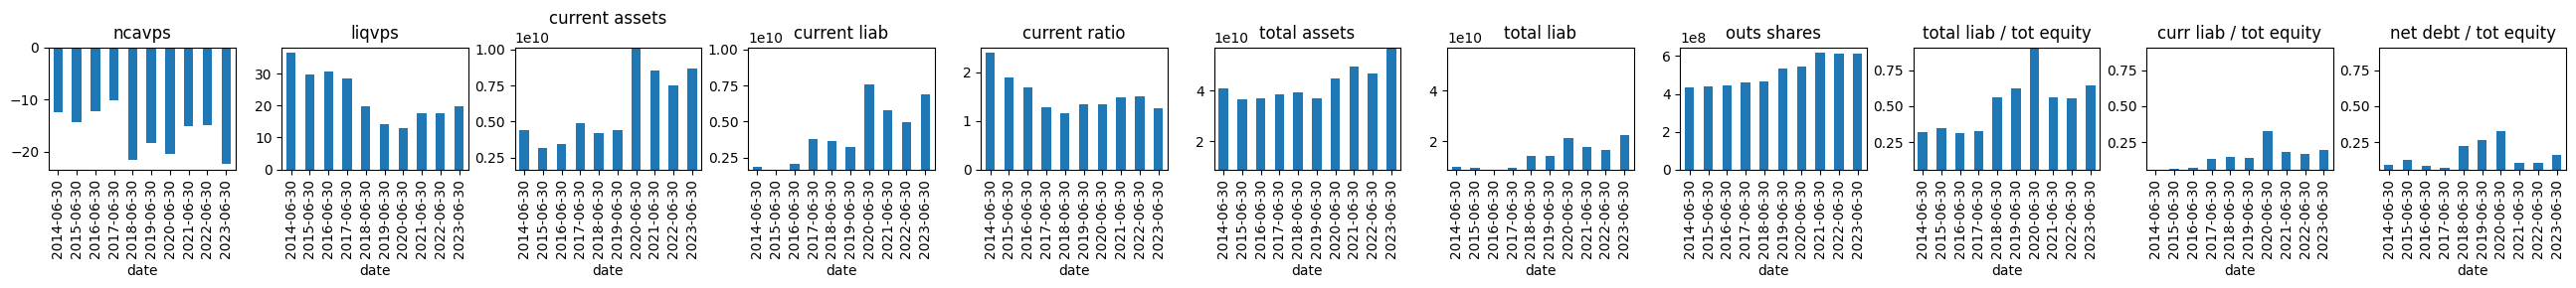

 77%|███████████████████████████████████████████████████████████████████████████████████████████▎                          | 420/543 [15:50<05:26,  2.66s/it]

HOCPF.	 Current price: 112.5.	 NCAV: 816.5914625825953.	 LIQV: 858.1122348680209


 78%|███████████████████████████████████████████████████████████████████████████████████████████▍                          | 421/543 [15:54<06:28,  3.19s/it]

HOCPY.	 Current price: 116.77.	 NCAV: 816.5914625825953.	 LIQV: 858.1122348680209


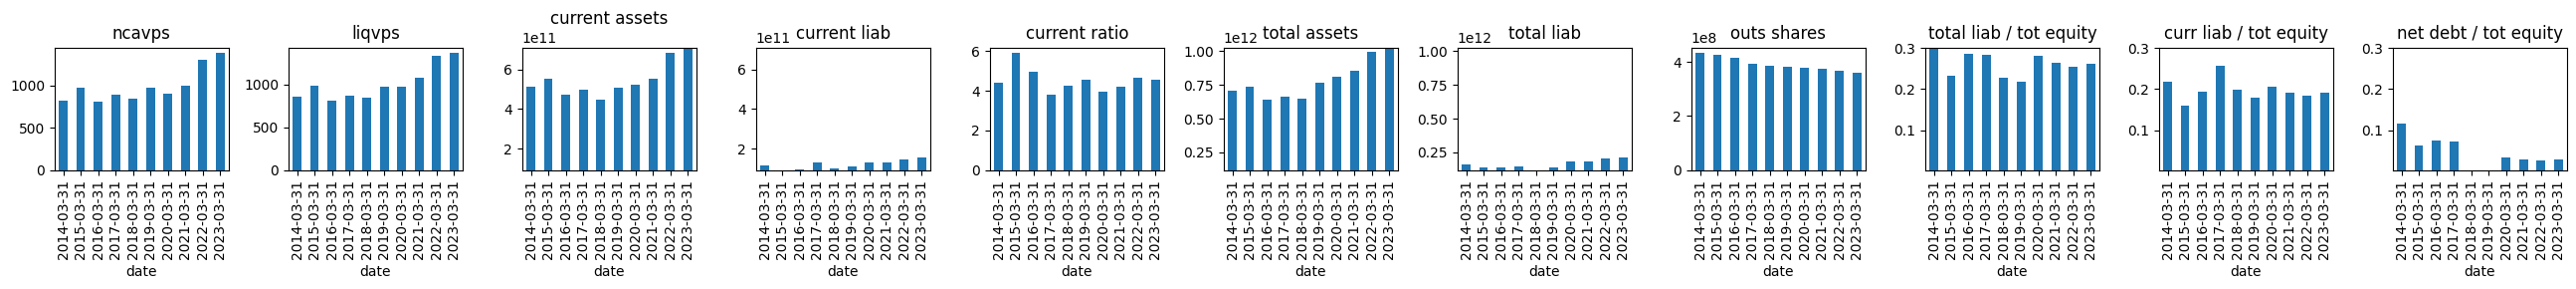

 78%|███████████████████████████████████████████████████████████████████████████████████████████▉                          | 423/543 [16:00<05:55,  2.96s/it]

HRIBF.	 Current price: 67.54.	 NCAV: 1543.3451606438102.	 LIQV: 1181.7153284078252


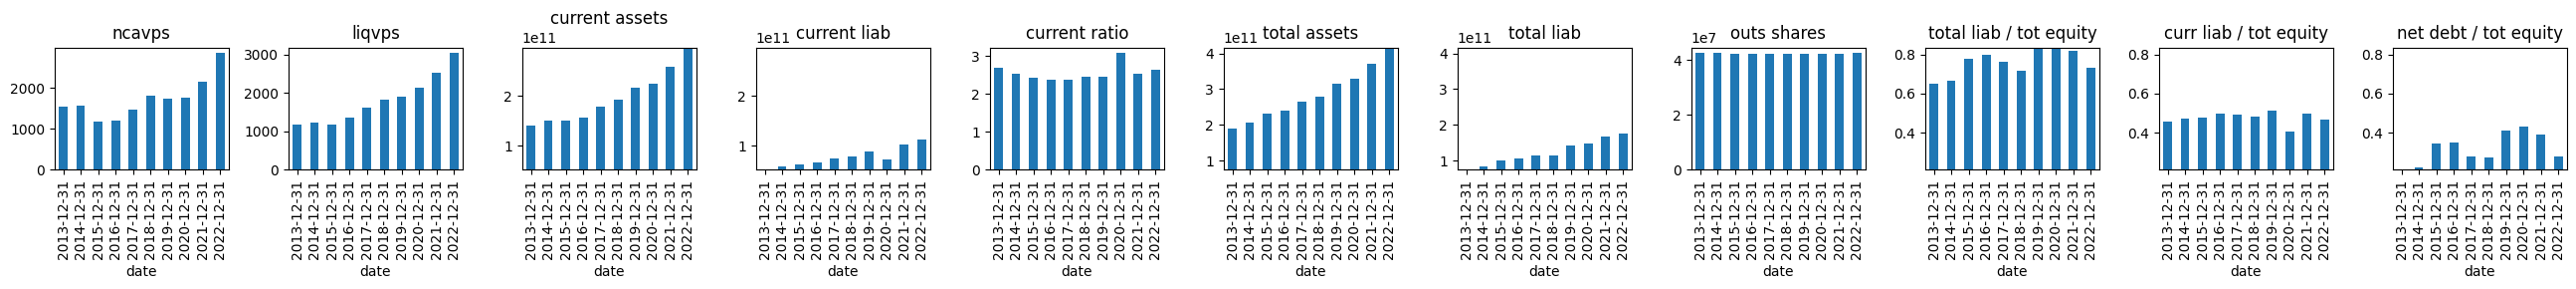

 78%|████████████████████████████████████████████████████████████████████████████████████████████▎                         | 425/543 [16:07<06:02,  3.08s/it]

dates incoherence
HRSEF.	 Current price: 116.7599.	 NCAV: 4925.1274071300995.	 LIQV: 4316.497552487131


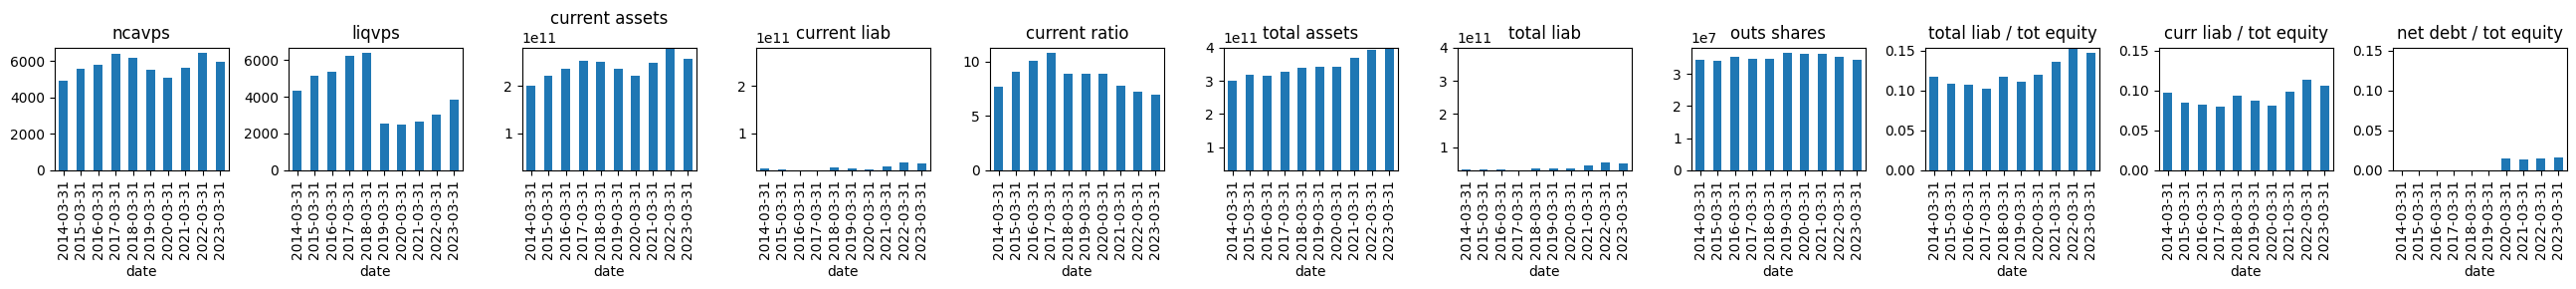

 79%|████████████████████████████████████████████████████████████████████████████████████████████▊                         | 427/543 [16:12<05:06,  2.64s/it]

HSHZY.	 Current price: 8.18.	 NCAV: 128.53737077754624.	 LIQV: 144.0375101950624


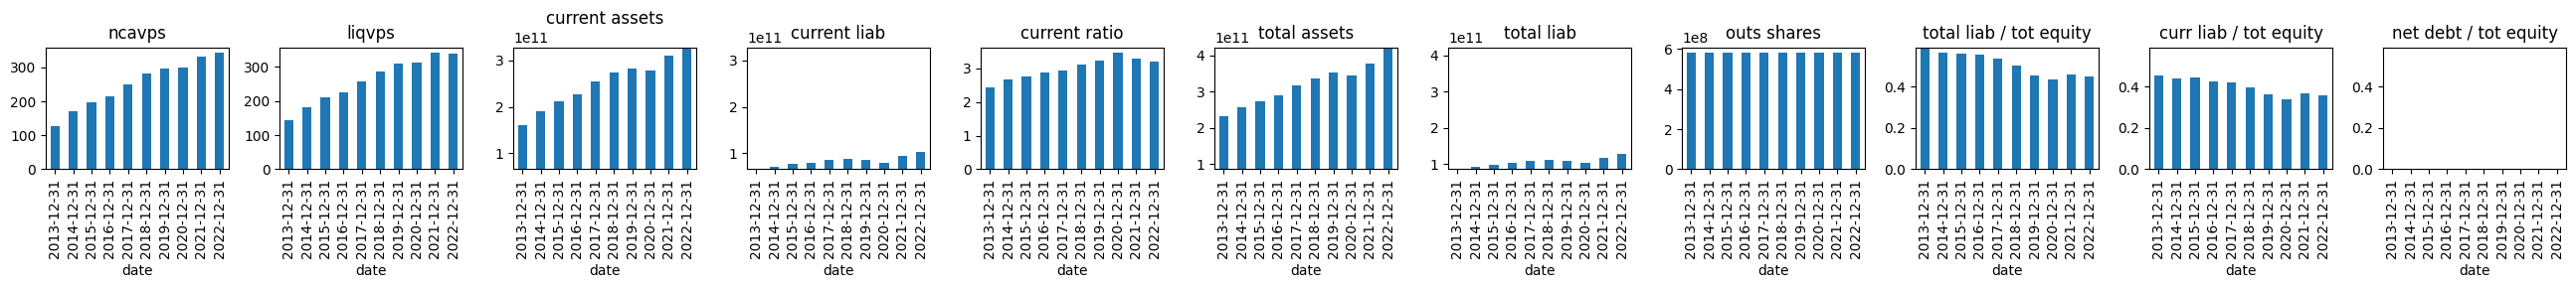

 79%|█████████████████████████████████████████████████████████████████████████████████████████████                         | 428/543 [16:17<06:06,  3.19s/it]

HTCMY.	 Current price: 53.421.	 NCAV: 747.2483726573738.	 LIQV: 170.92311115833013


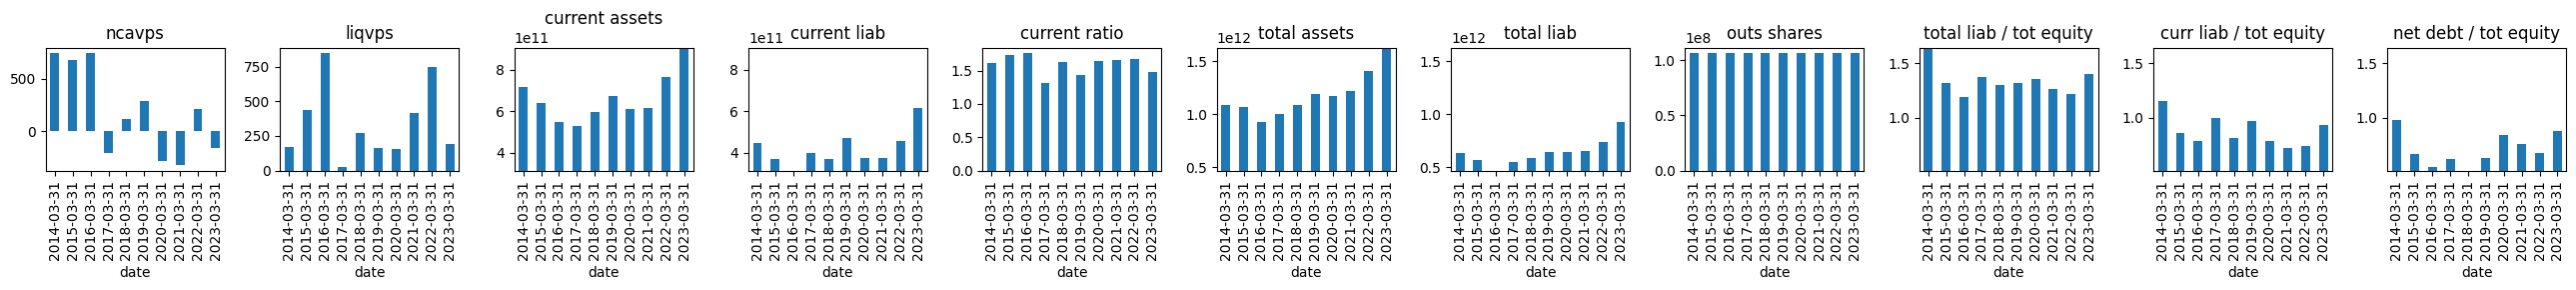

 79%|█████████████████████████████████████████████████████████████████████████████████████████████▍                        | 430/543 [16:22<05:04,  2.69s/it]

HTSUF.	 Current price: 34.	 NCAV: 975.393379091376.	 LIQV: 944.5662324321801


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▌                      | 440/543 [16:43<03:25,  2.00s/it]

dates of last income statement and balance sheet are not the same for ticker HX
	income stmt date: 2015-03-31, balance sheet date: 2016-03-31


 81%|████████████████████████████████████████████████████████████████████████████████████████████████                      | 442/543 [16:46<02:41,  1.60s/it]

HYW.	 Current price: 1.5.	 NCAV: 14.85475.	 LIQV: 10.468521785714286


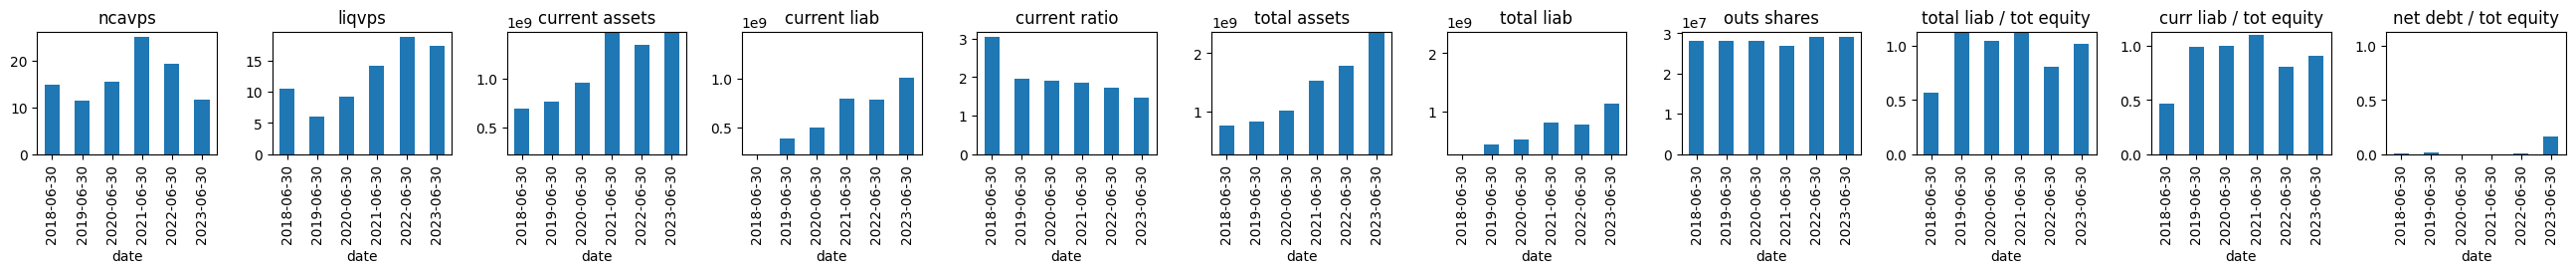

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 444/543 [16:52<03:44,  2.27s/it]

dates of last income statement and balance sheet are not the same for ticker IAUFF
	income stmt date: 1996-06-30, balance sheet date: 2013-12-31
IBA.	 Current price: 53.	 NCAV: 117.43737871482611.	 LIQV: 222.85431630967346


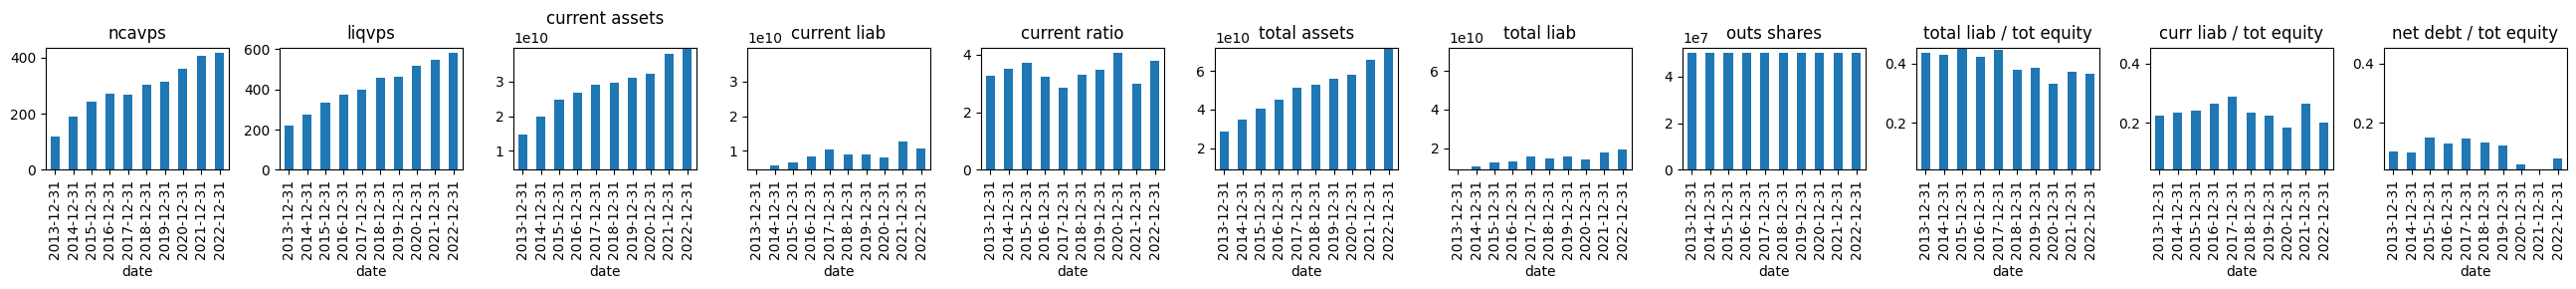

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 445/543 [16:56<04:46,  2.92s/it]

IBIDF.	 Current price: 46.71.	 NCAV: 452.59262572236105.	 LIQV: 1077.854209789478


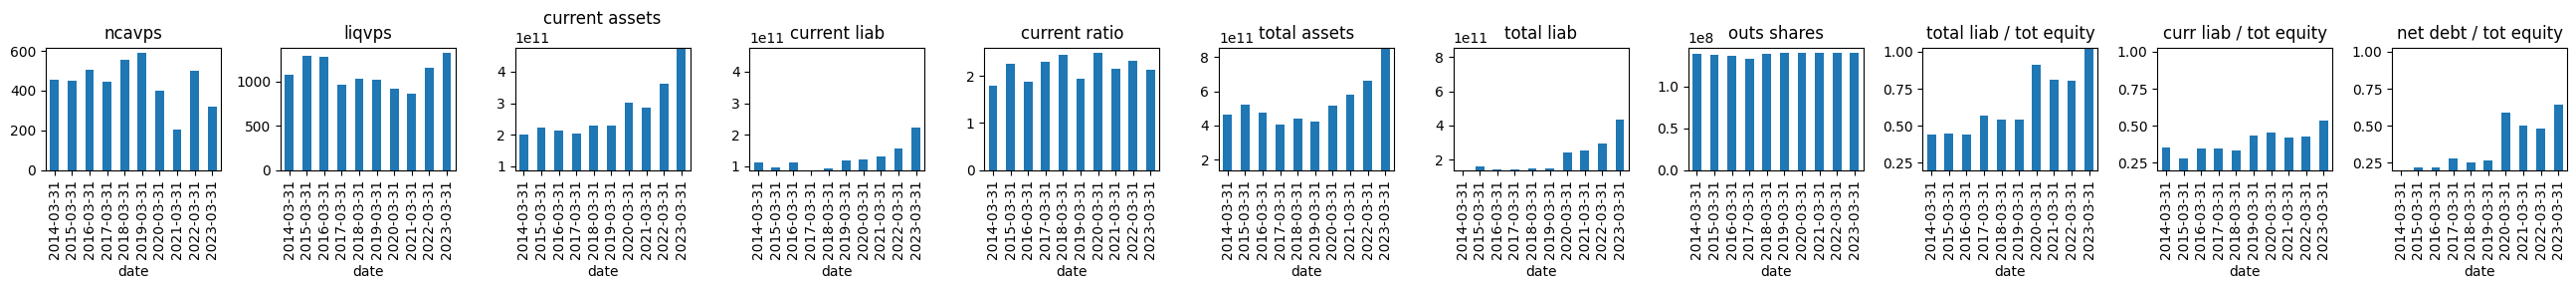

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 448/543 [17:05<04:17,  2.71s/it]

IDCBF.	 Current price: 0.47546.	 NCAV: 1.2653555124903424.	 LIQV: 1.3858692749642418


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 450/543 [17:11<04:27,  2.87s/it]

IDND.	 Current price: 0.0029.	 NCAV: 0.5166941111132064.	 LIQV: 0.505815637799002


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 458/543 [17:27<02:36,  1.84s/it]

IMNN.	 Current price: 0.6948.	 NCAV: 459.30274973247106.	 LIQV: -116.38159369717273


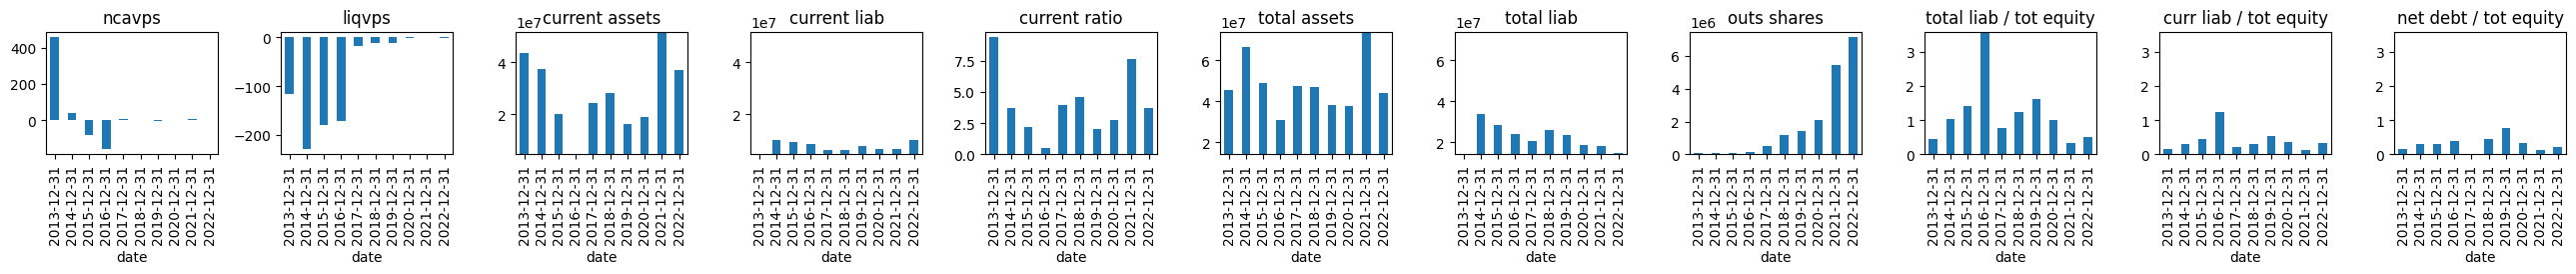

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 459/543 [17:32<03:39,  2.62s/it]

IMOS.	 Current price: 26.64.	 NCAV: 129.76918142282585.	 LIQV: 290.72177423520674


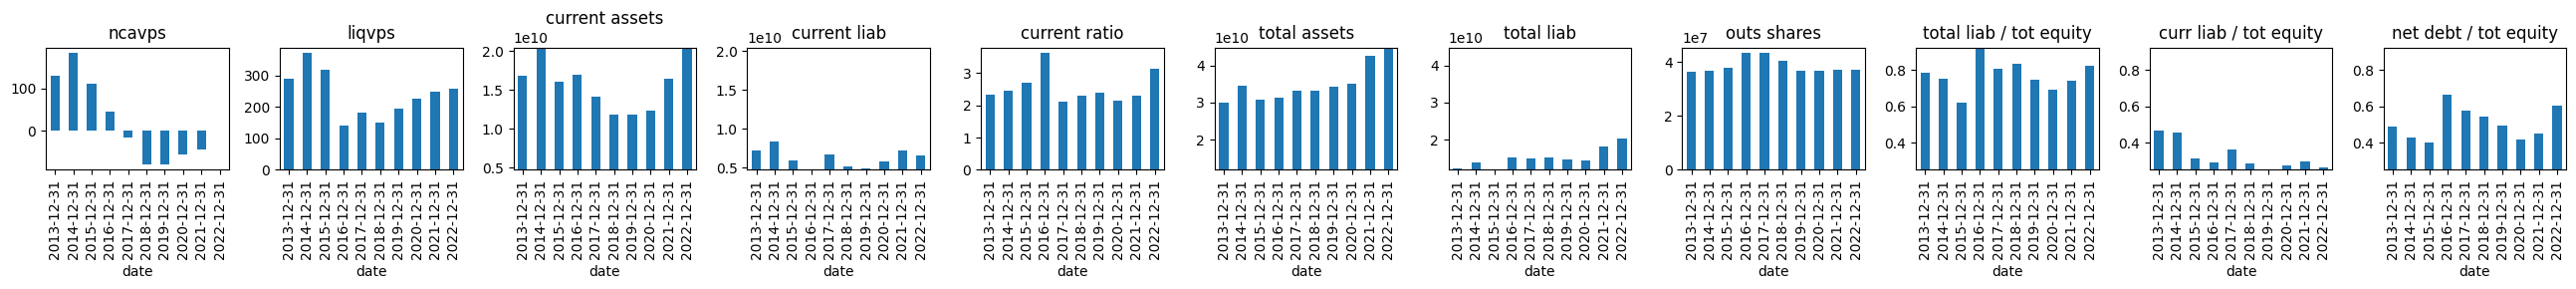

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 461/543 [17:38<03:56,  2.88s/it]

IMPUY.	 Current price: 4.54.	 NCAV: -16.08127005017685.	 LIQV: 28.57139096816649


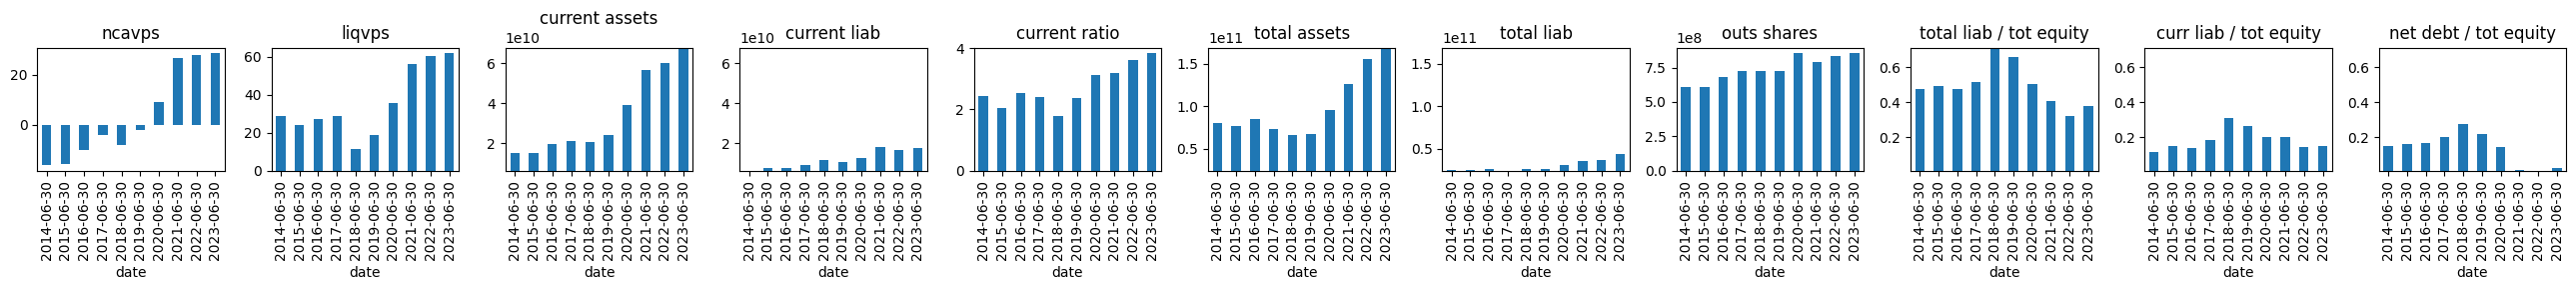

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 462/543 [17:43<04:30,  3.34s/it]

IMUC.	 Current price: 0.37495.	 NCAV: 93.2977990430622.	 LIQV: -3.106474003189793


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████                 | 465/543 [17:50<03:09,  2.43s/it]

INM.	 Current price: 0.37.	 NCAV: 2.756924319080438.	 LIQV: -1.0405370322686192


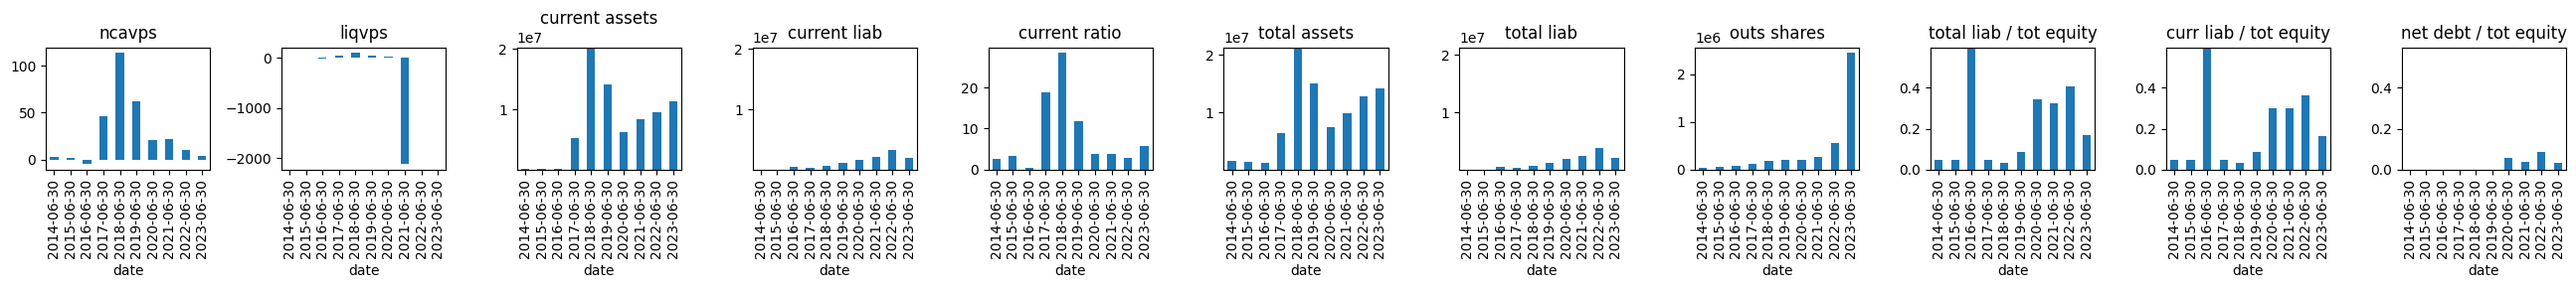

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 469/543 [17:59<02:39,  2.15s/it]

IOR.	 Current price: 13.85.	 NCAV: 13.316014964682715.	 LIQV: 13.989581628966267


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 471/543 [18:04<02:43,  2.27s/it]

ISUZF.	 Current price: 12.715.	 NCAV: -8.100652823607204.	 LIQV: 237.84603938908555


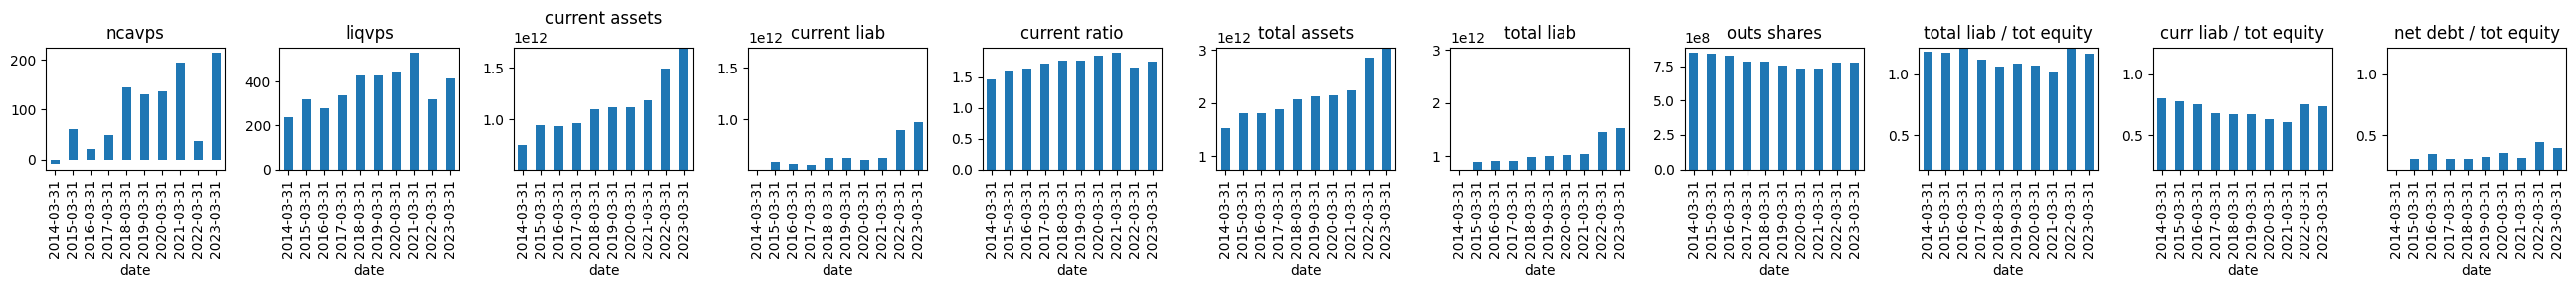

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 472/543 [18:09<03:27,  2.92s/it]

ITOEF.	 Current price: 28.685.	 NCAV: 11.802046135343023.	 LIQV: 223.3596043985713


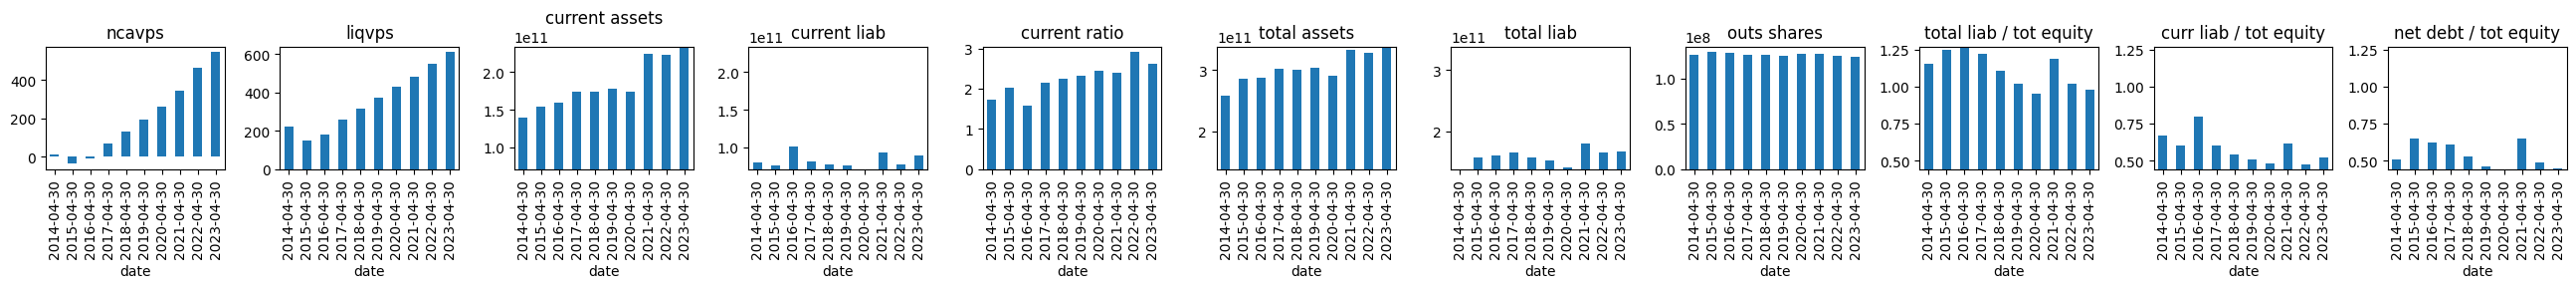

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 473/543 [18:13<04:00,  3.44s/it]

ITTOY.	 Current price: 14.07.	 NCAV: 223.05949940525903.	 LIQV: 133.20434624891385


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 476/543 [18:22<03:11,  2.85s/it]

JCRRF.	 Current price: 9.04.	 NCAV: 66.34523772671817.	 LIQV: 50.89624154434753


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 480/543 [18:30<02:04,  1.98s/it]

JFU.	 Current price: 3.27.	 NCAV: 76.73788791680423.	 LIQV: 56.11095761802575


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 486/543 [18:41<01:41,  1.78s/it]

JPPYY.	 Current price: 0.0457.	 NCAV: 4.712517694897283.	 LIQV: 1.8497971195546528


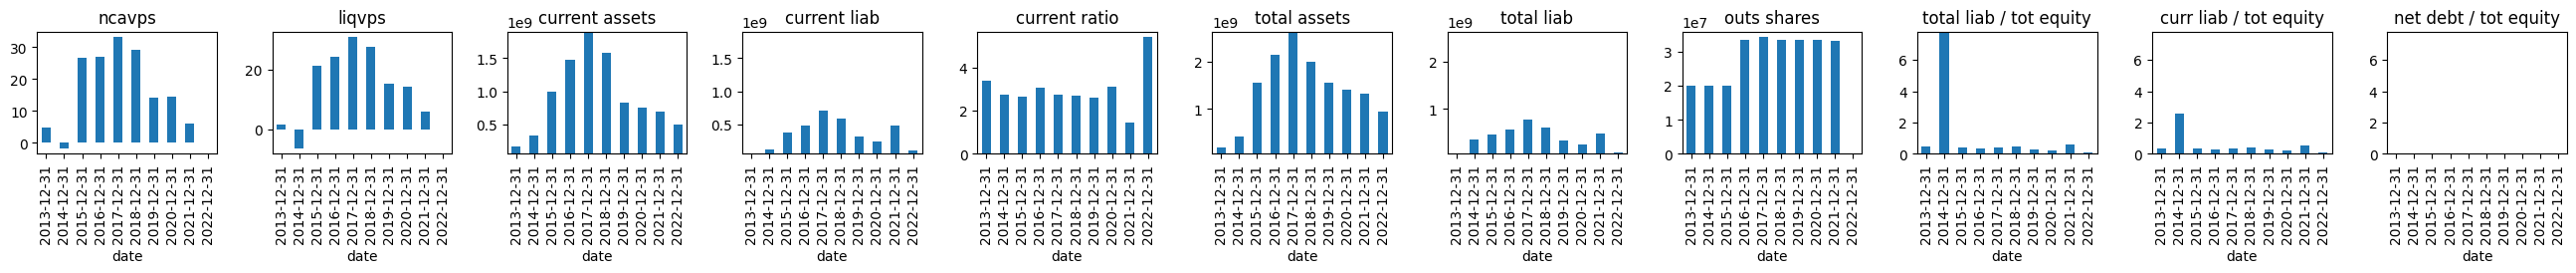

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 487/543 [18:46<02:28,  2.65s/it]

JPTXF.	 Current price: 35.	 NCAV: 508.94106942889135.	 LIQV: 1708.8192889137738


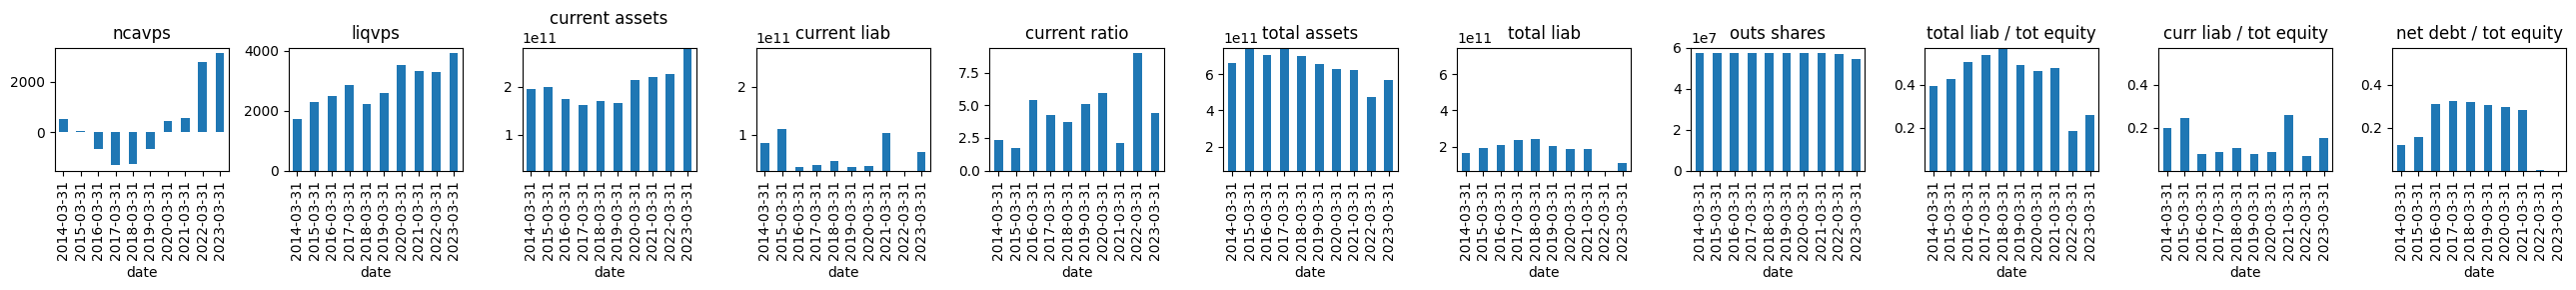

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████            | 488/543 [18:50<02:55,  3.19s/it]

JRJCY.	 Current price: 1e-06.	 NCAV: 38.02280343588777.	 LIQV: 9.099520762580232


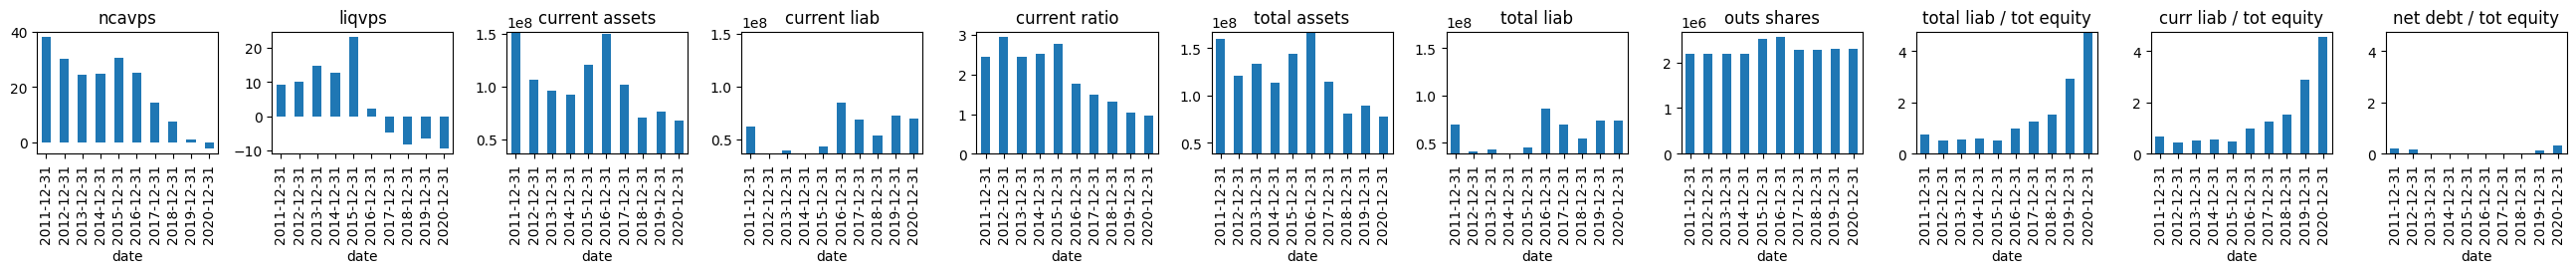

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 492/543 [19:00<02:02,  2.41s/it]

KAOOY.	 Current price: 8.06.	 NCAV: 40.17073624622855.	 LIQV: 28.635476987504518


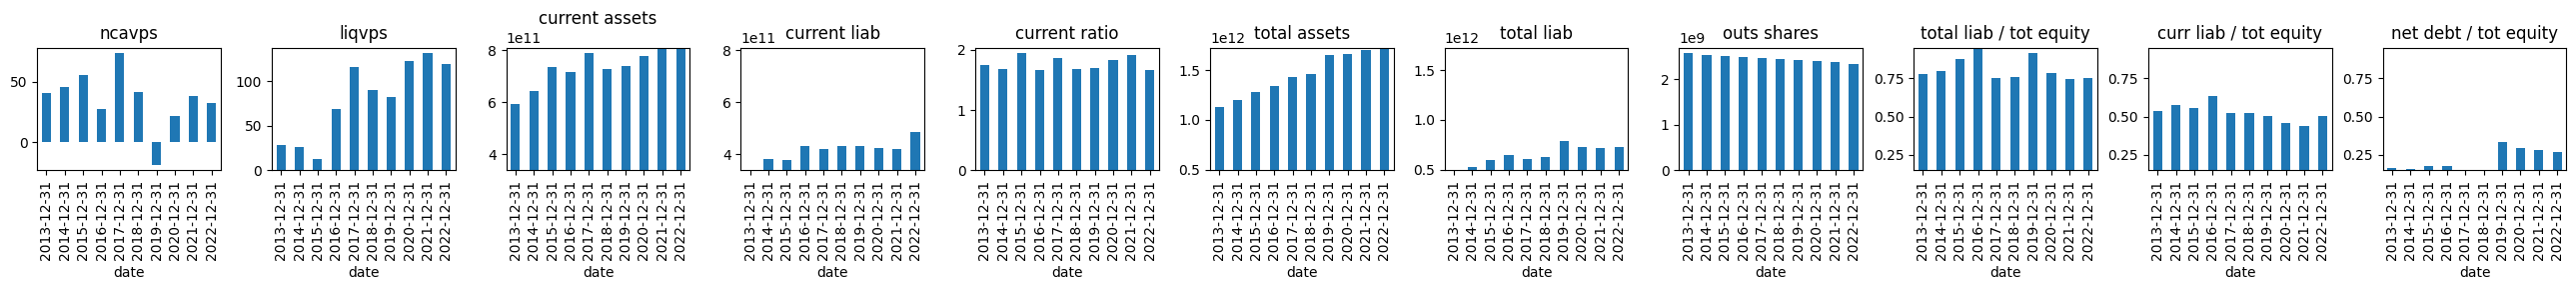

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 494/543 [19:07<02:15,  2.77s/it]

KGJI.	 Current price: 1e-06.	 NCAV: 6.644085452728087.	 LIQV: 4.718088206361823


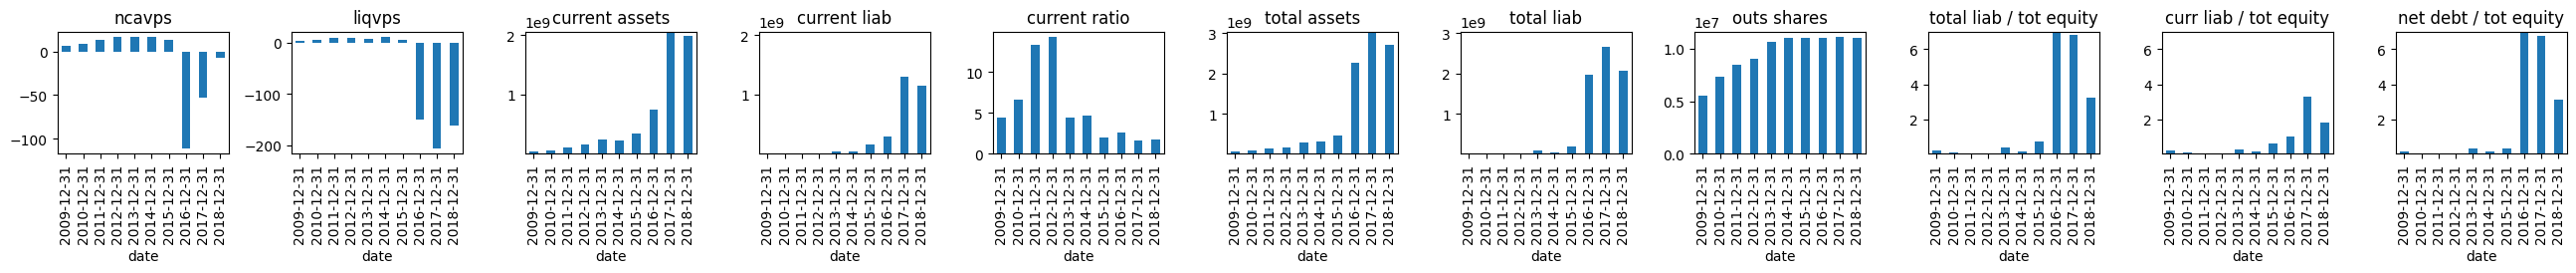

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 497/543 [19:15<02:00,  2.62s/it]

KKKUF.	 Current price: 10.51.	 NCAV: 106.32892756688983.	 LIQV: 103.23541599282984


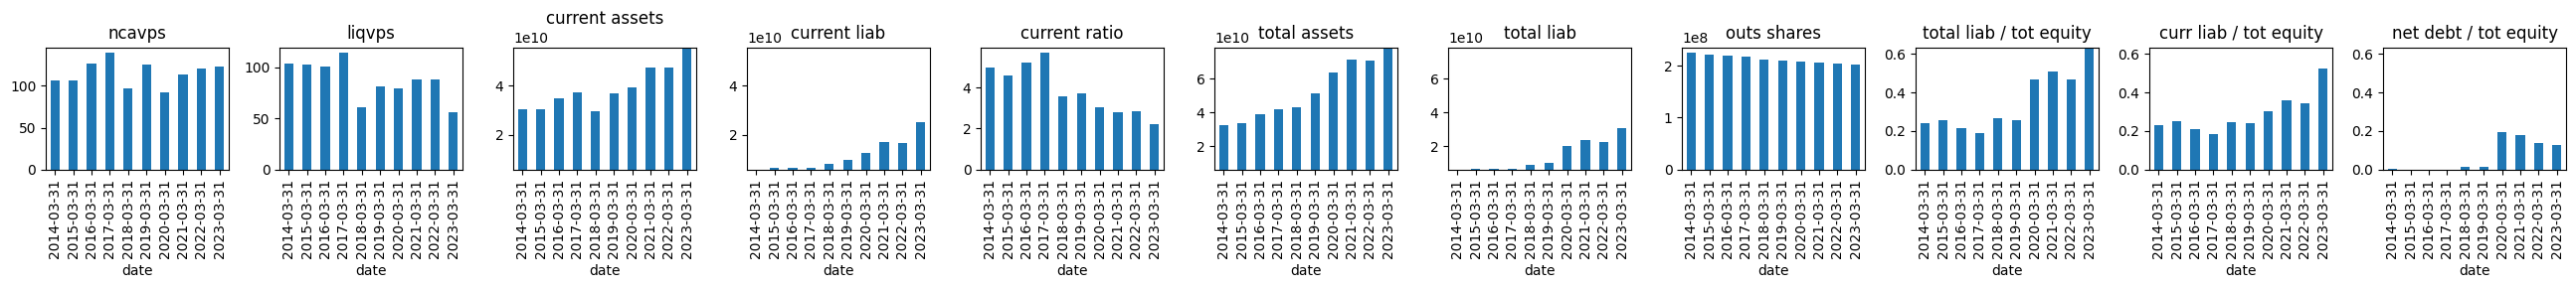

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 499/543 [19:22<02:10,  2.96s/it]

dates incoherence
KMTUY.	 Current price: 26.4.	 NCAV: 296.57749681858076.	 LIQV: 205.89805232729483


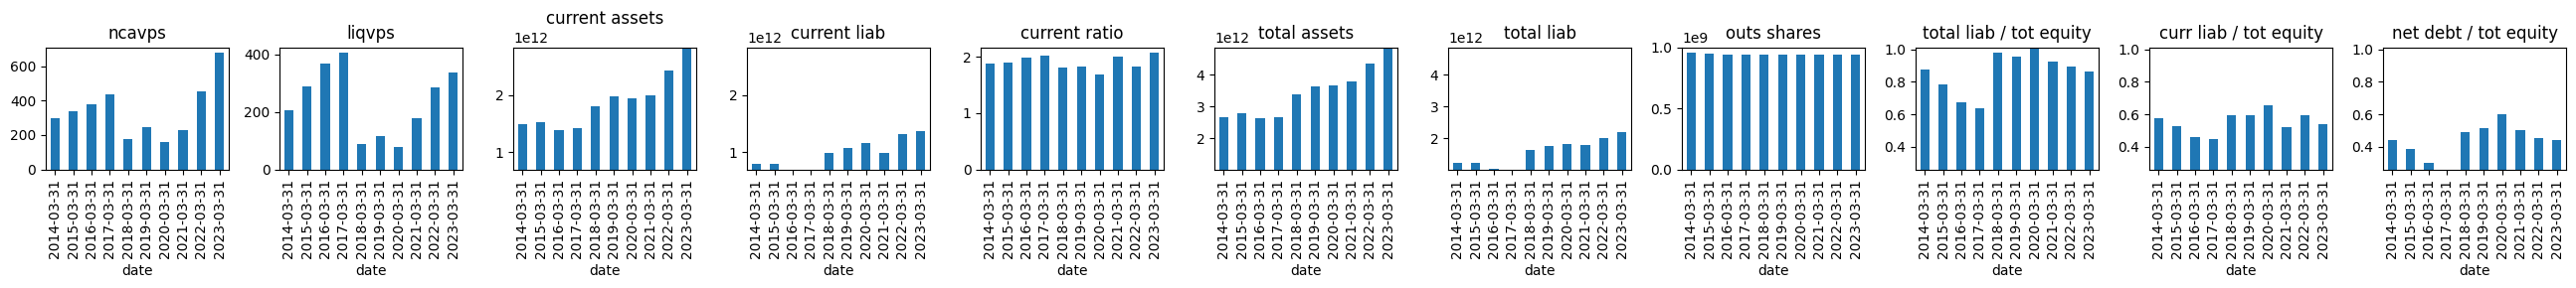

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 501/543 [19:29<02:15,  3.22s/it]

dates incoherence
KOTMF.	 Current price: 15.6.	 NCAV: 208.02011251057897.	 LIQV: 235.54413302135708


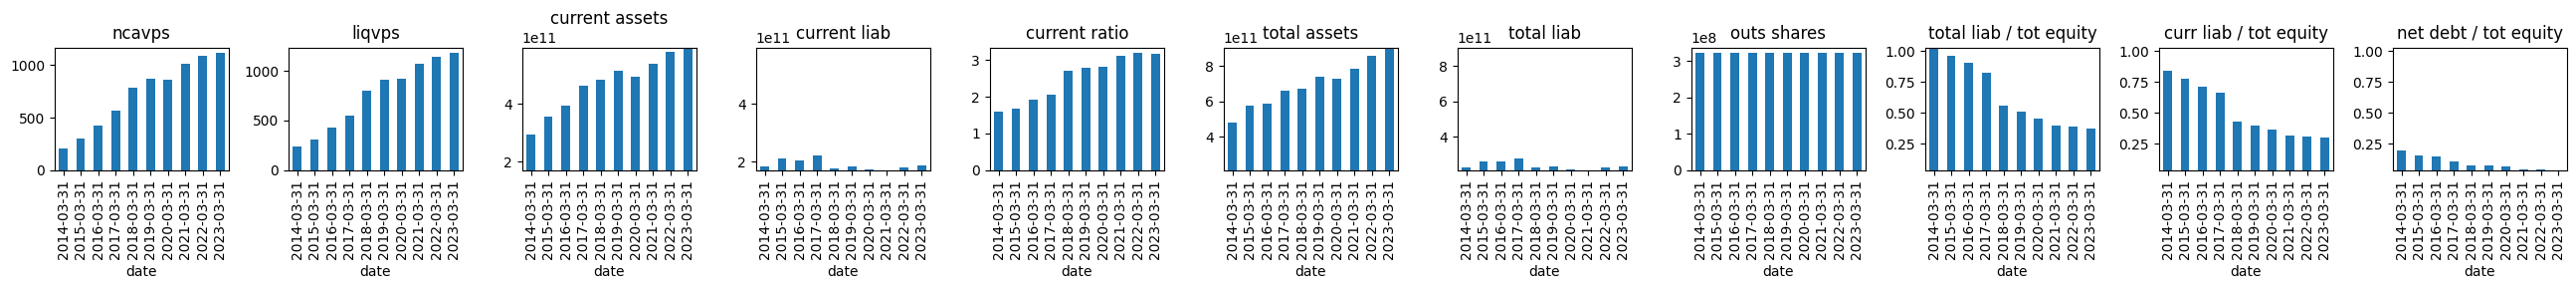

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 502/543 [19:34<02:33,  3.73s/it]

KOTMY.	 Current price: 15.07.	 NCAV: 208.02011251057897.	 LIQV: 235.54413302135708


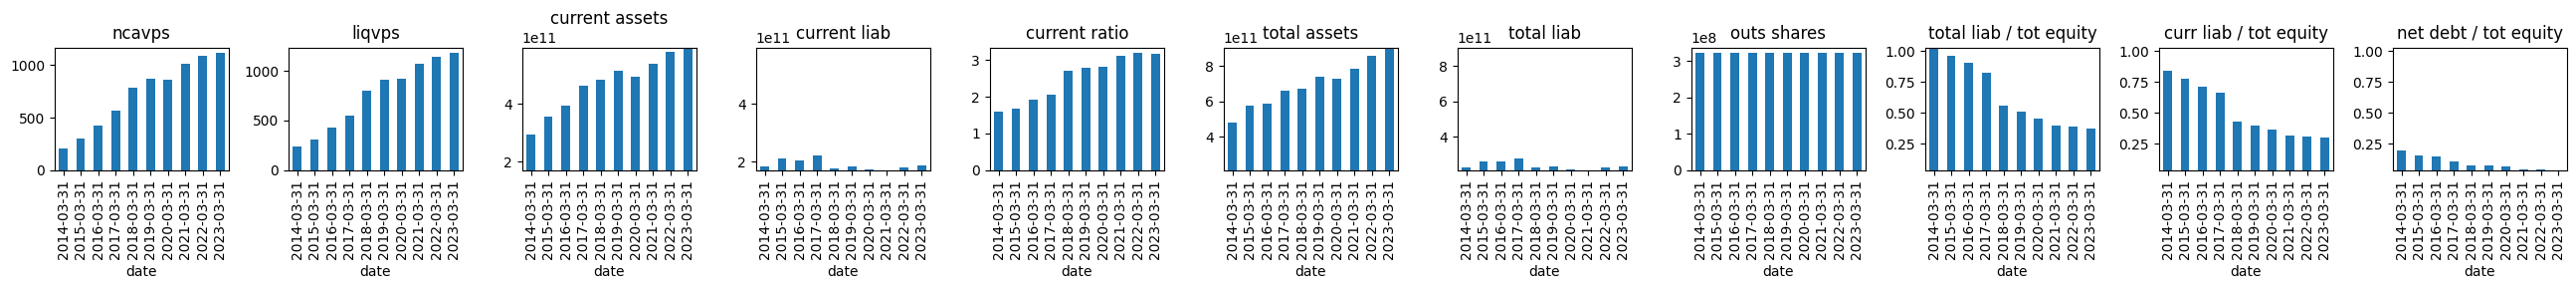

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 504/543 [19:41<02:10,  3.35s/it]

KPCPF.	 Current price: 3.76.	 NCAV: 313.23106766502593.	 LIQV: 146.05759925791597


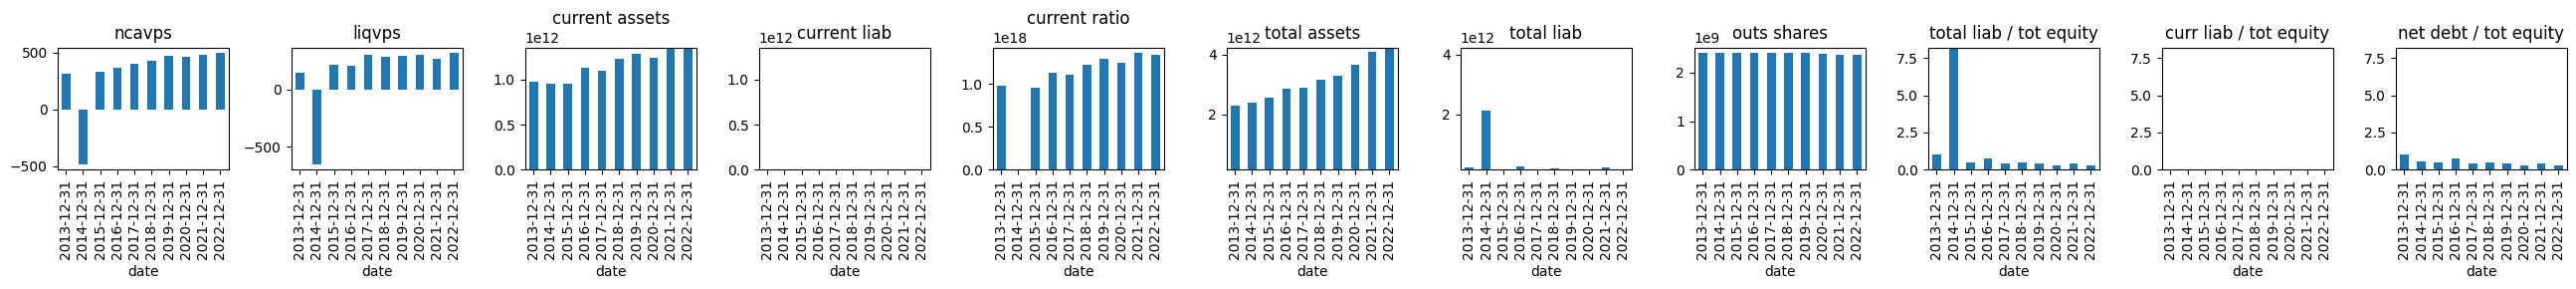

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 505/543 [19:45<02:22,  3.75s/it]

KPCPY.	 Current price: 15.79.	 NCAV: 1252.9242706601037.	 LIQV: 584.2303970316639


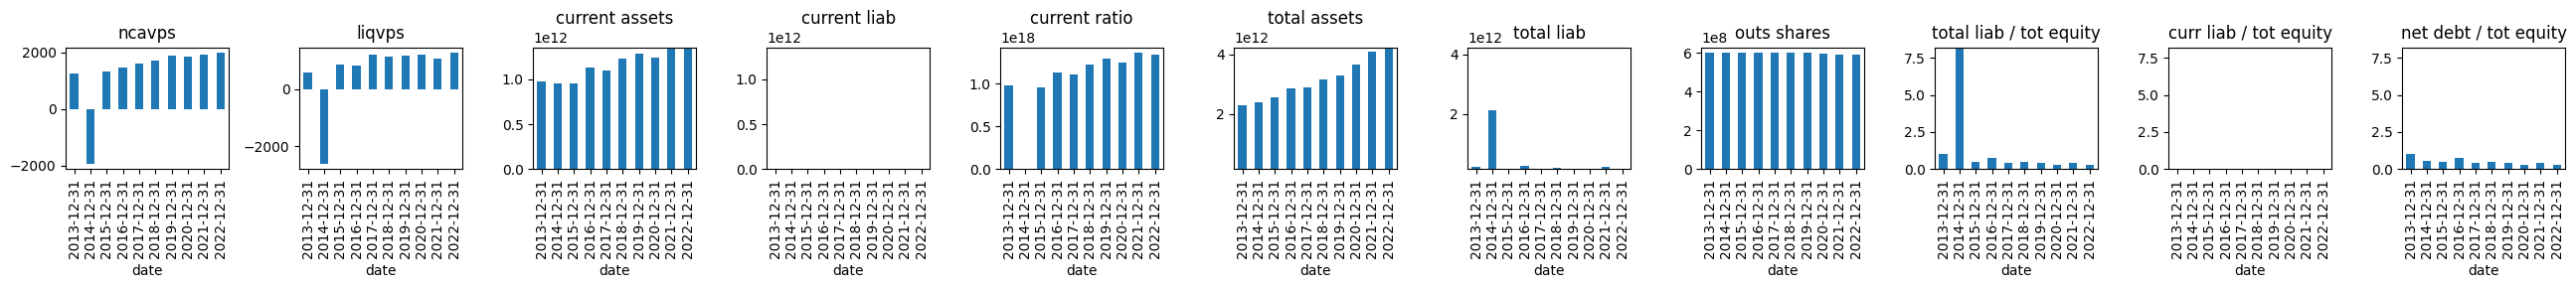

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 506/543 [19:50<02:26,  3.95s/it]

KPCUF.	 Current price: 3.785.	 NCAV: 313.23106766502593.	 LIQV: 146.05759925791597


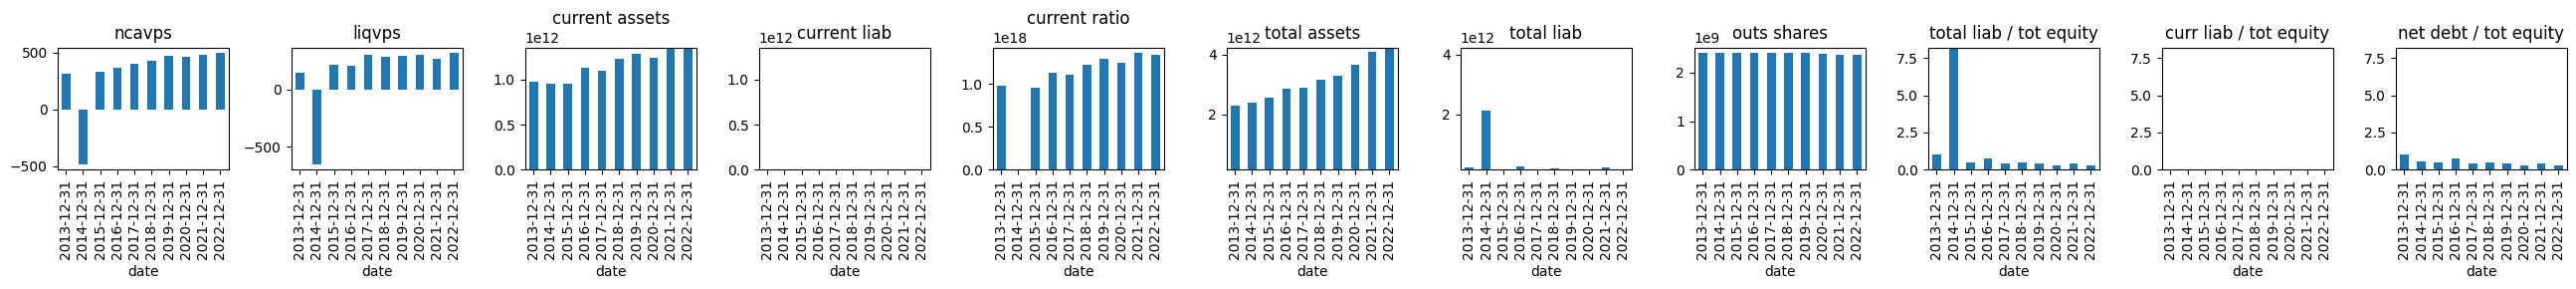

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 512/543 [20:04<01:07,  2.18s/it]

KSANF.	 Current price: 15.7.	 NCAV: 217.85128557328198.	 LIQV: 291.6330214631254


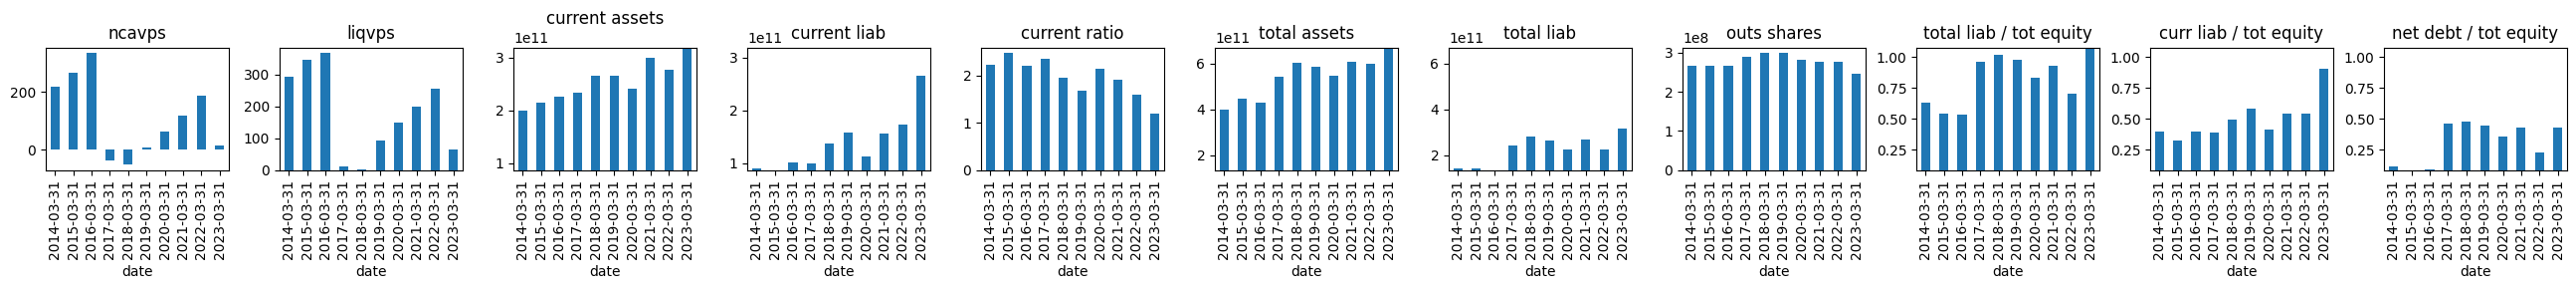

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 514/543 [20:11<01:19,  2.73s/it]

KSRYY.	 Current price: 14.175.	 NCAV: 214.03257874359065.	 LIQV: 151.9790017091632


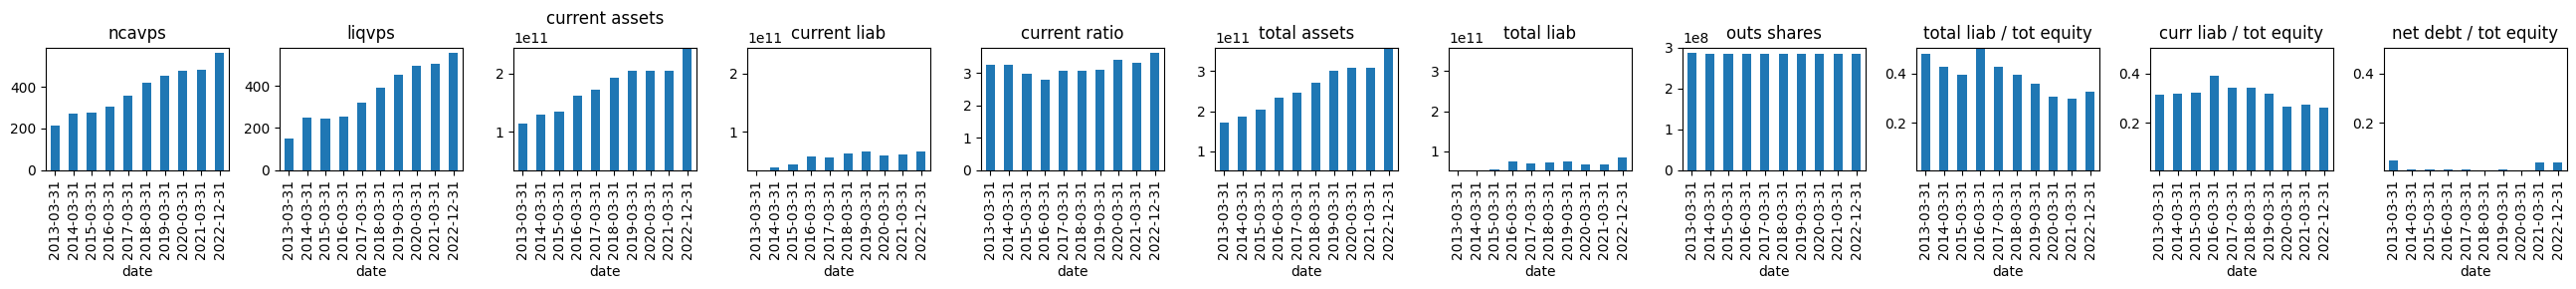

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 516/543 [20:18<01:21,  3.00s/it]

dates of last income statement and balance sheet are not the same for ticker KTF
	income stmt date: 2010-11-30, balance sheet date: 2015-11-30
KURRF.	 Current price: 11.34.	 NCAV: 204.83287586713087.	 LIQV: 296.60561496190354


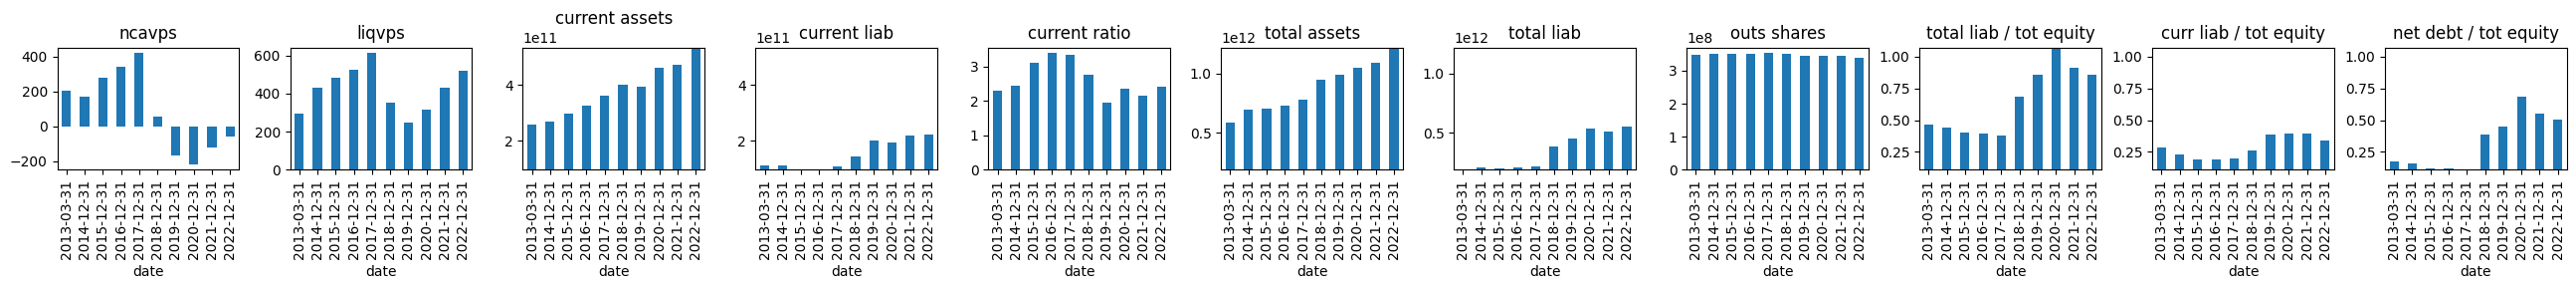

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 517/543 [20:23<01:29,  3.44s/it]

KWPCY.	 Current price: 32.45.	 NCAV: 299.6333228695658.	 LIQV: 227.31564288719835


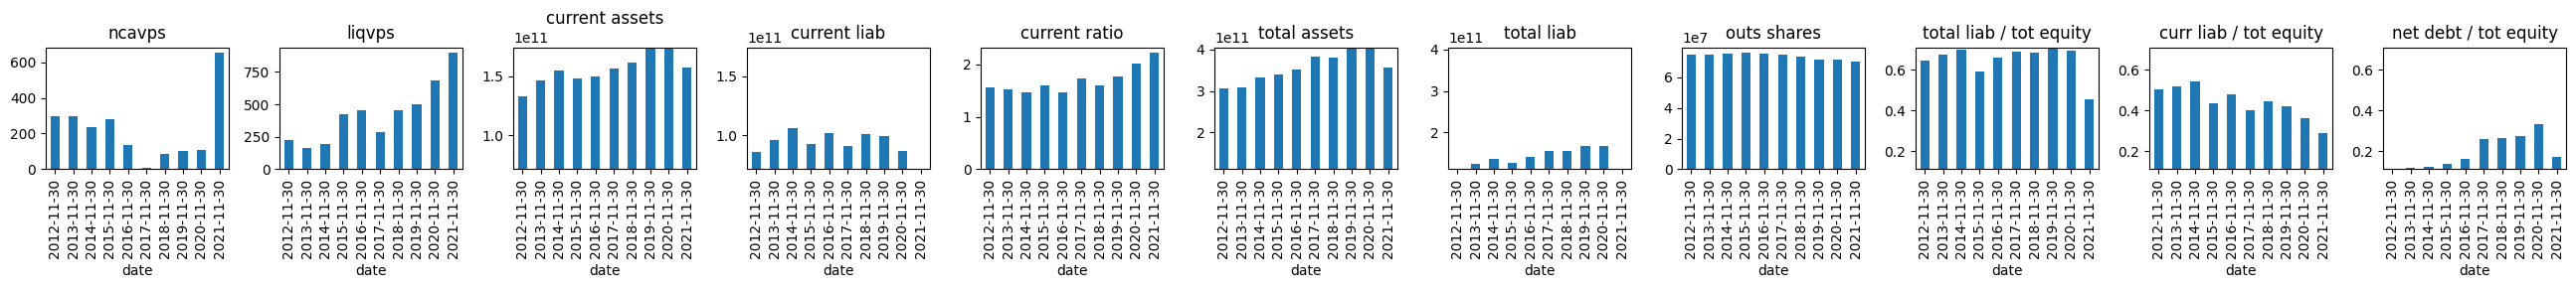

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 519/543 [20:29<01:17,  3.22s/it]

dates of last income statement and balance sheet are not the same for ticker KYCCF
	income stmt date: 2013-03-31, balance sheet date: 2012-06-30
KYOCF.	 Current price: 59.028.	 NCAV: 1956.9686430144573.	 LIQV: 1005.4645489435007


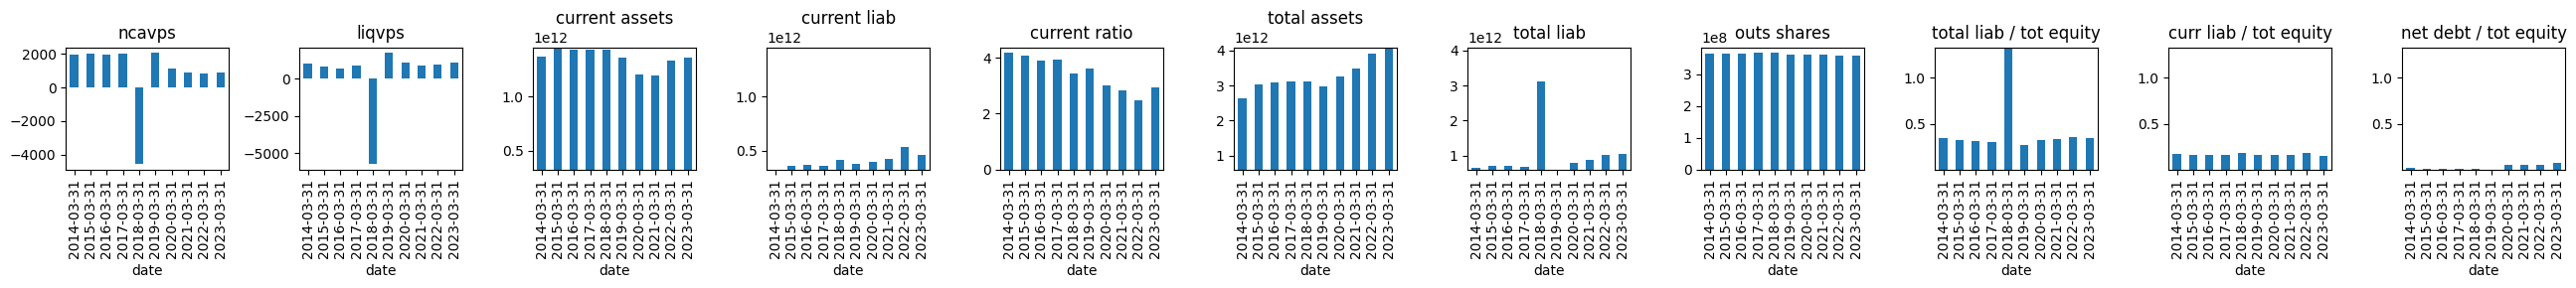

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 520/543 [20:34<01:24,  3.68s/it]

KYOCY.	 Current price: 57.24.	 NCAV: 1956.996834667871.	 LIQV: 1005.4790334413412


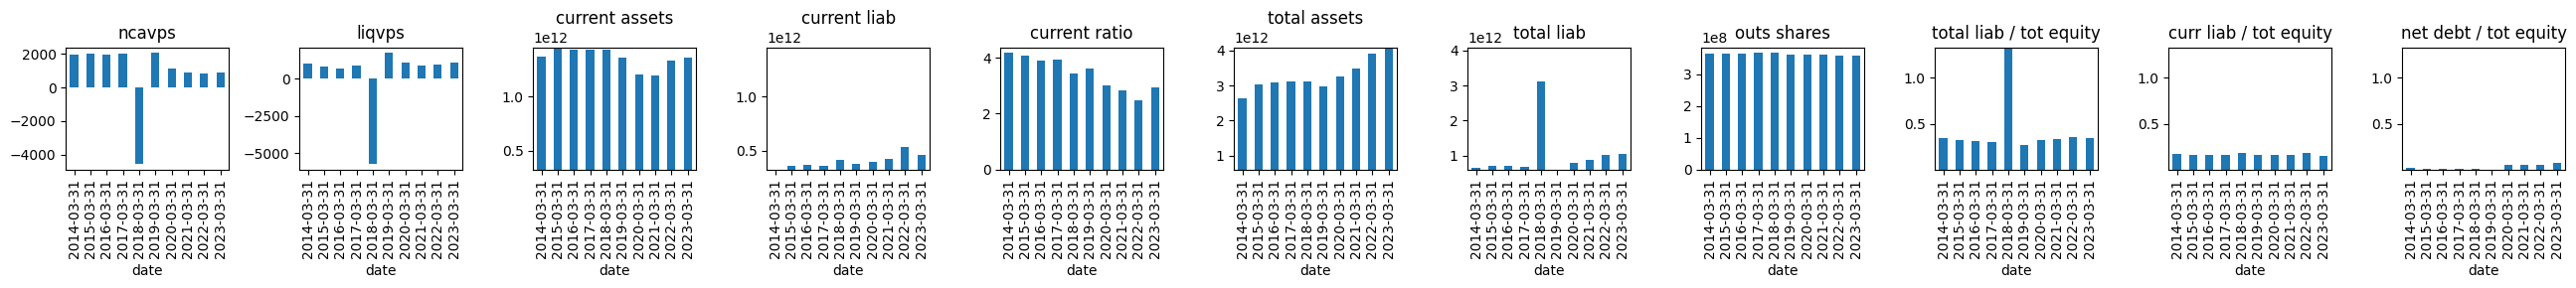

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 524/543 [20:41<00:35,  1.86s/it]

LADX.	 Current price: 1.23.	 NCAV: 185.79913532051515.	 LIQV: -349.110387099128


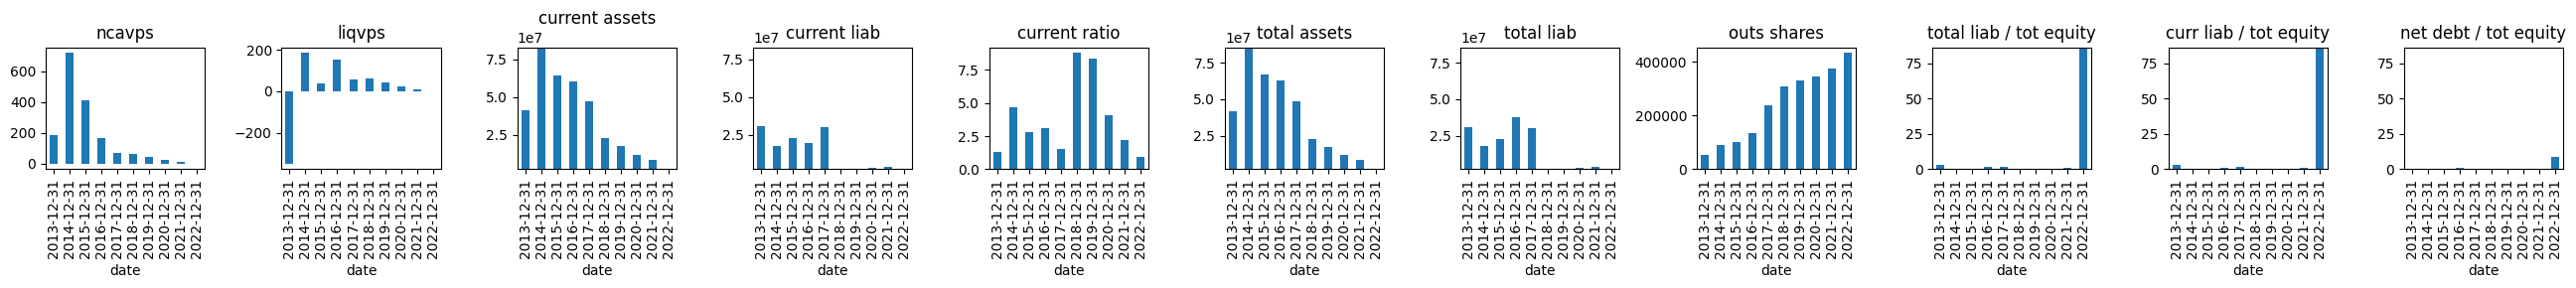

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 534/543 [21:00<00:17,  1.93s/it]

LGNZZ.	 Current price: 0.13.	 NCAV: 5.6241288885269825.	 LIQV: 0.14191557165862786


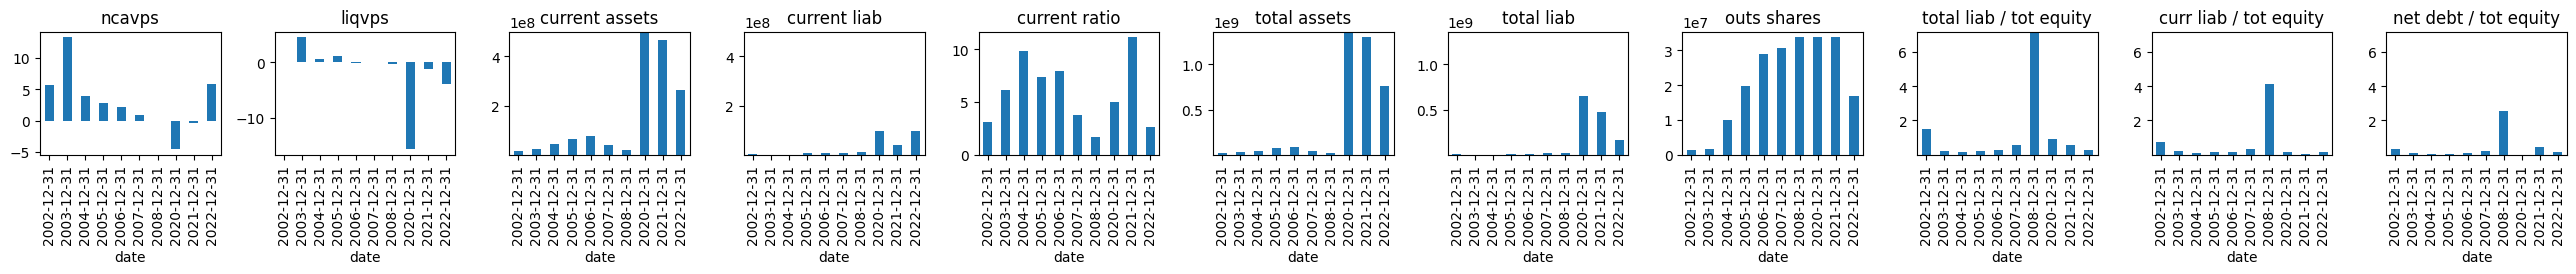

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 538/543 [21:07<00:07,  1.50s/it]

LIXTW.	 Current price: 0.0359.	 NCAV: 0.3409070905315771.	 LIQV: 0.22111648349111396


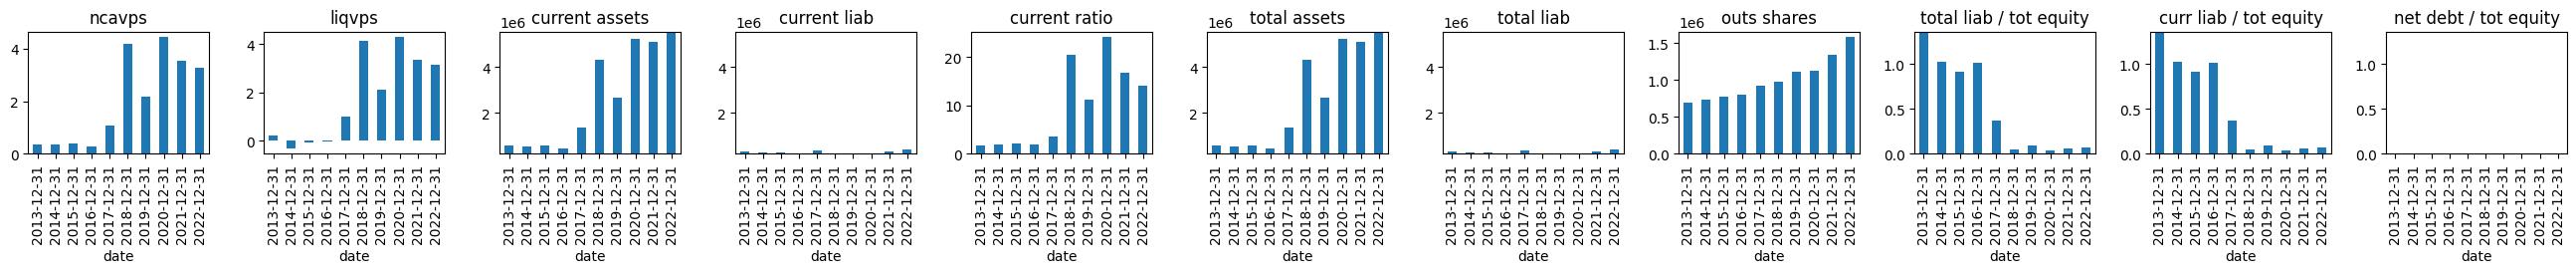

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 540/543 [21:14<00:07,  2.43s/it]

LKCO.	 Current price: 0.475.	 NCAV: 137.1468836077125.	 LIQV: 235.3780453953409


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 541/543 [21:18<00:05,  2.99s/it]

LOUIF.	 Current price: 0.01.	 NCAV: 2.084858836782863.	 LIQV: -5.915427556341433


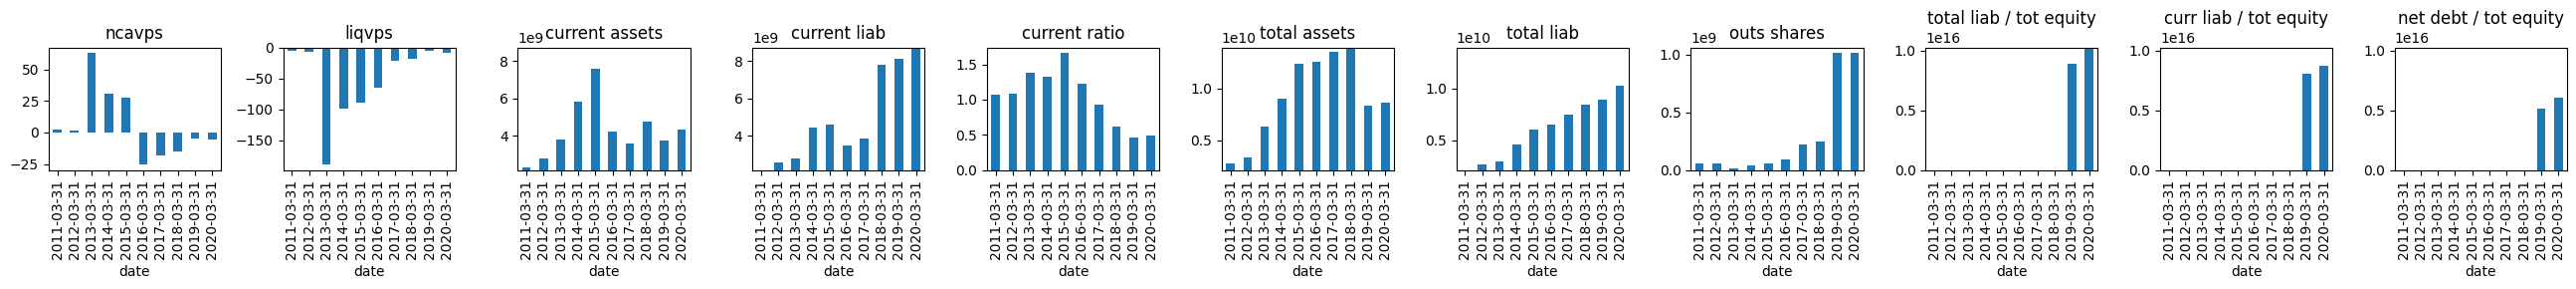

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [21:25<00:00,  2.37s/it]

CPU times: user 5min 51s, sys: 27.3 s, total: 6min 18s
Wall time: 21min 25s


In [92]:
%%time
# NEW CODE
# compute preliminary ncav (current assets - total liabilities)
preliminary_ncav = {}
zero_current_price = []
missed_ticker = []
tickers_to_accept = []
notes = {}
full_df = pd.DataFrame()

for ticker in tqdm(potential_candidates):
    data_balance_sheet = get_balance_sheet_info(ticker, 10)
    if len(data_balance_sheet) <= 5:
        continue
    data_income_stmt = get_income_stmt_info(ticker, 10)
    if len(data_income_stmt) <= 5:
        continue
    current_price = get_current_price(ticker)
    if current_price is None:
        continue
        
    latest_balance_sheet = data_balance_sheet[-1]
    latest_income_stmt = data_income_stmt[-1]
    latest_balance_sheet.update(
        {
            "weightedAverageShsOutDil": latest_income_stmt["weightedAverageShsOutDil"],
            "income_stmt_date": latest_income_stmt["date"],
        }
    )
    if latest_balance_sheet["date"] != latest_balance_sheet["income_stmt_date"]:
        print(f"dates of last income statement and balance sheet are not the same for ticker {ticker}")
        print(f"\tincome stmt date: {latest_balance_sheet['income_stmt_date']}, balance sheet date: {latest_balance_sheet['date']}")
        continue
    ncavps = compute_ncavps(latest_balance_sheet)
    liqvps = compute_liqvps(latest_balance_sheet, CURRENT_ASSETS_FACTORS)
    if (current_price > ncavps) and (current_price > liqvps):
        continue
    
    balance_sheet_df = pd.DataFrame(data_balance_sheet)
    income_stmt_df = pd.DataFrame(data_income_stmt)
    balance_sheet_df = balance_sheet_df.set_index("date")
    income_stmt_df = income_stmt_df.set_index("date")
    balance_sheet_df = balance_sheet_df[bs_cols]
    income_stmt_df = income_stmt_df[is_cols]
    
    try:
        fs_df = pd.concat([balance_sheet_df, income_stmt_df], axis=1, join="inner")
    except:
        print("dates incoherence")
        continue
    
    fs_df = fs_df.iloc[::-1] # from oldest to newest
    # compute NCAV
    fs_df["ncavps"] = fs_df.apply(compute_ncavps, axis=1)
    # compute LIQV
    fs_df["liqvps"] = fs_df.apply(compute_liqvps, args=(CURRENT_ASSETS_FACTORS,), axis=1)
    # compute current ratio
    fs_df["current_ratio"] = fs_df.apply(compute_current_ratio, axis=1)
    # compute de ratio 1
    fs_df["de_ratio1"] = fs_df.apply(compute_de_ratio, args=("totalLiabilities",), axis=1)
    # compute de ratio 2
    fs_df["de_ratio2"] = fs_df.apply(compute_de_ratio, args=("totalCurrentLiabilities",), axis=1)
    # compute de ratio 3
    fs_df["de_ratio3"] = fs_df.apply(compute_de_ratio, args=("totalDebt",), axis=1)

    # plot indicators
    print(f"{ticker}.\t Current price: {current_price}.\t NCAV: {ncavps}.\t LIQV: {liqvps}")
    plot_indicators_ncav(fs_df)

    full_df = pd.concat([full_df, fs_df.tail(1)])

    time.sleep(1)

# OLD

In [ ]:
%%time
# NEW CODE
# compute preliminary ncav (current assets - total liabilities)
preliminary_ncav = {}
zero_current_price = []
missed_ticker = []
tickers_to_accept = []
notes = {}

for ticker in tqdm(TICKERS):
    
    url_balance_sheet = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?limit=1&apikey={KEY}"
    url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=1&apikey={KEY}"
    url_price = f"https://financialmodelingprep.com/api/v3/quote/{ticker}?limit=1&apikey={KEY}"
    
    try:
        response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
        response_price = urlopen(url_price, cafile=certifi.where())
    except:
        missed_ticker.append(ticker)
        continue
    
    data_balance_sheet = response_balance_sheet.read().decode("utf-8")
    data_balance_sheet = json.loads(data_balance_sheet)
    if len(data_balance_sheet) == 0:
        continue # here we should log the ticker with this issue
    data_balance_sheet = data_balance_sheet[-1]
    flag = compute_prelim_ncav(data_balance_sheet)
    data_price = response_price.read().decode("utf-8")
    data_price = json.loads(data_price)
    if len(data_price) == 0:
        continue # here we should log the ticker with this issue
    data_price = data_price[-1]
    current_price = data_price["price"]
    if flag:
        
        tickers_to_accept.append(ticker)
        response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
        data_income_stmt = response_income_stmt.read().decode("utf-8")
        data_income_stmt = json.loads(data_income_stmt)
        if len(data_income_stmt) == 0:
            continue # here we should log the ticker with this issue
        data_income_stmt = data_income_stmt[-1]
        data_balance_sheet.update(
            {
                "weightedAverageShsOutDil": data_income_stmt["weightedAverageShsOutDil"],
                "income_stmt_date": data_income_stmt["date"],
            }
        )
        if data_balance_sheet["date"] != data_balance_sheet["income_stmt_date"]:
            print(f"dates of last income statement and balance sheet are not the same for ticker {ticker}")
            print(f"\tincome stmt date: {data_balance_sheet['income_stmt_date']}, balance sheet date: {data_balance_sheet['date']}")
            continue
            
        ncavps = compute_ncavps(data_balance_sheet)
        liqvps = compute_liqvps(data_balance_sheet, factors)
        if current_price is None : 
            zero_current_price.append(ticker)
            continue
        notes[ticker] = {
            "current_price": current_price,
            "below_ncav": current_price < ncavps,
            "below_liqv": current_price < liqvps,
        }

Transform dict into pandas and add "below_both" and "below_none" cols. below_both is a flag that tells whether the current price is below both ncav and liqv. below_none is a flag that tells whether the current price is above both ncav and liqv. 

In [ ]:
price_to_liquid_df = pd.DataFrame(notes).T
price_to_liquid_df["below_both"] = price_to_liquid_df.apply(lambda x: x["below_ncav"] and x["below_liqv"], axis=1)
price_to_liquid_df["below_none"] = price_to_liquid_df.apply(lambda x: x["below_ncav"] == False and x["below_liqv"] == False, axis=1)
price_to_liquid_df.sample(5)

We filter out the rows having a `below_none` value of True. This represents the rows where the company's current price is above both ncav and liqv

In [ ]:
price_to_liquid_df = price_to_liquid_df.loc[price_to_liquid_df["below_none"] != True]
price_to_liquid_df.shape

In [ ]:
len(tickers_to_accept)

In [ ]:
selected_tickers = list(price_to_liquid_df.index)

* cashAndCashEquivalents
* netReceivables
* inventory
* propertyPlantEquipmentNet
* totalCurrentAssets
* totalLiabilities

### The following values will be computed/extracted over a 10 year period:

- NCAV
- LIQV
- Current Assets
- Current Liab
- Current Ratio
- Total Assets
- Total Liabs
- Shares outstanding
- Total Liab / Total Shareholders' Equity (D/E ratio 1)
- Current Liab / Total Shareholders' Equity (D/E ratio 2)
- Total debt / Total Shareholders' Equity (D/E ratio 3)
- date

In [ ]:
%%time
missed_tickers = []
full_df = pd.DataFrame()
for ticker in selected_tickers:
        
    data_income_stmt = get_income_stmt_info(ticker=ticker, nb_years=10)
    data_balance_sheet = get_balance_sheet_info(ticker=ticker, nb_years=10)

    if len(data_balance_sheet) == 0 or len(data_income_stmt) == 0:
        print("length equals zero")
        missing_tickers.append(ticker)

    if len(data_balance_sheet) < 5 or len(data_income_stmt) < 5:
        print("less than 5 reports")
        time.sleep(1)
        continue

    balance_sheet_df = pd.DataFrame(data_balance_sheet)
    income_stmt_df = pd.DataFrame(data_income_stmt)
    balance_sheet_df = balance_sheet_df.set_index("date")
    income_stmt_df = income_stmt_df.set_index("date")
    balance_sheet_df = balance_sheet_df[bs_cols]
    income_stmt_df = income_stmt_df[is_cols]
    
    try:
        fs_df = pd.concat([balance_sheet_df, income_stmt_df], axis=1, join="inner")
    except:
        print("dates incoherence")
        continue
    
    fs_df = fs_df.iloc[::-1] # from oldest to newest
    # compute NCAV
    fs_df["ncavps"] = fs_df.apply(compute_ncavps, axis=1)
    # compute LIQV
    fs_df["liqvps"] = fs_df.apply(compute_liqvps, args=(factors,), axis=1)
    # compute current ratio
    fs_df["current_ratio"] = fs_df.apply(compute_current_ratio, axis=1)
    # compute de ratio 1
    fs_df["de_ratio1"] = fs_df.apply(compute_de_ratio, args=("totalLiabilities",), axis=1)
    # compute de ratio 2
    fs_df["de_ratio2"] = fs_df.apply(compute_de_ratio, args=("totalCurrentLiabilities",), axis=1)
    # compute de ratio 3
    fs_df["de_ratio3"] = fs_df.apply(compute_de_ratio, args=("totalDebt",), axis=1)

    # plot indicators
    print(ticker)
    plot_indicators(fs_df)

    full_df = pd.concat([full_df, fs_df.tail(1)])

    time.sleep(1)

In [ ]:
%%time
missed_tickers = []
full_df = pd.DataFrame()
for ticker in selected_tickers:
    # define urls
    url_balance_sheet = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?limit=10&apikey={KEY}"
    url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=10&apikey={KEY}"

    try:
        # load data
        response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
        response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
    except:
        missed_tickers.append(ticker)
        
    data_balance_sheet = response_balance_sheet.read().decode("utf-8")
    data_balance_sheet = json.loads(data_balance_sheet)
    if len(data_balance_sheet) < 5:
        continue

    data_income_stmt = response_income_stmt.read().decode("utf-8")
    data_income_stmt = json.loads(data_income_stmt)
    if len(data_income_stmt) < 5:
        continue
        
    balance_sheet_df = pd.DataFrame(data_balance_sheet)
    income_stmt_df = pd.DataFrame(data_income_stmt)
    balance_sheet_df = balance_sheet_df.set_index("date")
    income_stmt_df = income_stmt_df.set_index("date")
    balance_sheet_df = balance_sheet_df[bs_cols]
    income_stmt_df = income_stmt_df[is_cols]

    fs_df = pd.concat([balance_sheet_df, income_stmt_df], axis=1, join="inner")
    fs_df = fs_df.iloc[::-1] # from oldest to newest
    # compute NCAV
    fs_df["ncavps"] = fs_df.apply(compute_ncavps, axis=1)
    # compute LIQV
    fs_df["liqvps"] = fs_df.apply(compute_liqvps, args=(factors,), axis=1)
    # compute current ratio
    fs_df["current_ratio"] = fs_df.apply(compute_current_ratio, axis=1)
    # compute de ratio 1
    fs_df["de_ratio1"] = fs_df.apply(compute_de_ratio1, axis=1)
    # compute de ratio 2
    fs_df["de_ratio2"] = fs_df.apply(compute_de_ratio2, axis=1)
    # compute de ratio 3
    fs_df["de_ratio3"] = fs_df.apply(compute_de_ratio3, axis=1)

    # plot indicators
    print(ticker)
    plot_indicators(fs_df)

    full_df = pd.concat([full_df, fs_df.tail(1)])

    time.sleep(1)

In [ ]:
# stocks selected by hand after visualization of the previous plots
selection = [
    "WILC",
    "HURC",
    "UFI",
    "UEIC",
    "STRT",
    "CNRD",
    #"JRSH",
    "JCTCF",
    "PFHO",
    "BNSO",
    "SSY",
]

In [ ]:
price_df = price_to_liquid_df.loc[selection, ["current_price"]]
price_df

In [ ]:
selection_df = full_df[full_df["symbol"].isin(selection)].reset_index().set_index("symbol")
selection_df

In [ ]:
selection_resumed_df = pd.concat([price_df, selection_df[["ncavps", "liqvps", "current_ratio", "de_ratio1", "de_ratio2", "de_ratio3", "date"]]], axis=1, join="inner")

In [ ]:
selection_resumed_df["price_to_ncav"] = selection_resumed_df["current_price"] / selection_resumed_df["ncavps"]
selection_resumed_df["price_to_liqv"] = selection_resumed_df["current_price"] / selection_resumed_df["liqvps"]

In [ ]:
selection_resumed_df.sort_values(by="price_to_ncav")

In [ ]:
selection_resumed_df.sort_values(by="price_to_liqv")

In [ ]:
# stocks selected by hand after visualization of the previous plots
snd_selection = [
    "GIFI",
    "ADES",
    "UTSI",
    "NTWK",
    "GIGM",
    "MSN",
    "WAFU",
    "JVA",
    "EVOL",
    "QBAK",
]

In [ ]:
snd_price_df = price_to_liquid_df.loc[snd_selection, ["current_price"]]
snd_price_df

In [ ]:
snd_selection_df = full_df[full_df["symbol"].isin(snd_selection)].reset_index().set_index("symbol")
snd_selection_df

In [ ]:
snd_selection_resumed_df = pd.concat([snd_price_df, snd_selection_df[["ncavps", "liqvps", "current_ratio", "de_ratio1", "de_ratio2", "de_ratio3", "date"]]], axis=1, join="inner")

In [ ]:
snd_selection_resumed_df["price_to_ncav"] = snd_selection_resumed_df["current_price"] / snd_selection_resumed_df["ncavps"]
snd_selection_resumed_df["price_to_liqv"] = snd_selection_resumed_df["current_price"] / snd_selection_resumed_df["liqvps"]

In [ ]:
snd_selection_resumed_df.sort_values(by="price_to_ncav")

In [ ]:
snd_selection_resumed_df.sort_values(by="price_to_liqv")

In [ ]:
thd_selection = [
    "CSTE",
    "CNRD",
    "GIFI",
    "UTSI",
    "GURE",
    "GIGM",
    "MSN",
    "JVA",
    "QBAK",
]

In [ ]:
thd_price_df = price_to_liquid_df.loc[thd_selection, ["current_price"]]
thd_price_df

In [ ]:
thd_selection_df = full_df[full_df["symbol"].isin(thd_selection)].reset_index().set_index("symbol")
thd_selection_df

In [ ]:
thd_selection_resumed_df = pd.concat([thd_price_df, thd_selection_df[["ncavps", "liqvps", "current_ratio", "de_ratio1", "de_ratio2", "de_ratio3", "date"]]], axis=1, join="inner")

In [ ]:
thd_selection_resumed_df["price_to_ncav"] = thd_selection_resumed_df["current_price"] / thd_selection_resumed_df["ncavps"]
thd_selection_resumed_df["price_to_liqv"] = thd_selection_resumed_df["current_price"] / thd_selection_resumed_df["liqvps"]

In [ ]:
thd_selection_resumed_df.sort_values(by="price_to_ncav")

In [ ]:
thd_selection_resumed_df.sort_values(by="price_to_liqv")

### Stocks To dig into

In [ ]:
int_selection = [
    "JCTCF",
    "IVAC",
    "ADES",
    "VHC",
    "CVR",
    "GSMG",
    "BNSO",
    "GIFI",
    "USNU",
    "NCSM",
    "WILC",
    "GIGM",
    "STRT",
    "HURC",
    "MSN",
    "NTWK",
    "SSY",
    "SKAS",
    "CAAS",
    "UFI",
    "CSTE",
    "JVA",
    "TOFB",
]

In [ ]:
int_price_df = price_to_liquid_df.loc[int_selection, ["current_price"]]
int_price_df

In [ ]:
int_selection_df = full_df[full_df["symbol"].isin(int_selection)].reset_index().set_index("symbol")
int_selection_df

In [ ]:
int_selection_resumed_df = pd.concat([int_price_df, int_selection_df[["ncavps", "liqvps", "current_ratio", "de_ratio1", "de_ratio2", "de_ratio3", "date"]]], axis=1, join="inner")

In [ ]:
int_selection_resumed_df["price_to_ncav"] = int_selection_resumed_df["current_price"] / int_selection_resumed_df["ncavps"]
int_selection_resumed_df["price_to_liqv"] = int_selection_resumed_df["current_price"] / int_selection_resumed_df["liqvps"]

In [ ]:
int_selection_resumed_df.sort_values(by="price_to_ncav")

In [ ]:
int_selection_resumed_df.sort_values(by="price_to_liqv")

### Set of questions that I should ask myself after I have identified potentially good opportunities

* Do I know why the company is undervalued?
* Is the reason for the company to be undervalued transitory?
* Which percentage of the company operations are in China?
* Does the company work in one of the industries that I discard?
* Does the company have significant off-balance sheet liabilities?
* What type of inventory and receivables does the company have?
* Am I certain of the calculations?
* Has the company been trading below liq value for a long time?

### How to transform those questions into prompts to feed a LLM-based search engine ?

* are there any recent negative news about the company {COMPANY_NAME}?
* have there been any recent scandals or controversies involving {COMPANY_NAME}?
* Are there any pending lawsuits or legal issues involving {COMPANY_NAME}?
    * What is the current status on the lawsuit?
    * Go deeper in this one ...
* recent stock catalysts for {COMPANY_NAME}
    * Have there been any recent developments or announcements related to {COMPANY_NAME}' products or services
    * is there any recent news about merge and acquisitions regarding {COMPANY_NAME}?
    * Dig deeper on this one
* are there insiders stock purchases in {COMPANY_NAME}?

## Analyzed Companies

*Date : 20/06/2023*

**WILC** : 

- bunch of scandals : funds malversation in 2006, 2009, 2016 and they have ongoing processes
- I think not a good investment 

**SSY** : 

- They stopped their repurchase plan in 2020 cuz of COVID
- Reduced demand for certain hospital services
- Not a clear vision on how/when the conditions will go back to normal
- Should go down for it to be a more attractive investment. At 0.72 it'll have a MOS of 33% to NCAV

**EVOL** : 

- Former CEO quit but still part of the board of directors. I think not a big issue
- They sold their two main business operations in Jan 2022
- Dutch auction tender offer june 2022 (shares buyback sort of)
- They'll be a R&D company for now in Machine Learning and similar fields
- Very cheap (price/ncav of 26% so 74% discount), but should have a more clear business model or catalyst for it to be worth it
- 
- They're buying back shares and ncav as of 29/08/2023 is 2.6 vs price of 0.56

*Date 21/06/2023*

**GIGM** : 
* Decreasing total revenues
* The stock is often trading below liquidation value. Last time above liqvps was 15/08/2021. Another run was aug 2022 but not above liqv or ncav
* On 2014 they published in their financial statement of 2013 that they're sentitive to copyright infringement. There might be a correlation between this and the decline, but not sure
* They want to expand through companies purchases (M&A) so this is going to burn the cash and current assets a bit if any of the opportunities is seized
* Burn rate of around 10%
* According to its last run til 1.87, I estimate that the company should trade at around 1.15 to make a safe 50% if the stock goes all the way up til 1.7 (conservative estimation since the ncavps is 4.024298 and liqvps is 3.258609)
*
* As of 29/08/2023 they're ncav is 3.9 and price is 1.4 

*Date 26/06/2023*

**MSN** : 

* It's a company that does not disclose much information
* The performance has been weaker and weaker since 2015 (judging by ncav)
* information about how sensitive they are to copyright infringement if it happens
* Control of Emerson Radio Corp changed twice since 2016
* No news of potential catalyst (positive of negative)
* if next burn rate of 12% (burn rate between 2021 and 2022) the price to ncavps will still be 0.49 (51% discount)


*Date 27/06/2023*

**ADES**:

* Violation of some GAAP stuff in 2017. In January 2022 a fair fund approved to pay the "harmed" investors -> The doc was published in Jan 2023. ADES had to pay some money to the SEC. It's settled
* Appointment of a new member to the board of directors that might bring relevant expertise 
* Company provides solutions to coal-powered plants but seems like more on limiting pollution. No clear track of ADES affected by contamination scandals
* They bought Arq Limited in august 2022. That might have hit a bit the price.
* Big flop in earnings reports (-220%) of May.
* Value is there when using data of dec 2022
* They diluted shares in 2023



*Date 28/06/2023*

**GURE**

* Chinese

**UTSI**

* Chinese

**USNU**

* court case in 2010 with another company but not a scandal type of thing
* court case in 2020 for improper billing practices and they had to pay 1M
* burn rate of 16%
* in the last two years it has reached ncav levels
* Below 0.05 could be attractive (at 0.05 it would have a MOS of 30%)

*Date 29/06/2023*

**JRSH**

* Actual ncavps is 3.39837
* Actual liqvps is 3.21024
* It was constantly growing until the last report two days ago
* lower sales from two major U.S. customers
* shipments being deferred by customers to the fiscal 2024
* shift in product mix to lower margin items (??? dont' know if of customers or company)
* according to CEO:  retail continues face a weak economic env, consumers limiting spending on higher priced items
* They're looking to expand/grow
* 2024 might be the same as 2023
* focused on expanding their customer base, increasing production capacity, and improving operational efficienc
* acquired property in 2019 that they plan to develop as market conditions improve
* Should fall below 2.2 to be more attractive in current conditions

*Date 30/06/2023*

**JVA**

* Bought Steep N Brew in 2018 and in 2022 the announced they got rid of it cuz not that profitable
* They increased debt (long term debt)
* They will be acquired by Delta Corp Holdings Limited, but they aren't a public company -> better to steer away from it

**NCSM**

* changes in its leadership and management team after CEO retirement
* a couple of lawsuits one settled in 2020 and the other won 2022
* They acquired Spectrum Tracer Services in 2017
* I don't know why it is undervalued wrt both ncav and liqv <------
* At current date it is at 30% discount of NCAV (17). Recheck around 15
* They incresed a lot their liabilities and now their NCAV (23-08-23) is around 5

*Date 04/07/2023*

**STRT**

* They are diluting some shares
* Gross profit decreasing since 2021
* Their net income goes up and down
* One case in 1997 where STRT filed a lawsuit against General Automotive for infringement but no infringement was found
* one case in 2006 apparently but not much info found
* They sold their 1/3rd stake in a joint venture and gained full control of the other joint venture they had with the same company (at least under the restructuring agreement I read about)
* They have relatively solid customers like Hyundai/Kia, Ford, GM
* They plan to explore and execute targeted mergers and acquisitions in the foreseable future (direction not specified)
* Mergin is low: now it is a 15% of discount relative to NCAV. Recheck if stock price goes below 17

*Date 05/07/2023*

**HURC**

* They're buying back shares
* They increased dividend payment and their payout ratio is above 100%
* Significantly high institutional ownership (61%) -> stock price might be sensitive to their trading actions
* They bought a company in 2019
* For a margin of safety of around 33% check below 19
* Their NCAV is growing but they are not growing sales or income

**SKAS**
* NCAV trending upwards
* gros profit recovering pre-covid values
* Net income getting better (higher)
* Stable outstanding shares
* In 2016 they acquired an aircraft maintenance services company
* Lawsuit filed against SKAS in 2021 but no further information about it
* SKAS' subsidiary bought by a company on sept 2022 -> SKAS will not engage in any business involving the operation of a fixed based operation supplying aviation fuels and lubricants or the supply of other goods or provision of services typically supplied or performed at fixed base operations at airports at any facility located within one hundred (100) miles of the Garden City Regional Airport in Garden City, Kansas
* Got a concession to operate exclusively in a manhattan heliport on April 30, 2023 -> I Think this contract was cancelled due to conflic of interest
* Now the company is trading at a 25% discount to NCAV
*
* NCAV 6.4 & LIQV 6.1 on 26/08/23
* Had a negative quarter in march 2023 and now positive again
* Trading at 13% of current ncav and 21% of projected ncav @ 10% growth in 2024. Re-assess @ 5

*Date 26/07/2023*

**JCTCF**

* They closed their Jewett-Cameron Seed Company (JCSC) subsidiary cuz flat revenues and rising operating costs
* Buying back shares
* affected by higher cost from China and all accross the US since after covid
* Unable to pass costs to consumers
* ex CFO was bullish in mid-2022 (seekingalpha articles) and stock is cheaper now
* No inside purchases
* 59% of outs shared owned by institutions
* stock price should fall below 4 to have a MOS of in 2024 of 33% (including growth projections)

*Date 02/08/2023*

**VHC**

* NCAV is 2.12 and LIQV is 1.2 -> mos of 0.78 (ncav) and 0.61 (liqv)
* They lost 2 patents in court that vhc has accused Apple of infringing. News came out at end of march 2023
* It seems that the grow in NCAV is due to the money that Apple paid to them after the first court verdict
* They declared a special dividend of 1$ per share at the end of march -> negative for the valuation but won't be constant
* VHC committed to promptly distribute to shareholders 80% of future proceeds, if any, and net of related legal costs, licensing costs and taxes, that it receives from its current litigation with Apple
* On june 2023, They signed an NDA with a company/holding to sell their products
* Kendall Larsen, President & CEO purchased stocks in the open market on june 2023 and on may 2023, others from the board bought too (between 0.38 & 0.44)
* This look like a buy

*Date 03/08/2023*

**GIFI**

* They got inot shipyards in 2016 that didn't turn as profitable as expected. They started steering away from it in 2019
* Lawsuit in january 2023 for wrongful termination of a contract. If they lose I think they'll have to pay something. The trial is expected to take place on October 16th, 2023
* There are some talks with one of the institution holders to see how to improve the stock perf, among other things (news from june 2023)
* People from the obard have exercised (bought) stocks at around 3.25 on june 1st, 2023
* Today is just slightly below ncav. It should be below 2.4 for a mos of 33% -> To recheck after the trial of October 16th, 2023

*Date 24/08/2023*

**TOFB**

* The latest NCAV is slightly lower than the one from Dec 2022 (0.63 vs 0.67)
* MOS of 33% from 0.63 @ 0.41
* The 10y trend in upwards
* Mostly stable shared outstanding
* They received notification that they should stay 10 consecutive days with market cap > 5M to stay in OTCX, otherwise they'll go to OTCB
* Revenues are lower than same period last year
* net income is negative since june 2022
* They increase inventory since 2022 but it's been like that for the last 5 quarters (product eventually expires but maybe they just increased production & distribution capabilities
* As a general note I should learn how to identify when a company increases production / distribution capabilities by looking at their financial statement :)

*25/08/2023*

**CVR**

* The company pays dividends every quarter but they cut it from 0.22 to 0.10 per share
* Last NCAV is 16.7. Should be around 11 for a MOS of 33%
* Their ncav and assets are growing for 10 years
* Slight decrease of revenues. Negative net income since december 2022
* Stable shares
* No inisiders purchases
* They have been granted permission to build stuff for a medical application
* Quite silent company in the news

**NTWK**

* Stable nb of shares
* First positive quarter (net income) since march 2022
* Their assets are decreasing but their liabilities are also decreasing
* Recognized by Monitor Daily in ‘Most Innovative Companies in the Equipment Finance Ecosystem’ on April 2023
* They earned a AWS CloudFormation Badge for their expertise in the stuff on April 2023
* They earned Buy Rating from StockNews.com -> perhaps positive sentiment
* The president purchased stocks @ 2.19 for a total of 400K+ on 06/26/2023. And he purchased a lot more earlier this year
* I generally like it. NCAV 1.97. Should be at 1.3 for a MOS of 33%

**CAAS**

* Chinese

*28/08/2023*

**IVAC**

* There is some shares dillution
* Their revenues dropped significantly and their net income became negative since 2022
* 3% increase in revenues from last quarter. 160% increase in revenues from Q1 2022 (I did not confirm it myself)
* They work with thin-film products that HDD use. The HDD industry seems to be a complicated right now
* They explore "strategic alternatives for the business"
* The stock is @ 90%+ of NCAV (stock price 3.43). It seems likely that it will keep going down

**UFI**

* NCAV 4.36 so company is overpriced
* Stable shares
* The legal advisor of the company and board member is buying shares since the beginning of the year for more than its current public price of 6.40
* They bought the company Nylon Portfolio of Fiber and Yarn Products, Inc but I cannot find further info
* Check below 3 for a MoS

**BNSO**
* They suspended their reports filings in the US -> They are not subject anymore to SEC standards. This is a double-edged sword
* 0.16 ncav, 1.17 liqv -> Company overvalued @ 2.63
* Not sure it is worth digging deeper at the moment

**CSTE**
* ncav 1.92 (overvalued), liqv 4.74 (13% MOS)
* Struggling with expenses and a slowing U.S. market in Q3 2023
* In March 2023 they named CEO the was who was CEO between 2009 to 2016
* They closed a plant and fired 150 employees to reduce costs
* It is expected that the plant closing will cost 4 - 8 M USD til Q2 2024
* They expect to save 10 to 15 M USD with the possibility to save more after the closing process is accomplished
* Check around 3 for a MOS of ~ 36%

### List of companies

*Date 20/06/2023*

"TK",
"SSY",
"JRSH",
"TUSK",
"USNU",
"HURC",
"NCSM",
"UTSI",
"GURE",
"NTWK",
"STRT",
"WILC",
"MSN",
"SKAS",
"ADES",
"JVA",
"UFI",
"GIGM",
"WAFU",
"JCTCF",
"BNSO",
"GIFI",

*Date 02/08/2023*

"NCSM",
"ADES",
"HURC",
"TOFB",
"SSY",
"USNU",
"GURE",
"UFI",
"JCTCF",
"WAFU",
"GIFI",
"TUSK",
"VHC",
"NTWK",
"SKAS",
"MSN",
"UTSI",

*Date 22/08/2023*

"JCTCF",
"IVAC",
"ADES",
"VHC",
"CVR",
"GSMG",
"BNSO",
"GIFI",
"USNU",
"NCSM",
"WILC",
"GIGM",
"STRT",
"HURC",
"MSN",
"NTWK",
"SSY",
"SKAS",
"CAAS",
"UFI",
"CSTE",
"JVA",
"TOFB",

## TMP ##

In [ ]:
%%time
#missed_tickers = []
#full_df = pd.DataFrame()
for ticker in ["TSN"]:
    # define urls
    url_balance_sheet = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?limit=10&apikey={KEY}"
    url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=10&apikey={KEY}"

    try:
        # load data
        response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
        response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
    except:
        missed_tickers.append(ticker)
        
    data_balance_sheet = response_balance_sheet.read().decode("utf-8")
    data_balance_sheet = json.loads(data_balance_sheet)
    if len(data_balance_sheet) < 5:
        continue

    data_income_stmt = response_income_stmt.read().decode("utf-8")
    data_income_stmt = json.loads(data_income_stmt)
    if len(data_income_stmt) < 5:
        continue
        
    balance_sheet_df = pd.DataFrame(data_balance_sheet)
    income_stmt_df = pd.DataFrame(data_income_stmt)
    balance_sheet_df = balance_sheet_df.set_index("date")
    income_stmt_df = income_stmt_df.set_index("date")
    balance_sheet_df = balance_sheet_df[bs_cols]
    income_stmt_df = income_stmt_df[is_cols]

    fs_df = pd.concat([balance_sheet_df, income_stmt_df], axis=1, join="inner")
    fs_df = fs_df.iloc[::-1] # from oldest to newest
    # compute NCAV
    fs_df["ncavps"] = fs_df.apply(compute_ncavps, axis=1)
    # compute LIQV
    fs_df["liqvps"] = fs_df.apply(compute_liqvps, args=(factors,), axis=1)
    # compute current ratio
    fs_df["current_ratio"] = fs_df.apply(compute_current_ratio, axis=1)
    # compute de ratio 1
    fs_df["de_ratio1"] = fs_df.apply(compute_de_ratio1, axis=1)
    # compute de ratio 2
    fs_df["de_ratio2"] = fs_df.apply(compute_de_ratio2, axis=1)
    # compute de ratio 3
    fs_df["de_ratio3"] = fs_df.apply(compute_de_ratio3, axis=1)

    # plot indicators
    print(ticker)
    plot_indicators(fs_df)

In [ ]:
fs_df

In [ ]:
((fs_df["ncavps"] - fs_df["ncavps"].shift()) / fs_df["ncavps"].shift())

In [ ]:
fs_df["ncavps"]

In [ ]:
6.44/(6.62*1.2)